# Predicting PKS Linker Regions: A Python Implementation of UMA

### MCB 288 Spring 2022 Final Project, Yifan Guo (Keasling Lab)
***

### Introduction to Udwary-Merski Algorithm (UMA)

Udwary-Merski Algorithm (UMA), developed by Daniel Udwary, Matthew Merski and Craig Townsend at JHU on 2002, is an algorithm that predicts the location of linker regions in multidomain proteins [1]. Based on a BLAST search of the protein of interest, UMA scores the hydrophobicity, secondary structure similarity, and primary sequence similarity respectively for each alignment position in each sequence. By weighing and combining these scores, UMA generates a final score that represents the propensity of each alignment position in each sequence to be inside a linker region or functional domain.

<img src="Figure 1 Khosla et al Nature 2001.png" width="400">

The figure shows crystal structure of the bi-domain MurG glycosyltransferase, an example of multidomain proteins that UMA can analyze. The NDP-sugar and aglycone binding domains are coloured yellow and blue, respectively. The two loops that connect these two domains are coloured in red [2]. 
***

### Rewrite and Test UMA in Python
The source code of UMA was originally written in Perl 5. However, Perl is not as popular as Python in current bioinformatics research and, due to inherent limitations of the Perl language, some codes were implemented in a less concise or efficient way. Therefore, we will first rewrite UMA entirely in Python and test it with methionine synthase of S. enterica, which has data and UMA results from Perl 5 implementation available already in the source code package.

In [1329]:
# Import packages

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import scipy
from scipy.signal import argrelmin

# NOTE: Codes will be written in functions to simplify the structure and facilitate testing and parameter tuning

In [1330]:
# Align plots to the center

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [1331]:
# ABBREVIATIONS IN VARIABLE NAMES

# hy = hydrophobicity, ss = secondary structure, ps = primary sequence
# aln = alignment, num = number, len = length, unsmd = unsmoothed, smd = smoothed
# pre = prediction, con = confidence
# gta = gap-to-aa, gtg = gap-to-gap, p = penalty
# smnum = smoothing number, w = weight

### Factor 1: Hydrophobicity

For multidomain proteins, the functional domain is expected to contain more hydrophobic residues that lead to a hydrophobic collapse, allowing the domain to fold into the correct shape. In contrast, the linker region is expected to contain more hydrophilic residues that stay outside of globular fold and interact with solvents. In UMA, hydrophobicity is quantified by hydropathy indexes established by Kyte et al. on 1992 [3]. A lower value represents a more hydrophilic character and a greater tendency for the residue to be inside a linker region.

In [1332]:
# Create a dictionary for hydropathy indexes

hydro_dict = {'-': 0, 'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2, 'I': 4.5, 
              'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8, 'T': -0.7, 
              'V': 4.2, 'W': -0.9, 'Y': -1.3}

# NOTE: This is much more efficient than piling if statements in Perl source code

In [1333]:
# Define a function to score hydrophobicity of each alignment position in each sequence

def hphobicity (aln, aln_num, aln_len, hy_unsmd):
    for seq in range (0, aln_num):
        for pos in range (0, aln_len):
            hy_unsmd[seq][pos] = hydro_dict[aln[seq][pos]]

In [1334]:
# Define a function to smooth hydrophobicity scores in a noise-dampening averaging window with width smnum

def hphobocity_sm (aln_num, aln_len, hy_unsmd, hy_smnum, hy_smd):
    for seq in range (0, aln_num):
        for pos in range (hy_smnum, aln_len - hy_smnum):
            total = 0
            for smpos in range (pos - hy_smnum, pos + hy_smnum + 1):
                total = total + hy_unsmd[seq][smpos]
            hy_smd[seq][pos] = total / (hy_smnum * 2 + 1)

### Factor 2: Secondary Structure Similarity

In the course of evolution, mutations that alter the secondary structure in functional domains are more strongly selected against because they are generally detrimental to proper functioning of the protein. For an alignment position, a greater conservation of secondary structures means a greater possibility for that position to be in a functional domain rather than linker region. In UMA, secondary structure similarity is quantified by an empirically optimized matrice provided in the original article where a lower value represents a more different structure and a greater tendency for the residue to be inside a linker region. Given that crystal structure is not readily available in many cases, secondary structure data is usually obtained by online prediction tools.

In [1335]:
# Define a function to add alignment gaps in secondary structure predictions of each sequence

def ssalign (aln, aln_num, aln_len, sspre, sscon, ss_pre_unsmd, ss_con_unsmd):
    for seq in range (0, aln_num):
        spos = 0;
        for pos in range (0, aln_len):
            ss_pre_unsmd.append("")
            ss_con_unsmd.append("")
            if aln[seq][pos] == '-':
                ss_pre_unsmd[seq] = ss_pre_unsmd[seq] + '-'
                ss_con_unsmd[seq] = ss_con_unsmd[seq] + '-'
            else:
                ss_pre_unsmd[seq] = ss_pre_unsmd[seq] + sspre[seq][spos]
                ss_con_unsmd[seq] = ss_con_unsmd[seq] + sscon[seq][spos]
                spos = spos + 1

In [1336]:
# Create a dictionary for secondary structure similarities

ss_dict = {'HH': 4, 'HE': -15, 'EH': -15, 'HL': -4, 'LH': -4, 'H.':-2, '.H': -2, 
           'H-': -1, '-H': -1, 'EE': 8, 'EL': -4, 'LE': -4, 'E.': -2, '.E': -2, 
           'E-': -1, '-E': -1, 'LL': 4, 'L.': -1, '.L': -1, 'L-': -1, '-L': -1, 
           '..': -1, '.-': -1, '-.': -1, '--': -1}

# NOTE: This is an alternative way of creating a 2D matrix in Perl source code

In [1337]:
# Define a function to score secondary structure similarity of each alignment position in each sequence

def sstructure (aln_num, aln_len, ss_pre_unsmd, ss_con_unsmd, ss_unsmd):
    pos = 0
    while(pos < aln_len):
        precolumn = []
        concolumn = []
        for seq in range (0, aln_num): # extract the prediction and confidence of current position in each sequence
            precolumn.append(ss_pre_unsmd[seq][pos])
            concolumn.append(ss_con_unsmd[seq][pos])
        for seq in range (0, aln_num):
            cumuvalue = 0
            entryrun = 0
            for loc in range (1, aln_num): # get similarity score for each pair of prediction non-repetitively
                value = 0
                value = ss_dict[precolumn[0] + precolumn[loc]]
                if concolumn[loc] != '-': # scale similarity score by its confidence for each non-gap position 
                    value = value * (int(concolumn[loc]) / 10)
                cumuvalue = cumuvalue + value # add up scaled similarity score for each pair of prediction
            entryrun = precolumn[0] # move the prediction with index 1 (2nd sequence) to index 0 (1st sequence) 
            precolumn.pop(0)
            precolumn.append(entryrun)
            ss_unsmd[seq][pos] = cumuvalue
        pos = pos + 1 # turn to the next alignment position

# WARNING: As in Perl source code, we take account of confidence for only the second residue prediction in a pair. 
#          Also, secondary structure prediction does not work with gaps in alignments, and Perl source code does 
#          not specify how to circumvent this issue. In our code, we simply do not scale the similary score (assume 
#          a 100% confidence) if the second residue is a gap. The final score may be affected by these treatments.

In [1338]:
# Define a function to smooth secondary structure scores in a noise-dampening averaging window with width smnum

def sstructure_sm (aln_num, aln_len, ss_unsmd, ss_smnum, ss_smd):
    for seq in range (0, aln_num):
        for pos in range (ss_smnum, aln_len - ss_smnum):
            total = 0
            for smpos in range (pos - ss_smnum, pos + ss_smnum + 1):
                total = total + ss_unsmd[seq][smpos]
            ss_smd[seq][pos] = total / (ss_smnum * 2 + 1)

### Factor 3: Primary Sequence Similarity

For a similar reason as above, primary sequence of a protein should be more conserved in functional domains than linker regions. In UMA, primary sequence similarity is quantified by the widely-used BLOSUM62 homology matrice where a lower value represents a more different residue and a greater tendency for it to be inside a linker region [4]. The gap-to-aa and gap-to-gap penalties need to be customized by updating the dictionary.

In [1339]:
# Import BLOSUM62 matrice as a dictionary

import sys
!{sys.executable} -m pip install blosum
import blosum as bl
ps_dict = dict(bl.BLOSUM(62))

# Define a function to update gap-to-aa and gap-to-gap penalties in the dictionary

def psupdate (gta_p, gtg_p):
    ps_update = {'-A': gta_p, '-R': gta_p, '-N': gta_p, '-D': gta_p, '-C': gta_p, '-Q': gta_p, '-E': gta_p, 
                 '-G': gta_p, '-H': gta_p, '-I': gta_p, '-L': gta_p, '-K': gta_p, '-M': gta_p, '-F': gta_p, 
                 '-P': gta_p, '-S': gta_p, '-T': gta_p, '-W': gta_p, '-Y': gta_p, '-V': gta_p, '-B': gta_p, 
                 '-J': gta_p, '-Z': gta_p, '-X': gta_p, 'A-': gta_p, 'R-': gta_p, 'N-': gta_p, 'D-': gta_p, 
                 'C-': gta_p, 'Q-': gta_p, 'E-': gta_p, 'G-': gta_p, 'H-': gta_p, 'I-': gta_p, 'L-': gta_p, 
                 'K-': gta_p, 'M-': gta_p, 'F-': gta_p, 'P-': gta_p, 'S-': gta_p, 'T-': gta_p, 'W-': gta_p, 
                 'Y-': gta_p, 'V-': gta_p, 'B-': gta_p, 'J-': gta_p, 'Z-': gta_p, 'X-': gta_p, '**': gtg_p, 
                 '--': gtg_p}
    ps_dict.update(ps_update)

# NOTE: BLOSUM matrices can be directly imported instead of reading local files as Perl source code does

In [1340]:
# Define a function to score secondary structure similarity of each alignment position in each sequence

def psequence (aln, aln_num, aln_len, ps_unsmd):
    pos = 0
    while(pos < aln_len):
        aacolumn = []
        for seq in range (0, aln_num):
            aacolumn.append(aln[seq][pos])
        for seq in range (0, aln_num):
            cumuvalue = 0
            entryrun = 0
            for loc in range (1, aln_num):
                cumuvalue = cumuvalue + ps_dict[aacolumn[0] + aacolumn[loc]]
            entryrun = aacolumn[0]
            aacolumn.pop(0)
            aacolumn.append(entryrun)
            ps_unsmd[seq][pos] = cumuvalue
        pos = pos + 1

# NOTE: This function is similar to sstructure
# WARNING: Perl source code writes pop/append statements inside of the loc loop. Should be outside.

In [1341]:
# Define a function to smooth primary sequence scores in a noise-dampening averaging window with width smnum

def psequence_sm (aln_num, aln_len, ps_unsmd, ps_smnum, ps_smd):
    for seq in range (0, aln_num):
        for pos in range (ps_smnum, aln_len - ps_smnum):
            total = 0
            for smpos in range (pos - ps_smnum, pos + ps_smnum + 1):
                total = total + ps_unsmd[seq][smpos]
            ps_smd[seq][pos] = total / (ps_smnum * 2 + 1)

### Wrapping Up: Calculating the Final Score

The final score of an alignment position in a sequence is the weighted sum of smoothed hydrophobicity, secondary structure similarity, and primary sequence similarity scores at that position. Given that a lower value in these scores always represents a greater tendency for the residue to be inside a linker region, the actual linker regions typically have minima in the final score and show up as valleys on the alignment position-final score graph.

In [1342]:
# Define a function to calculate the final score of each alignment position in each sequence with weights w

def fscore (aln_num, aln_len, w_hy, hy_smd, w_ss, ss_smd, w_ps, ps_smd, uma_unsmd):
    for seq in range (0, aln_num):
        for pos in range (0, aln_len):
            uma_unsmd[seq][pos] = w_hy * hy_smd[seq][pos] + w_ss * ss_smd[seq][pos] + w_ps * ps_smd[seq][pos]

In [1343]:
# Define a function to smooth final scores in a noise-dampening averaging window with width smnum

def fscore_sm (aln_num, aln_len, uma_unsmd, uma_smnum, uma_smd):
    for seq in range (0, aln_num):
        for pos in range (uma_smnum, aln_len - uma_smnum):
            total = 0
            for smpos in range (pos - uma_smnum, pos + uma_smnum + 1):
                total = total + uma_unsmd[seq][smpos]
            uma_smd[seq][pos] = total / (uma_smnum * 2 + 1)

### Loading Data for S. enterica Methionine Synthase

Bacterial methionine synthase (MetH), a well-characterized family of multidomain proteins, is responsible for the regeneration of methionine from homocysteine, utilizing methyltetrahydrofolate and cobalamin cofactors. We will use UMA to predict the linker regions of S. enterica MetH with the help of other 12 homologous sequences. To run UMA, a multiple sequence alignment and a secondary structure prediction for each sequence are required. All of the data for S. enterica MetH is directly provided in the source code package for testing purposes.

In [1344]:
# Load multiple sequence alignment
# aln03_se gives the alignment for S. enterica MetH

aln00_bm = '------------MASSLDDLFGATAAKPDGSEVLAALTQAARERILILDGAMGTQIQGLGFHEEHFRGDRFATCDCQLQGNNDLLTLTQPKAIEEIHYAYAMAGADILETNTFSSTSIAQADYGMEAMVYDLNRDGARLARRAALRAEQKDGRR-RFVAGALGPTNRTASLSPDVNNPGFRAVTFDDVRIAYSEQIRGLIDGGSDIILIETIFDTLNAKAAVFATEEVFAE-KGVRLPVMISGTITDLSGRTLSGQTPTAFWYSLRHARPFTIGLNCALGANAMRAHLDELSGIADTFICAYPNAGLPNEFGQYDETPEAMAAQIEGFARDGLVNVVGGCCGSTP--DHIRAIAQAVAKYEPRKPA--KVPPLMRLSGLEPFTLTKDIPFVNIGERTNVTGSARFRKLVKAGDFAAALDVARDQVANGAQIIDINMDEGLIDSEKAMVEFLNLIAAEPDIARVPIMLDSSKWEVIEAGLKCVQGKAVVNSISLKEGEEAFLHHARLVRAYGAAVVIMAFDETGQADTQARKIEICTRAYKILTEQVGFPPEDIIFDPNIFAVATGIEEHNNYGVDFIEATREIVRTLPHVHISGGVSNLSFSFRGNEPVREAMHAVFLYHAIQAGMDMGIVNAGQLAVYDTIDAELREACEDVVLNRPTKTGESATERLLEIAERFRDSG-SREARTQDLSWREWPVEKRLEHALVNGITEYIEADTEEARLA---AERPLHVIEGPLMAGMNVVGDLFGSGKMFLPQVVKSARVMKQAVAVLLPFMEEEKRLNGG------EGRQSAGKVLMATVKGDVHDIGKNIVGVVLACNNYEIIDLGVMVPSQKILQVARDEKVDIIGLSGLITPSLDEMAHVAAEMEREGFDIPLLIGGATTSRVHTAVKIHSRYERGQAVYVVDASRAVGVVSNLLSPEGKQAYIDGLRNEYAKVAAAHARNEAEKQRLPIARARANPHQLDWENY-EPVKPTFTGTKVFETYDLAEIARYIDWTPFFQTWELRGRYP-----AILEDEKQGEAARQLWADAQAMLRKIIDEKWFTPRAVVGFWPANAVGDDIRLFTDESRKEELATLFTLRQQLTKRDG-----RPNVAMADFVAPVESGKQDYVGGFVVTAGIGEIAIAERFERANDDYSAILVKALADRFAEAFAELMHERVRKEFWAYAPDEAFTPEELISEPYKGIRPAPGYPAQPDHTEKTTLFRLLD-----ATANTGVELTESYAMWPGSSVSGLYIGHPESYYFGVAKVERDQVEDYARRKDMDVEAVERWLTPILNYVPGASKDEAA---'
aln01_at = '-------------MPVFDDLFGPEGAKRDGAEIFKALRDAASERILILDGAMGTQIQGLGFDEDHFRGDRFIGCACHQKGNNDLLILTQPDAIEEIHYRYAMAGADILETNTFSSTRIAQADYEMENAVYDLNREGAAIVRRAAQRAEREDGRR-RFVAGAIGPTNRTASISPDVNNPGYRAVSFDDLRIAYGEQIDGLIDGGADIILIETIFDTLNAKAAIFACEERFEA-KGIRLPVMISGTITDLSGRTLSGQTPSAFWNSVRHANPFTIGLNCALGADAMRPHLQELSDVADTFVCAYPNAGLPNEFGQYDETPEMMARQVEGFVRDGLVNIVGGCCGSTP--EHIRAIAEAVKDYKPREIP--EHKPFMSLSGLEPFVLTKDIPFVNVGERTNVTGSARFRKLITAGDYTAALAVARDQVENGAQIIDINMDEGLIDSEKAMVEFLNLIAAEPDIARVPVMIDSSKFEIIEAGLKCVQGKSIVNSISLKEGEEKFLQQARLVHNYGAAVVVMAFDEVGQADTYQRKVEICARAYKLLTEKAGLSPEDIIFDPNVFAVATGIEEHNNYGVDFIEATKTIRETMPLTHISGGVSNLSFSFRGNEPVREAMHAVFLYHAIQVGMDMGIVNAGQLAVYDNIDAELREACEDVVLNR----RDDATERLLEVAERFRGTG-EKQAKVQDLSWREYPVEKRLEHALVNGITDYIEADTEEARQQ---AARPLHVIEGPLMAGMNVVGDLFGSGKMFLPQVVKSARVMKQAVAVLLPYMEEEKRLNGG------SERSAAGKVLMATVKGDVHDIGKNIVGVVLACNNYEIIDLGVMVPTTKILETAIAEKVDVIGLSGLITPSLDEMVHVAAEMERQGFDIPLLIGGATTSRVHTAVKIHPRYEQGQAIYVTDASRAVGVVSALLSEEQKPAYIDGIRAEYAKVAEAHARNEREKQRLPLSRARENAHKIDWSSY-SVVKPQFFGTKVFETYDLEELSRYIDWTPFFQTWELKGRFP-----AILEDEKQGEAARQLYADAQAMLAKIIEEKWFRPRAVIGFWPANAVGDDIRLFTDEGRKEELATFFTLRQQLSKRDG-----RPNVALSDFVAPVDSGVADYVGGFVVTAGIEEVAIAERFERANDDYSSILVKALADRFAEAFAERMHERVRKEFWGYAPDEALAGDDLIGEAYAGIRPAPGYPAQPDHTEKKTLFALLD-----ATNAAGVELTESYAMWPGSSVSGLYIGHPESYYFGVAKVERDQVLDYARRKDMPVTEVERWLGPVLNYVPTNGEEKIDSAA'
aln02_sm = '-------------MSAADALFGNVSPKPDGSEVFRQLAQAAAERILIMDGAMGTEIQQLGFVEDHFRGERFGGCACHQQGNNDLLTLTQPKAIEDIHYHYAIAGADILETNTFSSTRIAQADYGMEDMVYDLNRDGARLARRAAKRAEAEDGRR-RFVAGALGPTNRTASISPDVNNPGYRAVSFDDLRLAYAEQVRGLIDGGADIILIETIFDTLNAKAAIFATQEVFAE-KGVRLPVMISGTITDLSGRTLSGQTPTAFWYSVRHADPFTIGLNCALGANAMRAHIDELSAVADTLVCAYPNAGLPNEFGRYDESPEQMAAQVEGFARDGLVNIVGGCCGSTP--AHIRAIAEAVAKYPPRRVP--EIDRRMRLSGLEPFTLTDEIPFVNVGERTNVTGSAKFRKLITAGDYAAALDVARDQVANGAQIIDVNMDEGLIDSKQVMVEFLNLVASEPDIARVPVMIDSSKWEVIEAGLKCVQGKALVNSISLKEGEAAFLHHARLVRAYGAAVVVMAFDEKGQADTKTRKVEICRRAYRLLTEEVGFPPEDIIFDPNIFAVATGIEEHNNYGVDFIEATHEIIAALPHVHVSGGVSNLSFSFRGNEPVREAMHAIFLYHAIQAGMDMGIVNAGQLAVYDAIDPELRETCEDVVLNR----RADSTERLLEIAERYRGKG-GSQGKEKDLAWREWPVEKRLEHALVNGITEFIEADTEEARLA---AERPLHVIEGPLMAGMNVVGDLFGSGKMFLPQVVKSARVMKQAVAVLLPHMEEEKRANGGG-----EARESAGKILMATVKGDVHDIGKNIVGVVLACNNYEIIDLGVMVPSAKILEVAREQKVDIVGLSGLITPSLDEMAHVASELEREGFDVPLLIGGATTSRVHTAVKINPRYSLGQTVYVTDASRAVGVVSSLLSPEVRDSYKKTVRAEYLKVADAHARNEAEKRRLPLSQARANAFRIDWDAH-QPKVPSFLGTRVFEGWDLAELARYIDWTPFFQTWELKGVFP-----KILDDERQGAAARQLFEDAQAMVEKIVAEAWFAPKAVIGFWPAASMGDDVRLFADEVREAELATFFTLRQQMVKRDG-----RPNVALADFVAPAASGKRDYVGGFVVTAGIEEVAIAERFERANDDYSSIMVKALADRFAEAFAERMHEYVRKELWGYAPDEAFTPQELIAEPYAGIRPAPGYPAQPDHTEKETLFRLLD-----AEAAIGVRLTESYAMWPGSSVSGLYVGHPDSYYFGVAKIERDQVEDYADRKRMSVREVERWLSPILNYVPMPETEAAE---'
aln03_se = '-----------------------------MSSKVEQLRAQLNERILVLDGGMGTMIQSYRLHEEDFRGERFADWPCDLKGNNDLLVLSKPEVIAAIHNAYFEAGADIIETNTFNSTTIAMADYRMESLSAEINYAAAKLARACADEWTARTPEKPRFVAGVLGPTNRTASISPDVNDPAFRNITFDQLVAAYRESTKALVEGGADLILIETVFDTLNAKAAVFAVKEEFEA-LGVDLPIMISGTITDASGRTLSGQTTEAFYNSLRHAEALTFGLNCALGPDELRQYVQELSRIAECYVTAHPNAGLPNAFGEYDLDADTMAKQIREWAEAGFLNIVGGCCGTTP--EHIAAMSRAVAGLSPRQLP--DIPVACRLSGLEPLNIGDDSLFVNVGERTNVTGSAKFKRLIKEEKYSEALDVARQQVESGAQIIDINMDEGMLDAEAAMVRFLSLIAGEPDIARVPIMIDSSKWEVIEKGLKCIQGKGIVNSISMKEGVEAFIHHAKLLRRYGAAVVVMAFDEQGQADTRERKIEICRRAYKILLEEVGFPPEDIIFDPNIFAVATGIEEHNNYAQDFIGACEDIKRELPHALISGGVSNVSFSFRGNDPVREAIHAVFLYYAIRNGMDMGIVNAGQLAIYDNLPAELRDAVEDVILNR----RDDGTERLLDLAEKYRGSKTDEAASAQQAEWRSWDVKKRLEYSLVKGITEFIEQDTEEARQQ---AARPIEVIEGPLMDGMNVVGDLFGEGKMFLPQVVKSARVMKQAVAYLEPFIEASK-----------EKGSSNGKMVIATVKGDVHDIGKNIVGVVLQCNNYEIVDLGVMVPAEKILRTAREVNADLIGLSGLITPSLDEMVNVAKEMERQGFTIPLLIGGATTSKAHTAVKIEQNYS-GPTVYVQNASRTVGVVAALLSDTQRDDFVARTRKEYETVRIQHARKKPRTPPVTLEAARDNDLAFDWERY-TPPVAHRLGVQEVEAS-IETLRNYIDWTPFFMTWSLAGKYP-----RILEDEVVGVEAQRLFKDANDMLDKLSAEKLLNPRGVVGLFPANRVGDDIEIYRDETR-THVLTVSHHLRQQTEKVG-----FANYCLADFVAPKLSGKADYIGAFAVTGGLKEDALADAFEAQHDDYNKIMVKAIADRLAEAFAEYLHERVRKVYWGYAPNESLSNDELIRENYQGIRPAPGYPACPEHTEKGTIWQLLD-----VEKHTGMKLTESFAMWPGASVSGWYFSHPESKYFAVAQIQRDQVTDYAFRKGMSVEDVERWLAPNLGYDAD----------'
aln04_st = 'MSHVARCSLFRQHALCQYGSLRGALSGASVSSKVEQLRAQLNERILVLDGGMGTMIQSYRLHEEDFRGERFADWPCDLKGNNDLLVLSKPEVIAAIHNAYFEAGADIIETNTFNSTTIAMADYRMESLSAEINYAAAKLARACADEWTARTPEKPRFVAGVLGPTNRTASISPDVNDPAFRNITFDQLVAAYRESTKALVEGGADLILIETVFDTLNAKAAVFAVKEEFEA-LGVDLPIMISGTITDASGRTLSGQTTEAFYNSLRHAEALTFGLNCALGPDELRQYVQELSRIAECYVTAHPNAGLPNAFGEYDLDADTMAKQIREWAEAGFLNIVGGCCGTTP--EHIAAMSRAVAGLLPRQLP--DIPVACRLSGLEPLNIGDDSLFVNVGERTNVTGSAKFKRLIKEEKYSEALDVARQQVESGAQIIDINMDEGMLDAEAAMVRFLSLIAGEPDIARVPIMIDSSKWEVIEKGLKCIQGKGIVNSISMKEGVEAFIHHAKLLRRYGAAVVVMAFDEQGQADTRARKIEICRRAYKILTEEVGFPPEDIIFDPNIFAVATGIEEHNNYAQDFIGACEDIKRELPHALISGGVSNVSFSFRGNDPVREAIHAVFLYYAIRNGMDMGIVNAGQLAIYDDLPAELRDAVEDVILNR----RDDGTERLLDLAEKYRGSKTDEAANAQQAEWRSWDVKKRLEYSLVKGITEFIEQDTEEARQQ---AARPIEVIEGPLMDGMNVVGDLFGEGKMFLPQVVKSARVMKQAVAYLEPFIEASK-----------EKGSSNGKMVIATVKGDVHDIGKNIVGVVLQCNNYEIVDLGVMVPAEKILRTAREVNADLIGLSGLITPSLDEMVNVAKEMERQGFTIPLLIGGATTSKAHTAVKIEQNYS-GPTVYVQNASRTVGVVAALLSDTQRDDFVARTRKEYETVRIQHARKKPRTPPVTLEAARDNDLAFDWERY-TPPVAHRLGVQEVEAS-IETLRNYIDWTPFFMTWSLAGKYP-----RILEDEVVGVEAQRLFKDANDMLDKLSAEKLLNPRGVVGLFPANRVGDDIEIYRDETR-THVLTVSHHLRQQTEKVG-----FANYCLADFVAPKLSGKADYIGAFAVTGGLEEDALADAFEAQHDDYNKIMVKAIADRLAEAFAEYLHERVRKVYWGYAPNESLSNDELIRENYQGIRPAPGYPACPEHTEKGTIWQLLD-----VEKHTGMKLTESFAMWPGASVSGWYFSHPESKYFAVAQIQRDQVTDYAFRKGMSVEDVERWLAPNLGYDAD----------'
aln05_ec = '-----------------------------MSSKVEQLRAQLNERILVLDGGMGTMIQSYRLNEADFRGERFADWPCDLKGNNDLLVLSKPEVIAAIHNAYFEAGADIIETNTFNSTTIAMADYQMESLSAEINFAAAKLARRCADEWTARTPEKPRYVAGVLGPTNRTASISPDVNDPAFRNITFDGLVAAYRESTKALVEGGADLILIETVFDTLNAKAAVFAVKTEFEA-LGVELPIMISGTITDASGRTLSGQTTEAFYNSLRHAEALTFGLNCALGPDELRQYVQELSRIAECYVTAHPNAGLPNAFGEYDLDADTMAKQIREWAQAGFLNIVGGCCGTTP--QHIAAMSRAVEGLAPRKLP--EIPVACRLSGLEPLNIGEDSLFVNVGERTNVTGSAKFKRLIKEEKYSEALDVARQQVENGAQIIDINMDEGMLDAEAAMVRFLNLIAGEPDIARVPIMIDSSKWDVIEKGLKCIQGKGIVNSISMKEGVDAFIHHAKLLRRYGAAVVVMAFDEQGQADTRARKIEICRRAYKILTEEVGFPPEDIIFDPNIFAVATGIEEHNNYAQDFIGACEDIKRELPHALISGGVSNVSFSFRGNDPVREAIHAVFLYYAIRNGMDMGIVNAGQLAIYDDLPAELRDAVEDVILNR----RDDGTERLLELAEKYRGTKTDDTANAQQAEWRSWEVNKRLEYSLVKGITEFIEQDTEEARQQ---ATRPIEVIEGPLMDGMNVVGDLFGEGKMFLPQVVKSARVMKQAVAYLEPFIEASK-----------EQGKTNGKMVIATVKGDVHDIGKNIVGVVLQCNNYEIVDLGVMVPAEKILRTAKEVNADLIGLSGLITPSLDEMVNVAKEMERQGFTIPLLIGGATTSKAHTAVKIEQNYS-GPTVYVQNASRTVGVVAALLSDTQRDDFVARTRKEYETVRIQHGRKKPRTPPVTLEAARDNDFAFDWQAY-TPPVAHRLGVQEVEAS-IETLRNYIDWTPFFMTWSLAGKYP-----RILEDEVVGVEAQRLFKDANDMLDKLSAEKTLNPRGVVGLFPANRVGDDIEIYRDETR-THVINVSHHLRQQTEKTG-----FANYCLADFVAPKLSGKADYIGAFAVTGGLEEDALADAFEAHDDDYNKIMVKALADRLAEAFAEYLHERVRKVYWGYAPNENLSNEELIRENYQGIRPAPGYPACPEHTEKATIWELLE-----VEKHTGMKLTESFAMWPGASVSGWYFSHPDSKYYAVAQTSARSG-------------------------------------'
aln06_yp = '------------------------MVDTVIDNKVKELHQQLAQRILVLDGGMGTMIQSYRLEEADYRGARFADWASDLKGNNDLLVLSKPEVITAIHNAYLEAGADILETNTFNSTSIAMADYQMASLSAEINYEAARLARICADEWSARTPEKPRYVAGVLGPTNRTASISPKVNDPAFRNVSFDQLVEAYRESTRALIEGGVDLIMIETVFDTLNAKAATFAVESEFEV-MGVLLPVMISGTITDASGRTLSGQTTEAFYNSLRHVKPLSFGLNCALGPDELRQYVAELSRISEYYVSAHPNAGLPNAFGEYDLEAKEMAEQIGEWARAGFLNIVGGCCGTTP--RHIAAMVNAVAGVPPRPLP--DIPVACRLAGLEPLTIDANTLFVNVGERTNVTGSARFKRLIKEEKYGEALDVARQQVESGAQIIDINMDEGMLDAEAAMVRFLNLIAGEPDIARVPIMIDSSRWDVIEKGLKCIQGKGIVNSISMKEGVDAFIHHAKLVRRYGAAMVVMAFDETGQADTRARKIEICRRAYKILTETVGFPPEDIIFDPNIFAVATGIEEHNNYAVDFIEACADIKAELPHALISGGVSNVSFSFRGNDPVREAIHAVFLYYAIRNGMDMGIVNAGQLAIYDDLSDELRDAVEDVILNR----RDDSTERLLDLAEKYRDSKSGEVA-IQQAEWRGWPVVKRLEYSLVKGITEFIELDTEEARQQ---ADRPIEVIEGPLMSGMNVVGDLFGEGKMFLPQVVKSARVMKQAVAYLEPYIEASK-----------QKGTTAGKILLATVKGDVHDIGKNIVGVVLQCNNYEIIDLGVMVPTEKILRTAREEKVDIIGLSGLITPSLDEMVNVAKEMERQGFTLPLLIGGATTSKAHTAVKIEQNYS-GSTTYVSNASRSVGVVSALLSDTQREAFVAKTRKEYETVRIQHARKKPRTPPVSLQAARNNPTVIDWENY-TPPVAHKLGVQVVEAS-IETLRNYIDWTPFFMTWSLAGKYP-----RILEDEVVGEEAKRLLADANALLDKLSAEDLLHPKGVVGLFPANSVGDDIEIYRDERR-DEVLAISYHLRQQTEKTD-----FPNYCLADYVAPKSSGKADYFGAFAVTGGLEEDALADAYDAQHDDYNKIMIKALSDRLAEAFAEYLHERVRKVYWGFAPNENLSNEELVRENYQGIRPAPGYPACPEHTEKGQIWQLLD-----VETHTGMKLTESYAMWPGASVSGWYFSHPDSKYFAVAQIQRDQVEDYAARKGMPTAEVERWLAPNLGYDAD----------'
aln07_vf = '---------------------------MAGSNIKVQIEKQLSERILLIDGGMGTMIQGYKFEEKDYRGGRFNQWHCDLKGNNDLLVLSQPQIIRDIHEAYLEAGADILETNTFNATTIAMADYDMESLSEEINFEAAKLAREVADKWTEKTPNKPRYVAGVLGPTNRTCSISPDVNDPGFRNVSFDELVEAYSESTRALIRGGSDLILIETIFDTLNAKACSFAVESVFEE-LGITLPVMISGTITDASGRTLSGQTTEAFYNALRHVKPISFGLNCALGPDELREYVSELSRISECYVSAHPNAGLPNAFGEYDLSPEDMAEHVAEWASSGFLNLIGGCCGTTP--EHIRQMALVVEGVKPRQLP--ELPVACRLSGLEPLTIEKDSLFINVGERTNVTGSARFKRLIKEELYDEALSVAQEQVENGAQIIDINMDEGMLDAEACMVRFLNLCASEPEISKVPVMVDSSKWEVIEAGLKCIQGKGIVNSISLKEGKEKFVHQAKLIRRYGAAVIVMAFDEVGQADTRERKIEICTNAYNILVDEVGFPPEDIIFDPNIFAVATGIDEHNNYAVDFIEAVGDIKRTLPHAMISGGVSNVSFSFRGNNYVREAIHAVFLYHCFKNGMDMGIVNAGQLEIYDNVPEDLREAVEDVVLNR----RDDSTERLLDIATEYLERAVGKVEDKSALEWRDWPVEKRLEHSLVKGITEFIVEDTEEARIN---AERPIEVIEGPLMDGMNVVGDLFGEGKMFLPQVVKSARVMKQAVAHLEPFINASK-----------EVGATNGKILLATVKGDVHDIGKNIVGVVLQCNNYEIIDLGVMVSCETILKVAKEENVDIIGLSGLITPSLDEMVHVAKEMERQGFDLPLLIGGATTSKAHTAVKIEQNYS-QPVVYVNNASRAVGVCTSLLSNELKPSFVEKLDIDYERVREQHSRKQPRTKPVTLEVARANKVAIDWASY-TPPVPLKPGVHIFDNFDVSTLRNYIDWTPFFMTWSLVGKYP-----KILEHEEVGEEAKRLFKDANDLLDRVEKEGLLKARGMCALFPASSVGDDIEVYTDESR-TTVAKVLHNLRQQTEKPK-----GFNYCLSDYIAPKESGKNDWIGGFAVTGGIGERELADEYKANGDDYNAIMIQAVADRLAEAFAEYLHEKVRKEIWGYSPNETLSNDDLIREKYQGIRPAPGYPACPEHTEKGALWELMN-----VEESIGMSLTSSYAMWPGASVSGMYFSHPDSRYFAIAQIQQDQAESYADRKGWNMLEAEKWLGPNLN--------------'
aln08_vc = '----------------------------MGKEVRQQLEQQLKQRILLIDGGMGTMIQSYKLQEEDYRGARFVDWHCDLKGNNDLLVLTQPQIIKEIHSAYLEAGADILETNTFNSTTIAMADYDMQSLSAEINFAAAKLAREVADEWTAKDPSRPRYVAGVLGPTNRTCSISPDVNDPGFRNVTFDGLVEAYSESTRALIKGGSDLILIETIFDTLNAKACAFAVDSVFEE-LGISLPVMISGTITDASGRTLSGQTTEAFYNALRHVRPISFGLNCALGPDELRQYVEELSRISECYVSAHPNAGLPNAFGEYDLSAEEMAEHIAEWAQAGFLNLVGGCCGTTP--EHIAAIAKAVEGVKPRALP--DLKVECRLSGLEPLNIGPETLFVNVGERTNVTGSARFKRLIKEEQYDEALDVAREQVENGAQIIDINMDEGMLDAEACMVRFLNLCASEPEISKVPVMVDSSKWEVIEAGLKCIQGKGIVNSISLKEGKEKFIAQAKLVRRYGAAVIVMAFDEVGQADTRERKLEICRRAYHILVDEVGFPPEDIIFDPNIFAVATGIDEHNNYALDFINAVADIKRELPHAMISGGVSNVSFSFRGNNYVREAIHAVFLYHCFKHGMDMGIVNAGQLEIYDNVPLKLREAVEDVILNR----RSDGTERLLEIAEAYRENSVGKEEDASALEWRAWPVAKRLEHALVKGITEFIVQDTEEARQQ---ASKPLEVIEGPLMDGMNVVGDLFGEGKMFLPQVVKSARVMKQAVAYLEPFINAQK-----------SGSTSNGKILLATVKGDVHDIGKNIVGVVLQCNNFEIIDLGVMVPCEQILKVAREQNVDIIGLSGLITPSLDEMVHVAKEMERQGFELPLLIGGATTSKAHTAVKIEQNYH-APVVYVNNASRAVGVCTSLLSDEQRPGFIERLDLDYERTRDQHARKTPKSRPVTLEQARANKAALDWANY-TPPAPAKPGVHVFENIALATLRPYIDWTPFFMTWSLMGKYP-----AILEHEEVGEEAKRLFHDANALLDKVEREGLLKASGMCALFPAASVGDDIEVYSDESR-TQVAHVLYNLRQQTEKPK-----GANYCLSDYVAPKESGKRDWIGAFAVTGGIGERALADAYKAQGDDYNAIMIQAVADRLAEAFAEYLHEKVRKEIWGYASDENLSNDDLIRERYQGIRPAPGYPACPEHTEKATLWQMLN-----VEETIGMSLTTSYAMWPGASVSGWYFSHPDSRYFAVAQIQPDQLHSYAERKGWRLEEAEKWLAPNLDA-------------'
aln09_pp = '--------------------------MSDRSARLQALQNALKERILILDGGMGTMIQSYRLEEHDYRGTRFADWPSDVKGNNDLLLLSRPDVIAAIEKAYLDAGADILETNTFNATQISQADYGMESLVYELNVEGARIARQVADAKTLETPDKPRFVAGVLGPTSRTCSISPDVNDPGFRNVTFDELVENYIEATRGLIEGGADLILIETIFDTLNAKAAIFAVQQVFED-DNVELPIMISGTITDASGRTLSGQTTEAFWNSVRHAKPISVGLNCALGAKDLRPYLEELATKADTHVSAHPNAGLPNAFGEYDETPAEMAAVVEEFAASGFLNIIGGCLGTTPGHIQIQAIAEAVAKYKPREIP--EIAKACRLSGLEPFTIDRQSLFVNVGERTNITGSAKFARLIREENYTEALEVALQQVEAGAQVIDINMDEGMLDSQAAMVRFLNLIAGEPDISRVPIMIDSSKWEVIEAGLKCIQGKGIVNSISMKEGVEQFKHHARLCKRYGAAVVVMAFDEVGQADTAARKKEICQRSYDILVNEVGFPPEDIIFDPNIFAVATGIEEHNNYAVDFIEACAYIRDHLPHALSSGGVSNVSFSFRGNNPVREAIHSVFLYHAIQNGLTMGIVNAGQLEIYDEIPAQLREKVEDVVLNR----TPHGTDALLAIADDYKGG--GATKEVENEEWRSLPVEKRLEHALVKGITAFIVEDTEECRQQ---CARPIEVIEGPLMNGMNVVGDLFGAGKMFLPQVVKSARVMKQAVAHLIPFIEAEKG----------DKPEAKGKILMATVKGDVHDIGKNIFGVVLGCNGYDIVGPGVTVPAEKILQTAREQKCDIIGLSGLITPSLDEMVHVAREMQRQGFELPLMIGGATTSKAHTAVKIEPKYSNDAVIYVTDASRAVGVATQLLSKELKPGFVEKTRLEYVDVRERTANRSARTERLSYAQAIAAKPQYDWASY-QPAVPSFTGVKVLEDIDLRTLAEYIDWTPFFISWDLAGKFP-----RILTDEVVGEAATALYKDAREMLDKLIDEKLISARAVFGFWPANQVADDDIEVYGEDG-QALATLHHLRQQTIKPDG-----KPNWSLADFVAPKDSGVTDYVGGFITTAGIGAEEVAKAYQDKGDDYSSIMVKALADRLAEACAEWLHEQVRKEHWGYARDEHLDNEALIKEQYSGIRPAPGYPACPDHTEKETLFRLLDGTAIGETGPSGVYLTEHFAMFPAAAVSGWYFAHPQAKYFAVGKVDKDQIERYSARKGQDISVSERWLAPNLGYDS-----------'
aln10_pa = '----------------------MSSPLTDRSARLQALQHALRERILILDGGMGTMIQSYKLEEADYRGERFADWPSDVKGNNDLLLLSRPDVIQAIEKAYLDAGADILETNTFNATQVSQADYGMQSLAYELNVEGARLARQVADAKTAETPDKPRFVAGVLGPTSRTCSISPDVNNPGYRNVTFDELVENYVEATRGLIEGGADLILIETIFDTLNAKAAIFAVQGVFEE-LGVELPIMISGTITDASGRTLSGQTTEAFWNSVRHARPISVGLNCALGAKELRPYIEELSTKADTHVSAHPNAGLPNAFGEYDESPAEMAVVVEEFAAAGFLNIVGGCCGTTP--AHIEAIAKAVAKYPPRAIP--EIPRACRLSGLEPFTIDRSSLFVNVGERTNITGSAKFARLIREENYAEALEVAQQQVEAGAQVIDINMDEGMLDSKAAMVTFLNLIASEPDISRVPIMIDSSKWEVIEAGLKCIQGKGIVNSISMKEGVEAFKHHARLCKRYGAAVVVMAFDEDGQADTQARKEEICKRSYDILVDEVGFPPEDIIFDANIFAIATGIEEHNNYAVDFINACAYIRDNLPYALSSGGVSNVSFSFRGNNPVREAIHSVFLYYAIRNGLTMGIVNAGQLEIYDEIPKALRDRVEDVVLNR----TPEATEALLAIADDYKGG--GAVKEAEDEEWRSYSVEKRLEHALVKGITTWIVEDTEECRQQ---CARPIEVIEGPLMSGMNVVGDLFGAGKMFLPQVVKSARVMKQAVAHLIPFIEAEKG----------DKPEAKGKILMATVKGDVHDIGKNIVGVVLGCNGYDVVDLGVMVPAEKILQTAIAEKCDIIGLSGLITPSLDEMVHVAKEMQRQNFQLPLMIGGATTSKAHTAVKIDPQYSNDAVVYVTDASRAVGVATSLLSKELKADYVARTRADYAVVRERTANRSARTERLSYEQAIANKPAFDWAGY-QAPTPSFTGVRVLDEIDLAVLAEYIDWTPFFISWDLAGKYP-----RILTDEVVGEAATSLFNDAQAMLKKLIDEKLIKARAVFGFWPANQVEHDDLEVYGADG-ETLATLHHLRQQTIKPDG-----KPNLSLADFVAPKESGVRDYIGGFITTAGIGAEEVAKAYEAKGDDYNSIMVKALADRLAEACAEWLHERVRKEYWGYARDEHLDNEALIKEQYVGIRPAPGYPACPDHTEKGTLFELLD-----PQGLSGVSLTEHYAMFPAAAVSGWYFAHPQAQYFAVGKIDKDQVERYSQRKGQEASVSERWLAPNLGYDD-----------'
aln11_rn = '----------------------------MKKTLQDEIEAILRKRIMVLDGGMGTMIQRYKLSEENFQGQEFKDHSRPLKGNNDILSITQPDVIYQIHKEYLLAGADIIETNTFSSTSIAQADYGLEHLAYRMNKCSADVARKAAEEITLQTGVK-RFVAGSLGPTNKTLSVSPSVERPDYRNITFDELVEAYQEQAKGLLDGGVDILLIETIFDTANAKAALFALQKLFEENYASPRPIFISGTIVDKSGRTLSGQTGEAFVTSVSHSDPLCIGLNCALGAAEMRPFIETIGKCTTAYVLCYPNAGLPNTFGDYDETPAMMAMHLKDFAVDGLVNVVGGCCGSTP--DHIREIAEAVKNCKPRVPPDSVFEGHMLLSGLEPFRIGPYTNFVNIGERCNVAGSKKFAKLIMAGNYEEALSVAKVQVEMGAQVLDINMDDGMLDGPSAMTKFCNFIASEPDIAKVPLCIDSSNFAVIEAGLKCCQGKCIVNSISLKEGEEDFLEKARKIKKFGAAVVVMAFDEEGQATETDVKVSVCTRAYHLLVEKVGFNPNDIIFDPNILTIGTGMEEHNLYAINFIHATRVIKETLPGVRISGGLSNLSFAFRGMDAIREAMHGVFLYHAIKFGMDMGIVNAGSLPVYDDIHKDLLQLCEDLIWNR-------DAEATEKLLRYAQTHGKGGKKVIQTDEWRNGSIEERLEYALVKGIEKHIVEDTEEARLNREKYPRPLNIIEGPLMNGMKVVGDLFGAGKMFLPQVIKSARVMKKAVGHLIPFMEKEREEARVLNGSVEEEDPYQGTIVLATVKGDVHDIGKNIVGVVLGCNNFRVIDLGVMTPCDKILQAALDHKADIIGLSGLITPSLDEMIFVAKEMERLAIKIPLLIGGATTSRTHTAVKIAPRYS-APVIHVLDASKSVVVCSQLLDENLKDDYFEEILEEYEDIRQDHYESLKERKYLPLSQARKHSFHIDWLSEPHPVKPTFIGTQVFEDYNLQKLVDYIDWKPFFDVWQLRGKYPNRGFPKIFNDKAVGEEARKVYEDAQNMLSILISRKKLRARGVVGFWPAQSVQDDIHLYAEGAVPQAAEPIATFYGLRQQAEKDSSSTDPYHCLSDFVAPLHSGVRDYLGLFAVACFG-VEELSKAYEDDGDDYSSIMVKALGDRLAEAFAEELHERVRRELWAYCGSEQLGVTDLRKLRYEGIRPAPGYPSQPDHTEKLTMWRLAN-----IEQATGIRLTESLAMAPASAVSGLYFSNVKSKYFAVGKISKDQIEDYALRKNMSVAEVEKWLGPILGYDTD----------'
aln12_hs = '---------------MSPALQDLSQPEGLKKTLRDEINAILQKRIMVLDGGMGTMIQREKLNEEHFRGQEFKDHARPLKGNNDILSITQPDVIYQIHKEYLLAGADIIETNTFSSTSIAQADYGLEHLAYRMNMCSAGVARKAAEEVTLQTGIK-RFVAGALGPTNKTLSVSPSVERPDYRNITFDELVEAYQEQAKGLLDGGVDILLIETIFDTANAKAALFALQNLFEEKYAP-RPIFISGTIVDKSGRTLSGQTGEGFVISVSHGEPLCIGLNCALGAAEMRPFIEIIGKCTTAYVLCYPNAGLPNTFGDYDETPSMMAKHLKDFAMDGLVNIVGGCCGSTP--DHIREIAEAVKNCKPRVPPATAFEGHMLLSGLEPFRIGPYTNFVNIGERCNVAGSRKFAKLIMAGNYEEALCVAKVQVEMGAQVLDVNMDDGMLDGPSAMTRFCNLIASEPDIAKVPLCIDSSNFAVIEAGLKCCQGKCIVNSISLKEGEDDFLEKARKIKKYGAAMVVMAFDEEGQATETDTKIRVCTRAYHLLVKKLGFNPNDIIFDPNILTIGTGMEEHNLYAINFIHATKVIKETLPGARISGGLSNLSFSFRGMEAIREAMHGVFLYHAIKSGMDMGIVNAGNLPVYDDIHKELLQLCEDLIWNK-------DPEATEKLLRYAQTQGTGGKKVIQTDEWRNGPVEERLEYALVKGIEKHIIEDTEEARLNQKKYPRPLNIIEGPLMNGMKIVGDLFGAGKMFLPQVIKSARVMKKAVGHLIPFMEKEREETRVLNGTVEEEDPYQGTIVLATVKGDVHDIGKNIVGVVLGCNNFRVIDLGVMTPCDKILKAALDHKADIIGLSGLITPSLDEMIFVAKEMERLAIRIPLLIGGATTSKTHTAVKIAPRYS-APVIHVLDASKSVVVCSQLLDENLKDEYFEEIMEEYEDIRQDHYESLKERRYLPLSQARKSGFQMDWLSEPHPVKPTFIGTQVFEDYDLQKLVDYIDWKPFFDVWQLRGKYPNRGFPKIFNDKTVGGEARKVYDDAHNMLNTLISQKKLRARGVVGFWPAQSIQDDIHLYAEAAVPQAAEPIATFYGLRQQAEKDSASTEPYYCLSDFIAPLHSGIRDYLGLFAVACFG-VEELSKAYEDDGDDYSSIMVKALGDRLAEAFAEELHERVRRELWAYCGSEQLDVADLRRLRYKGIRPAPGYPSQPDHTEKLTMWRLAD-----IEQSTGIRLTESLAMAPASAVSGLYFSNLKSKYFAVGKISKDQVEDYALRKNISVAEVEKWLGPILGYDTD----------'

aln_meth = [aln00_bm, aln01_at, aln02_sm, aln03_se, aln04_st, aln05_ec, aln06_yp, aln07_vf, aln08_vc, aln09_pp, 
            aln10_pa, aln11_rn, aln12_hs]

aln_num_meth = len(aln_meth)
aln_len_meth = len(aln_meth[0])

In [1345]:
# Load secondary structure prediction (and corresponding confidence)
# sspre03_se and sscon03_se give the prediction and confidence for S. enterica MetH

sspre00_bm = 'LLLL.LL..L..LLLLL...HHHHHHHHH..L.EEE....HHHHH..LLL...............LLLL.......L.HHHHHHHHHHHH........................HHHHHHHHHHHHHHHHHHHH....LLL..EEE...L.......LLL..L.......LHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHHHHH..LLL.EEEEEE...LLL...LLL.HHHHHHHH...LL.EEE....LL.HHHHHHHHHHHH..LL..EE..LLLLL...LLLLLL.HHHHHHHHHHHH..L..E.....LLLHHHHHHHHHHH...LLLLLLLLL.............................L...........L.HHHHHHHHHHHH.LL..E..LLL.LLLL.HHHHHHHHHHHHHH...LL..EE..LL.HHHHHHHHHH..LL..E.......L...HHHHHHHHHH.LL.EEEE..LLLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L..............HHHHHHHHHHHHHH..LLL..EE..........LLL...HHHHHHHHHHHHH...L...E...........HHHHHHHHH........LL....HHHHHHHHHH....................HHHHHHHHHH......HHHHHHHHHH..LLL.......HHHHHHHHH............HHHHHHHHHHHHHHHHHHHHHH........LLLL..EEEEE.L......HHHHHHHHHH..L..EEE....LLHHHHHHHHHH.LLL.EE........HHHHHHHHHHHHH.LLL.EEEE...................LLL.......HHHHHHHHHH.........HHHHHHHHHHHHHHH............HHH............LLLLLL..........LHHHHHH...............LLL.........HHHHHHHHHHHHHHHHHH..........E.......LLL.EEEE.LLL.................LLLLL............LLL......EEE..L...HHHHHHHH.......HHHHHHHHHHHHHHHHHHHHHHHHHHH...L....LL.HHHHHH.......LLLLLLLLL....HHHHHH..................L.......E..LL............HHHHHHHH..LLLHHHHHH......LLLL.......L'
sscon00_bm = '9775455445446666611357788877514606771313567753157533234321222333456652000134725688898888760441443123330024442002036788898999888998888641125673277630254322224565445443344465788888899899886147756764010005778888888888776504676258886541256520256535899888741376056521445636788889888753276146622566654445566784788888998887247325411345667889888988730476777766541000233220011344314320000123530022013444537888899988760672454056745567178888877788765321553266426617888888875137603541244445324688888887607726887405567621255567788888998887617862314532542222433212304568889988988864168624653100001212575323556577888888620463146312200234445878876653110134455422368888888864100000000000110122068888898861340145678898887326750134324567788875431123200144666688888888866655566531012234557643888850542013456788988762484367504435768888898750675466411100125678888998886078705887034310122232201100356502101346788888885210122134777777777767665410112242244565311244431234666676444201103465687653032111211100246553212200005788787888888988864013111124543102245774577506554100111111221112356886321000013434675321234665225344788888864044224788888998888888888889888865214543445546777653114334667676766101467887531000043142011011453110234530554102110111445688787631787888865420003667502231038'

sspre01_at = 'LLLLLLLLLL........HHHHHHHHHH..L.EEE.....HHHH..LLL....L..........LLLL.......L.HHHHHHHHHHHH........................HHHHHHHHHHHHHHHHHHHH....LLLL.EEE............LLL.LL...LL.LHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHHHH..LLLL.EEEEEE...LL....LLL.HHHHHHHH...LL.EE.....LL.HHHHHHHHHHHH..LL..EE..LLLLL...LLLLLL.HHHHHHHHHHHH..L..E....LLLLHHHHHHHHHHH...LLLLLLLLL...............LL..............HHHHHH...LL.HHHHHHHHHHHH.LL..E...LLLLLLL.HHHHHHHHHHHHH....LL..EE..LL.HHHHHHHHHH..LL..EE......L...HHHHHHHHHH.LL.EEEEE..LLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L..............HHHHHHHHHHHHHH..LLL..EE..........LLL...HHHHHHHHHHHHH..LL..EE...........HHHHHHHHHH.........HHHHHHHHHH....................HHHHHHHHHH..L..HHHHHHHHHHH..LL........HHHHHHHHH..........HHHHHHHHHHHHHHHHHHHHHHHHH.......LLLL..EEEEE.........HHHHHHHHH..L..EE.....LLHHHHHHHHH..LLL.EE........HHHHHHHHHHHHH.LLL..EEE...................LL.......HHHHHHHHHHH.........HHHHHHHHHHHHHHH..........LHHHH............LLLLLL..........LHHHHHH..............LLLL.........HHHHHHHHHHHHHHHHHH..........E......LLLL.EEEE.LLL.................LLLLL.........L..LLL......EEE..LLLHHHHHHHHHH..L...HHHHHHHHHHHHHHHHHHHHHHHHHHH...LL.LLLL.HHHHHH.......LLLLLLLLL....HHHHHH..................L..........LL...........HHHHHHHHH..LLLHHHHHH......LLLL....HH....L'
sscon01_at = '97656667753111241467888888751460677131246775315763323531001221235665310003472568888898876043144312322002444301403578889898998899888874123567516763024432222446554554435547678888889889988624775577412100577888888888877640577625888653125543125663689988874147605642244572677888988875327714662256665444556778468888899888714741541135566788988898874047666776653100012210121145532444000044410567776411672788888999885067245414675556727888887778875421155326642762788888887513761355124433542468788988761772688750466763125677888988899888761787232464254222244321020356888988898886327871465310000011257522466667788888861257036722320013443588888776533102311256789898864024320001110100111168888998850450156778898887336841244434576788875421113100155776688888888876655667653202233567642788750443002345788988752483356404435758888898740675365301210025688888999886078704886044320122222201101356402100156788888886300122103677677777777776420012243355676420233443334555665444301002475677652022012221001356553223210027887777888888888864013111134543102355774578506554001111110221013457876311011014533675320113565126565888888875045224788888998888888888889888875124554555647887764114334667666775101356887521000034032011022453110023430553102110211456688787631787788876420003757621035540248'

sspre02_sm = 'LL........LLLLLL..HHHHHHHHH..LL.EEE.....HHHH..LL................LLL.......LL.HHHHHHHHHHHH........................HHHHHHHHHHHHHHHHHHHH....LLLL.EEE...L........LLL.LL...LL.LHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHHHHH..LLL.EEEEEE...LL....LLL.HHHHHHHH...LL.EEE....LL.HHHHHHHHHHH...LL..EE..LLLLL....LLLLL.HHHHHHHHHHHH..L..E.....LLLHHHHHHHHHHH..LLLLLLLL.................L.............L...H......LL.HHHHHHHHHHHH.LL.EEE.LLLLLLLL.HHHHHHHHHHHH.....L...EE..LL.HHHHHHHHHH..LL..EE...........HHHHHHHHH.LL.EEEEE..LLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L...............HHHHHHHHHHHHH..LLL..E...........LL....HHHHHHHHHHHHH..LL..EE............HHHHHHH.......L....HHHHHHHHH....................HHHHHHHHHH.....HHHHHHHHHHH..LL........HHHHHHHHH...........HHHHHHHHHHHHHHHHHHHHHH...........LLL..EEEEE.........HHHHHHHHH..L..EEE....LLHHHHHHHHH..LLL.EE........HHHHHHHHHHHHH.LLL.EEEE............................HHHHHHHHHHH..........HHHHHHHHHHHHHH............HHH............LLLLLL..........LHHHHHH..............LL...........HHHHHHHHHHHHHHHHHH..........E......LLLL.EEEE.LLLL................LLLLL............LLL......EEE..LLL.HHHHHHHH...L...HHHHHHHHHHHHHHHHHHHHHHHHHHH...L...LLL.HHHHHH.......LLLLLLLLL....HHHHHH..................L..........LL...........HHHHHHHHH..LLLHHHHHH......L.LL......LL'
sscon02_sm = '964100123457665603677888876405617871422467753157432234321122223356642000135725688898888760431443124220034443014046788898999988998888640235775267630254212224455545544355465899898899899886147755774020005778888888888776504775258886530256420256536899888740476056521445626788889888642276046622566654334566784688888988887247425411345667889888888730576667654322001122110101454224420001344531154310235647888899988751671565056656666378888888787642003542255317617788888875147604662144333301477888887607727887524557622367788899988998887617872324542541111433100103468888888988863278613542100000123674024677788888888604660355022100122111677766543210135320466888877631001111012112100220688888988613402566788988873267412444345777888754211232001457666888889888766656654321112123456643888760443002345788988752484356504435768888898741775466401210025688888999986078715887034320222222102211234401111257788888875311001002466677788777776410113332243565420133342234676665434211003475677653032012221101355442223100006787777888888988764012112224543102355673577505555310000000110112356876310011013434675321224666226564788888874045324778888998888888888889888875124544455646787764114334567666776211467886531110133132011012453110023430553102110111455688787631788888865420013646742000258'

sspre03_se = 'LL...HHHHHHH..L.EEE....HHHHH..LLL....L...........LL.......LL.HHHHHHHHHHHH.........................HHHHHHHHHHHHHHHHHHHH....LLLL.EEE...L........LLL.LL...LL.LHHHHHHHHHHHHHHHH..LLLEEEE.....HHHHHHHHHHHHHHHHH..LLL.EEEEEE...LLL...LLL.HHHHHHHH...LL.EE....LLL.HHHHHHHHHHHH..LL..EE..LLLLLL....LLLLHHHHHHHHHHHHH.LL........LLLHHHHHHHHHHH...LLLLLLLL...............LLL............L.............HHHHHHHHHHHH.LL.EE..LLLLLLLL.HHHHHHHHHHHHH....LL..EE..LL.HHHHHHHHHH..LL..EE..L........HHHHHHHHH.LL.EEEE..LLLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L..............HHHHHHHHHHHHHH..LLL.EEE..........LL.....HHHHHHHHHHHH..LL.EEE............HHHHHHHHH..........HHHHHHHHH.....................HHHHHHHHHH.....HHHHHHHHHHH..LL...HH...HHHHHHHHH..........HHHHHHHHHHHHHHHHHHHHH.......LLLL.EEEEE.........HHHHHHHHH..L..EE.....LLHHHHHHHHHH.LLL.EE........HHHHHHHHHHHHH.LLL..EEE..................LLL......HHHHHHHHHHH.........HHHHHHHHHHHHHHH.....LLL.....HH...........LLLLL...........LHHHHH...............LLL..........HHHHHHHHHHHHHHHHHH..........E......LLLL.EEEE.LL..................LLLL.........L..LLL......EEE..LLLHHHHHHHHH...L...HHHHHHHHHHHHHHHHHHHHHHHHHHH...LLLLLLLHHHHHHHH......LLLLLLLLL....HHHHHH.............................LL.............HHHHHHH..LLLHHHHHH......LLLLL'
sscon03_se = '964047888775046066613035777640575222353212234433455420010357156888888887504314431242200244431040246788889898889888877530245776167630254222224465545543355475788888888899886247755775121005778888888888776514776258886531356531366507899888741476056422455737788889888753276136523556655444456685788899988876067124412345667789889888730476667665432001232110013555303443232013532111013443447888899998850671564056556776378888777778754221553266427627888888876237603651353233300367888887607736887405567611466788899988998888607873314542542222433111303578889888988873278615753100000224674112455678888888604663677132101243110678877765331134220456788888730121110000000111000078888998751340357788998886226742455444677788875431123200155776688888888877776543111246776288876044300234568898875238435640444576888989885077636630121002578888899988607870488604444301223210100256511001057788889876300002024566677788877876410346674242465420134443445677643222011113657776420321123320023565431121000056777778888889888641021221245431023556635775066442011222101110234687610000011453467642132466512666588888876404533478888899888888888888988886512455555565788887511433456766677610135678652110003403101102244311102343066420111011044457767763278878886643000366779'

sspre04_st = 'L..............LLLLL...LLL.......HHHHHHHH..L.EEE....HHHHH...LL................LL........L.HHHHHHHHHHHH.........................HHHHHHHHHHHHHHHHHHHH....LLLL.EEE...L........LLL.LL...LL.LHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHHHHH..LLL.EEEEEE...LLL...LLL.HHHHHHHH...LL.EEE....LL.HHHHHHHHHHHH..LL..EE..LLLLLL....LLLLHHHHHHHHHHHHH.LL........LLLHHHHHHHHHHH...LLLLLLLLL...............LL..........................HHHHHHHHHHHH.LL.EE..LLLLLLLL.HHHHHHHHHHHHH....LL..EE..LL.HHHHHHHHHH..LL..EE...........HHHHHHHHH.LL.EEEE..LLLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L..............HHHHHHHHHHHHHH..LLL.EEE...........LL...HHHHHHHHHHHHH...L..EE............HHHHHHHHHHH........HHHHHHHHH.....................HHHHHHHHHH.....HHHHHHHHHHH..LL...HH...HHHHHHHHH..........HHHHHHHHHHHHHHHHHHHHH.......LLLL.EEEEE.........HHHHHHHHH..L..EE.....LLHHHHHHHHHH.LLL.EE........HHHHHHHHHHHHH.LLL..EEE..................LLL......HHHHHHHHHHH.........HHHHHHHHHHHHHHH.....LLL.....HH...........LLLLL...........LHHHHHH..............LLL...........HHHHHHHHHHHHHHHHH.................LLLL.EEEE.LL..................LLLL............LLL......EEE..LLLHHHHHHHHH...L...HHHHHHHHHHHHHHHHHHHHHHHHHHH...LLLLLLLHHHHHHHH......LLLLLLLLL....HHHHHH.............................LL.............HHHHHHH..LLLHHHHHH......LLLLL'
sscon04_st = '92022212310001456665444556433231157888875147067713135677640475322344211234333455420010247256888899887504414331242200344431040346788889888889888877530245776167640254222223465545543355475788888888899886247755774121005778888888888776504776358886540356531366507899888741477056522445737788889888753276146523566665444456685788899988886067124412345667789889988631466667665532001122110002455302343343013431000124433347888899998750671564056556776388888777788754222552266427627888888876237603651343223300367888887607836887405667611466788899888998887617873324642542222433200203578889889988873278715653100001001475224666678889998720462256213300112203788888887653024112456788888730122332112110011011068888998751341367888998886336732455444677888876431023201155777788888888877776543111246776278876044300234578898875238435640444576888989885077636530121001578888899988607871488604443301233310100356611001157788889876310001024565677788877876410346674242465320134443345677643232001014657776520321123321013565431121000046777778888889888641021221244431023557625775065442011222201110234687620000001343467642122366512666588888876404533478888899888888888888988886512455555555788876511433456756677510135678752110003402111002244211001343056420111011144457778763278778887643000366779'

sspre05_ec = 'LLL..HHHHHHH..L.EEE....HHHHH...LL....L............L.......LL.HHHHHHHHHHHH.L.......................HHHHHHHHHHHHHHHHHHHH....LLLL.EEE...L........LL..LL...LL.LHHHHHHHHHHHHHHHH..LL.EEEE.....HHHHHHHHHHHHHHHHH..LLL.EEEEEE...LLL...LLL.HHHHHHHH...LL..E.....LL.HHHHHHHHHHHH..LL..EE..LLLLLL....LLLL.HHHHHHHHHHHH.LL..E.....LLLHHHHHHHHHHH...LLLLLLLL...............LLL...EEE......L.............HHHHHHHHHHHH.LL.EEE..LL.LLLL.HHHHHHHHHHHHH....L...EE..LL.HHHHHHHHHH..LL..EE..L........HHHHHHHHH.LL.EEEEE.LLLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L...............HHHHHHHHHHHHH..LLL.EEE...........LL...HHHHHHHHHHHHH..LL..EE............HHHHHHHHH.........HHHHHHHHHH.....................HHHHHHHHHH.....HHHHHHHHHHH..LL...HHH..HHHHHHHHH..........HHHHHHHHHHHHHHHHHHHHH.......LLLL.EEEEE.........HHHHHHHH...L..EE.....LLHHHHHHHHH..LLL.EE........HHHHHHHHHHHHH.LLL..EEE..................LLL......HHHHHHHHHHH.........HHHHHHHHHHHHHHH.....LLL.....HH.........LLLLLLL...........LHHHHHH..............LLL..........HHHHHHHHHHHHHHHHHH..........E......LLLL.EEEE.LLL................LLLLL.........L..LLL......EEE..LLLHHHHHHHHH.......HHHHHHHHHHHHHHHHHHHHHHHHHH....LLLLLLLHHHHHHHH......LLLLLLLLL.....HHHHH.............................LL.............LL'
sscon05_ec = '975047888775046067613035777630476444453211134332445421010357256888899887505414431242200244430130246788889888889988877530246676167641254222223465445533355475788888888899886247746875121005778888888888776514675258886541366520256515899888740476046422446737788889888753176136622566665444456684788899988876067125412345667789889988730476667665432001232210012566304665333014542200024443447888899998751671565046635556278888887888754212542266427627888888876137604651254223300477888887607726887505567621366788899988998888607873324541542222333100304478889888988863278715653100001002465224666678889988721572256213300123324788887765321134102567888888741011121000000011011068888898750440257788998886326732355544677888876431123200155777788888888877776542002346776278876044300223568888764148335640443576888989884077546530122002578888899988607871488704444312233320010256501001156788889876310002024566677888877776410335663243465420144444555677643222011014657776520321023321013565432121000056777778888889887641021111245431023556625775056542011111101110235787620010011353467632132467612666588888876403432478888899888888888888988886412455555555788876511433456756677610134678752110003402111101244212111232165431001011132368'

sspre06_yp = 'LLL......HHHHHHH...L.EEE....HHHHH..LLL....L...................LLL.HHHHHHHHHHHH.........................HHHHHHHHHHHHHHHHHHHH....LLLL.EEE...L........LL..LL...LLLLHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHH.....LL...EEEEE...LLL...LLL.HHHHHHHH...LL..E....LLL.HHHHHHHHHHHH..LL..EE..LLLLLL....LLLLHHHHHHHHHHHHH.LL........LLLHHHHHHHHHHH..LLLLLLLLL................L.............L...........L.HHHHHHHHHHHH.LL.EEE.LLLLLLLL.HHHHHHHHHHHH.....L...EE..LL.HHHHHHHHHH..LL..EE..L......HHHHHHHHHHH.LL.EEEEE..LLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L..............HHHHHHHHHHHHHH..LLL..E...........LL....HHHHHHHHHHHHH..LL..EE............HHHHHHHH...........HHHHHHHHH....................HHHHHHHHHH..L..HHHHHHHHHHH..LL...HH...HHHHHHHHH...........HHHHHHHHHHHHHHHHHHHH.......LLLL.EEEEE.........HHHHHHHHH..L..EE.....LLHHHHHHHHHH.LLL.EE........HHHHHHHHHHHHH.LLL.EEEE..................LLL......HHHHHHHHHHH..........HHHHHHHHHHHHHH.....LLL....HHH...........LLLLLL..........L.HHHH...............LLL..........HHHHHHHHHHHHHHHHHH..........E......LLLL.EEEE.LLL................LLLLL.........L..LLL......EEE..LLLHHHHHHHHH.......HHHHHHHHHHHHHHHHHHHHHHHHHH....LLLLLLLHHHHHHHH......LLLLLLLLL....HHHHHH.............................LL.............HHHHHHH..LLLHHHHHH......LLLLL'
sscon06_yp = '9663223115888877414606760413567763157544445321211223233431000156715688889988760431433124220024443114124678888989888988887753124577616774115421211345543554436657678888888889988624775576412100577888889888764440465424787653135652125650689988874137704642245673778888988875317714662255666544445678578889998888605722441234566778888888763157677766542101012210121035411331011122353014310233454788989999875167155505665656637888888887774310254225531660678888887513760355125433422567788988761772688751456761146678889998899888761787332354254122244420020457888888898886337860464210000012366402366767888898860466035603110013432477787766422012312035678887774201000000010010121278888898750450257788898886326742355434577788875431023200145776788888888877776542002346775288885044300234578898875248335641443576888889875067546630121012578888899988607870588603444212233330121256510000057788889876300002012456677888877776410235664244565421343332335677654333113302546776420321123320123566431120000057777778888888888641121122145431123567635776055542010111101110245787620000011353467642133467512667588888876404423478888899888888888888988886412455555555788876511433456766677610135678752110003403201102244211002343055420111011134457777752278778887643000366779'

sspre07_vf = 'LLL....HHHHHHH..L.EEE....HHHHH..LLL....L...........LLL......LL.HHHHHHHHHHHH.........................HHHHHHHHHHHHHHHHHHHH....LLLL.EEE...L........L.L.LL...LL.LHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHHHHH..LLL..EEEEE...LLL...LLL.HHHHHHHH...LL.EEE...LLL.HHHHHHHHHHHH..LL..EE..LLLLLLLL..LLLLHHHHHHHHHHHHH.LL........LLLHHHHHHHHHHH...LLLLLLLL................L...E.......................HHHHHHHHHHHH.LL.EEE.LLLLLLLL.HHHHHHHHHHHH.....LL..EE..LL.HHHHHHHHHH..LL..EE......L...HHHHHHHHHH.LL.EEEE...LLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L...............HHHHHHHHHHHHH..LLL..EE..........LL....HHHHHHHHHHHHH..LL..EE............HHHHHHHHH..........HHHHHHHHH.....................HHHHHHHHHH......HHHHHHHHHH..LL...HH...HHHHHHHHH...........HHHHHHHHHHHHHHHHHHHH.......LLLL.EEEEE.........HHHHHHHHH..L..EE......LHHHHHHHHHH.LLL.EE........HHHHHHHHHHHHH.LLL.EEEE..................LLL......HHHHHHHHHHH.........HHHHHHHHHHHHHHH......LL.....HH...........LLLLLLL..........L.HHHH...............LLL..........HHHHHHHHHHHHHHHHHHH.........E......LLLL.EEEE.LLLL...............LLLLL.........L..LLL......EEE..LLLHHHHHHHHH...L...HHHHHHHHHHHHHHHHHHHHHHHHHHH...LLLLLLLHHHHHHHH......LLLLLLLLL.....HHHH...................L.......E..LL.............HHHHHHH..LLLHHHHHHH....LL'
sscon07_vf = '97520125678775135167613035677531576333454222122333455531010357257888899887604414431132200244431140246788889888889888877531145776167741254322013454535533355476788888888899886247755874111005778888898888777613776248886530366531256516899888741477056522456737788889888753276146622566655554456785788889988876067124412345767889889987730476667765420010122101210354135421110122310133211123337888899988750671565056656566488888877787643112553266427717888888876137603661244445324677899887607726887404567621467788899888998887617873324542541222334200214478888888888873278724652100000123663024677677888887604561255022100111103777777665321023120356777666543200111110000000121068888998862340246778898887326731355444677888876431023200145776788888888877766542111346775388876044300234578898875248336641443476888889885177546630121012578888899988607860588603444312344431000356501100056788888876300022013566655788777776300224553233465420034442335666666434122101364577642032112332100256543324122216788778889988988775113100024543102356763577516665210111110000123578861011001035346754223346761265658888887740453347788889988888888888898888751246555556578887751143345675667751012467764121001320320110224531100235305541021101104445777776317886888765402369'

sspre08_vc = 'LL..HHHHHHHHH..L.EEE....HHHHH..LLL.................L.......LL.HHHHHHHHHHHH........................HHHHHHHHHHHHHHHHHHHH.....LLLL.EEE...L........LL..LL...LL.LHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHHHHH..LLL.EEEEEE...LLL...LLL.HHHHHHHHH..LL..E.....LL.HHHHHHHHHHHH..LL..EE..LLLLLL....LLLLHHHHHHHHHHHHH..LL.E.....LLLHHHHHHHHHHH..LLLLLLLL.................LL...EE.......L...........L.HHHHHHHHHHHH.LL.EEE.LLL.LLLL.HHHHHHHHHHHHHH...LL..EE..LL.HHHHHHHHHH..LL..E.......L....HHHHHHHHH.LL.EEEE..LLLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L..............HHHHHHHHHHHHHH..LLL.EEE..........LL...HHHHHHHHHHHHHH..LL..EE............HHHHHHHH......L....HHHHHHHHH.....................HHHHHHHHHH.....HHHHHHHHHHH..LL...HH...HHHHHHHHH............HHHHHHHHHHHHHHHHHHH.....LLLLL..EEEEE.L......HHHHHHHHHH..L..EE.....LLHHHHHHHHHH.LLL.EE........HHHHHHHHHHHHH.LLL..EEE...L..............LLL......HHHHHHHHHHH.........HHH..HHHHHHHHHH............HHH............LLLLLL..........L.HHHHH..............LLLL.........HHHHHHHHHHHHHHHHHH..........E......LLLL.EEE..LLL................LLLLL.........L..LLL......EEE..L.LHHHHHHHHH...L...HHHHHHHHHHHHHHHHHHHHHHHHHHH...L....LL.HHHHHH.......LLLLLLLLL....HHHHHH.............................LL..........L..HHHHHHH..LLLHHHHHHH.....LL'
sscon08_vc = '97035677887752360666030457775316763334431111323444454200004571568888888875043143312432003444311403578888898888888888764201456761676301542221134654455333554657888888888998762477557640100067788888888877765147762588865413565312665168998888523770464224467377888898887532761355225566554444567857888888888762275054113456677898898876315766676644320001211100124653025544430145210001244345478888999887516615650565455664888887777887552315642664276278888888751376035412444453124778898876077368874055575103667888998889988876178733145425423234342001145788898888888632787156531110002246640256766778898876046603661210012333126777777643201352213567877765422000000000011001210688888987504402567788988862367324554346778888754310232011446666788888888777755210035567742888750542003456789988763483356404445768888898850775466410100125688888999886078604887034543101344320113665021011567888898763000010146654466777777764003233422446654201333322345666664341011023645776520321123321002555533241221067887778889889888741121022135431123556635774166542112122101110125688720110011353367532132366512645588888876404522467888899888888888888988887522454344554788876411444466767676510135677763011003203201101144211013443055410211011154457777753178778887653022489'

sspre09_pp = 'LL......HHHHHHH..L.EEE....HHHHH..LLL.................LL......LL.HHHHHHHHHHHH........................HHHHHHHHHHHHHHHHHHHHH....LLLL.EEE...L........L.L.LL...LL.LHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHHHH..LLLL.EEEEEE...LLL...LLL.HHHHHHHH...LL..EE....LL.HHHHHHHHHHHH..LL..EE..LLLLLL....LLLLHHHHHHHHHHHHH.LL..E.....LLLHHHHHHHHHHH...LLLLLLLLL.................LL..EEE.......L.............HHHHHHHHHHHH.LL.EE..LLL.LLLL.HHHHHHHHHHHHHH...LL..EE..LL.HHHHHHHHHH..LL..EE..L........HHHHHHHHH.LL.EEEEE..LLLL....HHHHHHHHHHHHHHHHH.LLL....E..L.............HHHHHHHHHHHHHHH..LLL..EE..........LLL...HHHHHHHHHHHHH...L..EE........H.HHHHHHHHHHH..........HHHHHHHH....................HHHHHHHHHH.....HHHHHHHHHHH..LL...HH...HHHHHHHHH..........HHHHHHHHHHHHHHHHHHHH.......LLLLLL.EEEEE.........HHHHHHHHH..L..EE..L..LLHHHHHHHHHH.LLL.EE........HHHHHHHHHHHHH.LLL.EEEE.......HHHH.......LLL.......HHHHHHHHHHH..........HHHHHHHHHHHHHH..........L.HHH............LLLLLL..........LHHHHH...............LLL..........HHHHHHHHHHHHHHHHHH..........E.......LLLL.EEE..LL................LLLLL.........L..LLL......EEE..LLLHHHHHHHHHH..L...HHHHHHHHHHHHHHHHHHHHHHHHHHH...L..L.LL.HHHHHH.......LLLLLLLLL....HHHHH........LL.L.......................LL..........LHHHHHHHHH..LLLHHHHHHH.....LLLL'
sscon09_pp = '9642100367887751350676130356776305753334432222222334455310014571568889998876043144312322002344301404578888898988898887765411456761677412543220124545455333554757888888888998862477557741210057788888988887764057762588865413665202565068998887414770465214456367888899887532771465225666554444567857888899888760671254123456667888888876402577666665442210112111000246511566334201354201100243343788899998886067256405664556727888887788876522156326641762788888887623760465125433430047788888860773688750456762124555677888888888761787332454154222233321241557888988888887327872465320100121367532466667788888874037315740341024545788888886544213432046778877642024442000001100121688889887513313567789988873267224554335667888764311232011567777888889888777654221024555665288876044301234578998875248346641544576888889875067536630221001678888899988607871588603443235555420211255541320126777788887521001200135656778888787642022333225356541123444223466666643420100247567764203211333110135654312311111677777788898898887400211112454311234566526884266430111110000023467875210000014533676321113665126565888888775135224788888998888888888889888875134544545647788764114334567666766111467876422011145545421330000224421100124305541011101115557887775317877888765301145578'

sspre10_pa = 'LLLL.LL....HHHHHHHH..L.EEE....HHHHH...LL....L...........LLL......LL..HHHHHHHHHHH........................HHHHHHHHHHHHHHHHHHHHH...LLLLL.EEE...L........LLL.LL...LL.LHHHHHHHHHHHHHHHH..LLLEEE......HHHHHHHHHHHHHHHHH..LLL.EEEEEE...LLL...LLL.HHHHHHHHH..LL..E.....LL.HHHHHHHHHHHH..LL..EE..LLLLLL....LLLL.HHHHHHHHHHHH.LL..E.....LLLHHHHHHHHHHH..LLLLLLLLL................LL..EEE.......L.............HHHHHHHHHHHH.LL.EE..LLL.LLLL.HHHHHHHHHHHHH....LL..EE..LL.HHHHHHHHHH..LL..EE...........HHHHHHHHH.LL.EEEEE.LLLLL...HHHHHHHHHHHHHHHHHH.LLL....E................HHHHHHHHHHHHHHH..LLL..EE..........LLL...HHHHHHHHHHHHH...L..EE...........HHHHHHHHH............HHHHHHH....................HHHHHHHHHH.....HHHHHHHHHHH..LL...HH...HHHHHHHHH..........HHHHHHHHHHHHHHHHHHHHH.......LLLL..EEEEE.........HHHHHHHHH..L..EE.....LLHHHHHHHHH..LLL.EE........HHHHHHHHHHHHH.LLL..EEE..................LLL.......HHHHHHHHHHH.........HHHHHHHHHHHHHHH..........L.HHH............LLLLLL..........L.HHHH...............LLL..........HHHHHHHHHHHHHHHHHH..................LLLL..EEE.LL................LLLLL.........L..LLL......EEE..LLLHHHHHHHHH...L...HHHHHHHHHHHHHHHHHHHHHHHHHH....L....LLHHHHHHH.......LLLLLLLLL....HHHHHH.............................LL..........LHHHHHHHHH..LLLHHHHHHH.....LLLL'
sscon10_pa = '9765455301257888775236057613135677531475222353222222233455520001457146888999887604313331232200244430240357788889898889888776530256776167641154322003465545533355475789888888899876247756774121005778888888888776504776158886541366531256507999888751376046421445737788889888653176146622566655444456784788888988876067125412345667788888888631576666665432000122110100365125552231013541022002333447888899988860672554056645567278888888888754212553266427627888888876237604651243224310377888888607736887505567733256788899988998887607873324541442222334210215578889888888873278723653200000223675234677778888988731462256223300134425888887764331034220345687766420123320000111101106888889875144025677899888732674135544456678887542112320015577668888888887776654210234557643888750443012345788988751483366404435768888898740675365302210025788888999886068604886034442234443201113666312102267778888876300013013565677788877876410222343354565311234442234566766444201102474577642022113332100355543123122126777777888888888864113111134443112245566237760674301111100100234678753100000145336753211125551265758888887640452347888889988888888888898888640245444455577887741143345676667651013568775220000440210000134421100134305531011101115567887875317877888765311146678'

sspre11_rn = 'LLL...HHHHHHH..L.EEE....HHHHH...LL....L........L...........LL.HHHHHHHHHHHH........................HHHHHHHHHHHHHHHHHHHH....LLL..EEE...LL.......LL..LL...LL.LHHHHHHHHHHHHHHHH.LLLLEEE......HHHHHHHHHHHHHHHHH...LLL.EEEEEEE..LLL...LLL.HHHHHHHH..LLL.EEE....LL.HHHHHHHHHHHH..LL..EE..LLLLL...LLLLLL.HHHHHHHHHHHH..LL......LLLLHHHHHHHHHHH...LLLLLL..LL................LL...E........L...........L.HHHHHHHHHHHH.LL.EEE..LL.LLLL.HHHHHHHHHHHH.....L...EE..LL.HHHHHHHHHH..LL..EE...L.LL..HHHHHHHHHHH.LL.EEEEE..LLLL...HHHHHHHHHHHHHHHHHH.LLL....E..LL..............HHHHHHHHHHHHH..LLL..EE.........LLL....HHHHHHHHHHHHH..LL.EEE............HHHHHHHHHHH...L....HHHHHHHH...................HHHHHHHHHH.......HHHHHHHHHHH..LLL....H...HHHHHHHHH...........HHHHHHHHHHHHHHHHHHHHHHHH.............LLLL..EEEEE.L......HHHHHHHHHH..L..EEE....LLHHHHHHHHH..LLL.EE........HHHHHHHHHHHHH.LLL..EEE.........HH.......LLL.......HHHHHHHHHHH........HHHHHHHHHHHHHHH............HHH............LLLLLLL.........LLHHHHHH...................LLLL.........HHHHHHHHHHHHHHHHHH.................LLLL.EEEE.LLLLL...................LLLLL.............LLL......E.......HHHHHHHH.......HHHHHHHHHHHHHHHHHHHHHHHHHHH.........L.HHHHHHH......LLLLLLLLL.....HHHHH.................L...........LL...........HHHHHHHHH..LLLHHHHHH......LLLLL'
sscon11_rn = '97512478887751350666130457776304653334542211234544442011024572568888888876044144312332002444310214568888898888888888764112577416763025542211345543554435547578888888889988625775576411001578888898888876653147761688776522665212565069998886305861675224456266888898887532772466225566544455677846888888888873375144113556678888899887404776676445543100023332001345530454111012353103421012453788888998886067156514664556627888888888864201364235531672678888887504760355024545644678888998761771688750466764205566778988899888761777221454255221234420100346888888888886337861465201100013565212466678888888860465256603331001110377887888765204542046788776531133310000012101216788889886301023466889888876406772134544456678887643101220114566668888888887766556655433443100123456764288875054301345678898876248346650444576888888874077546640011012568888899988606861488603433123455430110366601100135678888886510000134677676788777876301122331133565321343332234566666544420101356567765204320011001110124456553334022116788888888988988874012100124443102356773577505555543100000000010012346777642101210144235753212245430244367888776414422478888899888888888898988887511344444454688887510433466767676510134578752110003213201101254311013443055421111021145567778763178878887643000256779'

sspre12_hs = 'LLLLLLLLLL.......HHHHHHHHH..L.EEE.....HHHH...LL.........................LL.HHHHHHHHHHHH........................HHHHHHHHHHHHHHHHHHHH....LLL..EEE...LL.......LL..LL...LL.LHHHHHHHHHHHHHHHH..LLLEEEE.....HHHHHHHHHHHHHHHHH..LLL.EEEEEEE..LLL...LL..HHHHHHHH...LL.EEE....LL.HHHHHHHHHHHH..LL..EE..LLLLL...LLLLLL.HHHHHHHHHHHH..L.......LLLLHHHHHHHHHHH...LLLLLLLLL.................LL................HHHH....L.HHHHHHHHHHHH.LL.EE..LLL.LLLL.HHHHHHHHHHHHH....LL..EE..LL.HHHHHHHHHH..LL..E.......L...HHHHHHHHHH.LL.EEEEE..LLLL...HHHHHHHHHHHHHHHHHH.LLL....E..L.......L......HHHHHHHHHHHHHH..LLL..EE..........LL...HHHHHHHHHHHHHH...L..EE...........HHHHHHHHHHH...LL...HHHHHHHHH...................HHHHHHHHHH......HHHHHHHHHHHH..LLL...HHH..HHHHHHHHHH.........HHHHHHHHHHHHHHHHHHHHHHH...............LLLL..EEEEE.........HHHHHHHHH..L..EE.....LLHHHHHHHHH..LLL.EE........HHHHHHHHHHHHH.LLL.EEEE........HHH.......LLL.......HHHHHHHHHH.........HHHHHHHHHHHHHHH............HHH.....L......LLLLLLL.........LLHHHHHH...................LLL..........HHHHHHHHHHHHHHHHHH.................LLLL.EEEE..LLLL...................LLLLL.............LLL......EE......HHHHHHHHH..L...HHHHHHHHHHHHHHHHHHHHHHHHHHH...LL.L.LLHHHHHHHH......LLLLLLLLL.....HHHHH.................L...........LL...........HHHHHHHHH..LLLHHHHHH......LLLLL'
sscon12_hs = '97655666764234302568888775146067714234677531475322343211113344433211102457256888888887604313321233200244431130356788889888888888876411257741676202554221134654355443554768888888888998862477557751111157888889888887765047761688876522665212564178998886304861565224456256788888887523772476225566543355677847888888888873374244113556678888899887413767777655432200122221010146541444100034320336666310463788888898776067256415664556617888888888875321255226541761688888887513760354124434543468889988861773688750456764205677878888899888860787332354254222234530110457888888888887327872465310100001366303566677788988872047225621331013443588888887654235621357888886531244310001012103426788889886212024567899888866317770246554356678887653112320115677778888998886655556544332233201012456764288876044301344578898875248245641444566888988884077646630122012567888899988606860588604444234555420111366600000045677888876400011023566666778777775301111231233665311345442233566666533421101356567765304320022001100123456543244123227888878888888988874013111124443103356773577504555544100000000110011346777642101210144235753212245530244378888877513533478888899888888888898988887521355454555788887511433456766676510023577652120014403201102254201102342055421011022145568778763278878887643010256779'

sspre_meth = [sspre00_bm, sspre01_at, sspre02_sm, sspre03_se, sspre04_st, sspre05_ec, sspre06_yp, sspre07_vf, 
              sspre08_vc, sspre09_pp, sspre10_pa, sspre11_rn, sspre12_hs]
sscon_meth = [sscon00_bm, sscon01_at, sscon02_sm, sscon03_se, sscon04_st, sscon05_ec, sscon06_yp, sscon07_vf, 
              sscon08_vc, sscon09_pp, sscon10_pa, sscon11_rn, sscon12_hs]

# NOTE: We can standardize the data format and read directly from files to simplify the loading process

### Run UMA: Calling Functions and Plotting the Graph

To run UMA, we simply call the functions to score three factors and obtain the final score. The parameters for each function (averaging window widths, penalty values, score weights, etc. ) need to be customized to fit a specific problem. In this case for S. enterica MetH, we apply parameters used in the source code package so that our UMA results are built on the same basis and comparable. 

In [1346]:
# FACTOR 1: HYDROPHOBICITY

hy_meth_unsmd = np.zeros((aln_num_meth, aln_len_meth), dtype = float)
hy_meth_smd = np.zeros((aln_num_meth, aln_len_meth), dtype = float)

hphobicity (aln_meth, aln_num_meth, aln_len_meth, hy_meth_unsmd)
hphobocity_sm (aln_num_meth, aln_len_meth, hy_meth_unsmd, 5, hy_meth_smd)

# NOTE: averaging window width is 5

In [1347]:
# FACTOR 2: SECONDARY STRUCTURE SIMILARITY

sspre_meth_unsmd = []
sscon_meth_unsmd = []
ssalign (aln_meth, aln_num_meth, aln_len_meth, sspre_meth, sscon_meth, sspre_meth_unsmd, sscon_meth_unsmd)

ss_meth_unsmd = np.zeros((aln_num_meth, aln_len_meth), dtype = float)
ss_meth_smd = np.zeros((aln_num_meth, aln_len_meth), dtype = float)
sstructure (aln_num_meth, aln_len_meth, sspre_meth_unsmd, sscon_meth_unsmd, ss_meth_unsmd)
sstructure_sm (aln_num_meth, aln_len_meth, ss_meth_unsmd, 5, ss_meth_smd)

# NOTE: averaging window width is 5

In [1348]:
# FACTOR 3: PRIMARY SEQUENCE SIMILARITY

ps_meth_unsmd = np.zeros((aln_num_meth, aln_len_meth), dtype = float)
ps_meth_smd = np.zeros((aln_num_meth, aln_len_meth), dtype = float)

psupdate (-4, 0)

psequence (aln_meth, aln_num_meth, aln_len_meth, ps_meth_unsmd)
psequence_sm (aln_num_meth, aln_len_meth, ps_meth_unsmd, 5, ps_meth_smd)

# NOTE: gap-to-aa penalty is -4; gap-to-gap penalty is 0
# NOTE: averaging window width is 5

In [1349]:
# WRAPPING UP: CALCULATING THE FINAL SCORE

uma_meth_unsmd = np.zeros((aln_num_meth, aln_len_meth), dtype = float)
uma_meth_smd = np.zeros((aln_num_meth, aln_len_meth), dtype = float)

fscore (aln_num_meth, aln_len_meth, 1, hy_meth_smd, 1, ss_meth_smd, 1, ps_meth_smd, uma_meth_unsmd)
fscore_sm (aln_num_meth, aln_len_meth, uma_meth_unsmd, 20, uma_meth_smd)

# NOTE: each factor has the same weight 1
# NOTE: final averaging window width is 20

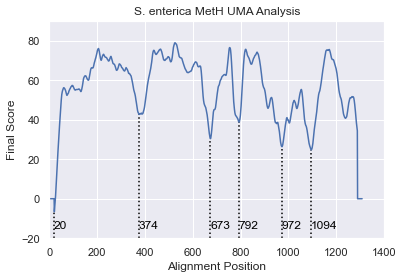

In [1350]:
# PLOT THE ALIGNMENT POSITION-FINAL SCORE GRAPH

x = np.linspace(1, aln_len_meth, aln_len_meth)
y = uma_meth_smd[3] # index 3 corresponds to S. enterica MetH

plt.plot(x, y)
plt.title('S. enterica MetH UMA Analysis')
plt.xlabel('Alignment Position')
plt.ylabel('Final Score')
plt.xlim(0, 1400)
plt.ylim(-20, 90)

# Identify local minima (compare 100 positions on each side to reduce counts) and plot them

minima_meth = argrelmin(uma_meth_smd[3], order = 100)
for num in range (0, len(minima_meth[0])):
    plt.vlines(minima_meth[0][num], ymin = -20, ymax = uma_meth_smd[3][minima_meth[0][num]], color = 'black', 
               linestyle = 'dotted')
    plt.annotate(minima_meth[0][num], (minima_meth[0][num], -15), color = 'black')

### UMA Results of S. enterica Methionine Synthase
The plot shows six local minima at alignment positions 20, 374, 673, 792, 972, 1094. The result is much similar to the sample analysis done by the author with Perl source code implementation, as shown below. Our plot curve for C-terminal domain (alignment position > ~600) has a nearly identical shape to that of sample analysis where local minima around 673, 792, 972, 1094 are also identified. The local minimum 20 is negligible since alignments at the very beginning are mostly gaps without biological significance. Therefore, our rewrite of UMA in Python is mostly successful.

<img src="Figure 3 UMA 1.png" width = '400'>

The major difference occurs in N-terminal domain (alignment position < ~600) where our plot curve is smoother with an extra local minima at alignment position 374. Furthermore, our plot curve is shifted slightly higher than that of sample analysis, representing a slightly greater final score for each alignment position. There must be some differences between Perl source code and our Python rewrite to account for this, but the effect is negligible and should not compromise the overall validity of our implementation. We can further compare our S. enterica MetH analysis to E. coli MetH analysis in the article:

<img src="Figure 4 UMA 2.png" width = '400'>

Four local minima in C-terminal domain (alignment position > ~600) corresponds perfectly between S. enterica and E. Coli. Local minima 673 and 972 in S. enterica correspond to local minima 676 (Y638) and 947 (H894) in E. coli respectively. These two positions are known trypsinolysis cut sites and thus assigned as first two linker regions. The third linker region locates around the local minima 792 (for S. enterica) and 794 (Q742, for E. coli), which connects cobalamin-binding domain. The fourth linker region locates around the local minima 1094 (for S. enterica) and 1089 (V1025, for E. coli), which resides in S-AdoMet-binding domain. The similar UMA analysis result of S. enterica and E. coli MetH proved their homology and further validate our Python rewrite.
***

### Predicting Linker Regions in A. erythreum PKS Module 1 and 2

Erythromycin is a broad spectrum polyketide antibiotic synthesized by S. erythraea. These polyketides are synthesized from simple building blocks such as propionyl-CoA and methylmalonyl-CoA through the action of large modular megasynthases called polyketide synthases (PKSs) [5]. Each module of a PKS contains multiple different domains (KS, ketosynthase; AT, acyl transferase; ACP, acyl carrier protein; KR, ketoreductase; ER, enoyl reductase; DH, dehydratase; TE, thioesterase) to load and modify incoming carbon building blocks. Therefore, PKSs with different module and domain compositions can synthesize polyketides with different lengths and functional groups, making them one of the most complicated and versatile assembly lines in nature. For example, 6-deoxyerythronolide B synthase (DEBS) utilizes 1 mole of propionyl-CoA and 6 moles of methylmalonyl-CoA to synthesize 1 mole of 6-deoxyerythronolide B (6dEB), as shown below.

<img src="Figure 5 Khosla et al Science 2001.png" width="800">

In Keasling Lab, we study the mechanism and engineering of various PKSs for the production of more valuable polyketide compounds. Like other multidomain proteins, PKSs also contain nonconserved linker regions between two adjacent catalytic domains, and recent research suggests that these linkers play a profound role in PKS structure and function [6]. Therefore, for this project, we aim to apply UMA to predict linker regions in PKSs that have structures not well understood to shed light on further structural studies. Research into erythromycin biosynthesis has focused nearly exclusively on S. erythraea, the only current commercial producer of this antiobiotic. However, A. erythreum also produces erythromycin, but the relevant biosynthetic gene clusters are not extensively studied [7]. We will use UMA to predict linker regions in the first two PKS modules of A. erythreum (GenBank: AAU93807.2, 3528 aa), using 8 other homologous sequences (including that of S. erythraea) obtained from BLAST (NCBI). Multiple sequence alignment is done by COBALT (NCBI) [8] and secondary structure prediction is done by PredictProtein server (Rost Lab) [9]. 

### Loading Data for A. erythreum PKS Module 1 and 2

In [1351]:
# Load multiple sequence alignment
# aln00_0000Aery gives the alignment for A. erythreum

aln00_0000Aery = 'MHDVRALGSALAADAATSRTDGHRSVVVLDDAASASDLVEVLDAVVAGRPHARLVEGAPRRDPGMTAFVFPGQGAQWPGMGARLREESSIFDEAMTRCLAVLGEELPGWSEDALHSEAALRAVEVVQPALYAVQTSLAALWQAHGVRADVVVGHSIGELAAARVAGAFSHDDGARGASRWSRAMMPLVGVGDMASVGLSLDEVLALLERWQDPDVELAGVNGPGSVLLAGAPDAVRRRVAELQAEGVRAQVIAVEMAAHSRQVDAVAADLAGAFDGLAPASLALPFVSSVAAGHVDGPDLVGAHWARCFREPVRYDQAVAVALADGVRTFVEVSPHPVLTAVTRQTIEGEGVEAQVVSTLRRDVGGWATFLQSLAQVWVAGTDVDWSAAYLGVEPAGLPVAVPVGPLSPAGAGPAGQEAAPSVAEFVAAVRAHAATVSGREVRADETFLDMGLDSVLVAQLRTQLQEELGRAVPITSFYDFPTPQALAEALTGGSDRRPARPAPPVARVDDEPIAIVSMACRLPGDVDTPERFWSILSEGRDLVDGLPADRDWDVDALLHQDTSRSGTTVQRAGGFLRAVADFDPAFFGLSPREALAMDPQQRVLLELSWEALERAGIAPYSLRRTRTGVFVGLIPQEYGPRLAEGGAG--VEGYLMTGTTSSVASGRIAYTLGLEGPALTVDTACSSSLAALHLACASLRRGETPLALVGGATIMPTPGMLVDFSRMGSLAADGRSKAFSADADGFGMAEGAGMVVLERLSDARRHGHPVLAVVRGSAMNSDGASNGLSAPNGRAQVRVVHDALVDAGLSAADVDLVEAHGTGTRLGDPIEASALRDAYGEDR--ERPLLLGSVKSNVGHTQAAAGVVGLMKLVLALRHELVPPTLHAAEPSTEIDWSDGTLELVQEPTPWHRGERPRRAGVSSFGISGTNVHAVLEEAPDTA-------AAPAP--PTTPVVPWVLSGASESAVATQAARLADHLEARPDLDPLDVAHALATGRSPLGHRVGLVP-SRDDAVAELRRVADGTSQAAR----GVVEAPLRPVFVFPGQGWQWAGMAVELLDSSPVFARTMRECARALRPHLDLDVVAFLREEAARATPGGALSTERVDHVQPVMFAVMVSLAATWRAQGVEPSAVVGHSQGEIAAACVAGLLTLEDAARIVARRSVAIAGMTRRGAMVSVAAPVEQVRERI---GDGLDVASVNSPTSVVVAGDADALERLVAECAADGVRATRLPVDYASHSRHVDDVERAVLEGLSPAPRPLPGAVPMLSTVTGRWVGPGELGPQYWFDNLRSTVRFSDAVETLVESGRTAFVEVSAHPILLAPVEQTAEAV----GVDVVTVGTLRRASGGPDELAASLARAFVGGVPVDWQETFRGSGATPVELPTYPFERRRIWWSPPDRRVSVGGEPDPRAYRISWRPVAADPGARLTGTWWVLHR-PDHD--AGLLAGVEQELSRRGAQVERLCVAPG----GAAHDVATRLDQGLDVAGVLSLLAVDAPEDTSAPLDSDAVRDLLGVVQSVVAAGATTRVWCVTSGAVATGPHEAVRTLGGGALWGLGRVVGLENPAVWGGLVDLPADVG--DDV--VSQLGAVLATDD-GEDQVALRGTGPWARRWVRVAAPA---TQQWRPQGTVLVTGATGGVGRHVARWLAGRGARRLVLLSRRGPQAPDAAALVRDLEEAGAEVDLRACDVTDRDALAAVLSYIGDDMPLTSVFHAAATLDDAVVTELTAERIERSSRAKVQGALHLDALTRAGDLDDFVLFSSFASAFGAPGLGGYAPGNAVLDAIAHERRRAGLPATSVSWGTWAGGGMAEGPVAERFRRHGVLLMDPDAATASLVSALDRADPAPIVMDVQWRRFLAAYTALRPTRLFDELSD---AAEPPAHPV--RGSEPAG---------PGRPQDVGALAALVRDRVATVLGHESSDAVDVDQPFSRLGVDSLSALELRNVLGTALGLRLPTTIVFDHPTTRRLTAHL----AEETGLSEQAVEAGRRPVDDRDDDRDDDPIVIVGMGCRLPGGVDGPQALWDLVAAGATTATDAPDDRSWSVGEL--------ARGGVARGSFIDGAGDFDAAFFGISPREALAMDPQQRHALQSVWETLEHAGIAPDSLRGSRTGVFVGHSNQGYGTGAVEQDVDLEGYRLTGSTASVVSGRVAYVLGLEGPAITVDTACSSSLVALHLAVGALRSGECELAVAGGVSVMAGPEVFVEFSRQGALAADGRCKPFSSAADGFGLGEGAAFVAVQRLSVARREGRRVWGVVAGSAVNQDGASNGLAAPSGVAQQRVIREAWARAGVGAGDVGVVEAHGTGTRLGDPVEASAVLATYGRGRGGAGPVLLGSVKSNVGHAQAAAGVAGLIKVVMGLSRGVVGPSVVVGSRSELVDWSAGEVELAEGLRAWPVGPDGVRRAGVSAFGISGTNAHVVVEQAPASE-----------PV-----------PAPAPGGLG--GDLVPLVLSARTPQALARLAKATVDRLAGDDAPDLADAAWTLATGRARLPHRAVVTA-DRASAVTRLGAVAEGLPSVHVATTDPSRPAAGVTGPVMVFPGQGAQWVGMASGLL-GVEVFASALAEVDVALGEVLGFSVREVLEGREGAPS----LDRVEVVQPALFAVMVSLARWWESVGVRPAAVVGHSQGEIAAAVVAGVLSVADGARVVARRALALRALSGGGAMASV-ALPVERVRAWVEQVGGLEVAAVNAPAQVVVAGDVAAVEALVEQGRREGVRVRRLAVDYASHSVHVERVREALVGELGVVQGRAGRVPVFSSLRGARVEGPELDGAYWYENLRGTVRFDAAVRAAMDEGHEVFLEVSPHPVLAAAVQETAAETGVDVAVLDTLERDVEEVGRLVRAAGAAFAAGLDVDWRALLAPAQVVPLATYPFEQRRYWLTPR-RAQVQDPLAG---------------------------------WFL------------------------------------------------------------------------------------------------------------------------------------------------------------TET----------------------------------------------WTSVT----------------------------------------------------------------------------------------------------------------PRPEQQV----------------------------------PEQ---------------------------------RTPQQPVPGRWWVVV--------------------------------------------PDDGPP------------------------PPWAGPLGDALRADGADARVV--------APAELGHELRPGDGVLSLLAVDSGDASATLALLARLQDHRGPV--------------WVATTSAVV--------VSDDDAARVRPDQA------------SVRALAQVAGLERGAAWT----------GLVDLPAASASEA---------PPALDVDAVVSALRG----------AEDQVAVRDGRVRAR-------RLVPHEVAASGPY------------------------------------------------------VPPTGTVVVTGGTSGLGAVTARWLI-GRGARSLALLSRRGPGTPGVEQLVAELRDAGAEVTVQACDVTDRASLRAALSVHDD---VTGVVHAAGLPQHQALADMDEASLRRVLDVKATGAALLDELVPDAGL--FLLFSSGAAVWGSNGQAAYAAGNAALDALARRRHAAGRAATSVAWGLW-ETGGMTQDQAAVDY--LRDRGVTPMASEAALSALERVLAVGVPNAVVAHIDWPTFAAAYCAARPRPLLDLLRGGTPTEGAQHEPEPAEETGAEAAPGLGDELAGLPAVERRARLLRLVRVHAAAVLGHDDPATIRPRDSFKDLGFDSLAALRLRDGLQKASGLTLSSTLVYDHADATEVAAYLDTRLDVDVPAAPSGTQGD-------------GLDRLEQELVAL-----DDAGRAAAVDRLLAVVARLRTTPAEPGPDEVADLAPDEVE-DDVEVDDDLLDADLDELVAALGRELGDDGGT-'
aln01_2898Sery = 'M--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------TDSEKVAEYL-----------------------------------------RRATL----------------------------------------------------------DLRAARQR--IRELESDPIAIVSMACRLPGGVNTPQRLWELLREGGETLSGFPTDRGWDLARLHHPDPDNPGTSYVDKGGFLDDAAGFDAEFFGVSPREAAAMDPQQRLLLETSWELVENAGIDPHSLRGTATGVFLGVAKFGYGE---DTAAAEDVEGYSVTGVAPAVASGRISYTMGLEGPSISVDTACSSSLVALHLAVESLRKGESSMAVVGGAAVMATPGVFVDFSRQRALAADGRSKAFGAGADGFGFSEGVTLVLLERLSEARRNGHEVLAVVRGSALNQDGASNGLSAPSGPAQRRVIRQALESCGLEPGDVDAVEAHGTGTALGDPIEANALLDTYGRDRDADRPLWLGSVKSNIGHTQAAAGVTGLLKVVLALRNGELPATLHVEEPTPHVDWSSGGVALLAGNQPWRRGERTRRAAVSAFGISGTNAHVIVEEAPEREHRETTAHDG-------RP-VPLVVSARSTAALRAQAAQIAELL-ERPDADLAGVGLGLATTRARHEHRAAVVASTREEAVRGLREIAAGAATADAVVEGVTEVDGRNVVFLFPGQGSQWAGMGAELLSSSPVFAGKIRACDESMAPMQDWKVSDVLRQAP------GAPGLDRVDVVQPVLFAVMVSLAELWRSYGVEPAAVVGHSQGEIAAAHVAGALTLEDAAKLVVGRSRLMRSLSGEGGMAAVALGEAAVRERLRPWQDRLSVAAVNGPRSVVVSGEPGALRAFSEDCAAEGIRVRDIDVDYASHSPQIERVREELLETTGDI-APRPARVTFHSTVESRSMDGTELDARYWYRNLRETVRFADAVTRLAESGYDAFIEVSPHPVVVQAVEEAVEEADGAED--AVVVGSLHRDGGDLSAFLRSMATAHVSGVDIRWDVAL-P-GAAPFALPTYPFQRKRYWLQPAAPAAASDE----LAYRVSWTPIEKPESGNLDGDWLVVTP-LISPEWTEMLCEAINA---NGGRALRCEVDTSASRTEMAQAVAQA---GTGFRGVLSLLSSDESA--CRPGVPAGAVGLLTLVQALGDAGVDAPVWCLTQGAVRTPADDDLARPAQTTAHGFAQVAGLELPGRWGGVVDLPESVD--DAA--LRLLVAVLRGGGRAEDHLAVRDGRLHGRRVVRASLPQ-SGSRSWTPHGTVLVTGAASPVGDQLVRWLADRGAERLVLAGACPGDD-----LLAAVEEAGASAVVCA---QDAAALREALGDEP----VTALVHAGTLTNFGSISEVAPEEFAETIAAKTALLAVLDEVFGDRAVEREVYCSSVAGIWGGAGMAAYAAGSAYLDALAEHHRARGRSCTSVAWTPWALPGGAVDD-GY-LRERGLRSLSADRAMRTWERVLAAGPVSVAVADVDWPVLSEGFAATRPTALFAELAGRGGQAEAE-----PDSGPTGEPAQRLAGLSPDEQQEN--LLELVANAVAEVLGHESAAEINVRRAFSELGLDSLNAMALRKRLSASTGLRLPASLVFDHPTVTALAQHLRARLVGDADQAAVRVV----GAAD-----ESEPIAIVGIGCRFPGGIGSPEQLWRVLAEGANLTTGFPADRGWDIGRLYHPDPDNPGTSYVDKGGFLTDAADFDPGFFGITPREALAMDPQQRLMLETAWEAVERAGIDPDALRGTDTGVFVGMNGQSYMQLLAGEAERVDGYQGLGNSASVLSGRIAYTFGWEGPALTVDTACSSSLVGIHLAMQALRRGECSLALAGGVTVMSDPYTFVDFSTQRGLASDGRCKAFSARADGFALSEGVAALVLEPLSRARANGHQVLAVLRGSAVNQDGASNGLAAPNGPSQERVIRQALAASGVPAADVDVVEAHGTGTELGDPIEAGALIATYGQDR--DRPLRLGSVKTNIGHTQAAAGAAGVIKVVLAMRHGMLPRSLHADELSPHIDWESGAVEVLREEVPWPAGE-RPRRAGVSSFGVSGTNAHVIVEEAPAEQEAARTER---GPL--------------------------PFVLSGRSEAVVAAQARALAEHLRDTPELGLTDAAWTLATGRARFDVRAAVLGDDRAGVCAELDALAEGRPSADAV---APVTSA-PRKPVLVFPGQGAQWVGMARDLLESSEVFAESMSRCAEALSPHTDWKLLDVVRGDGGPDP----HERVDVLQPVLFSIMVSLAELWRAHGVTPAAVVGHSQGEIAAAHVAGALSLEAAAKVVALRSQVLRELDDQGGMVSVGASRDELETVLARWDGRVAVAAVNGPGTSVVAGPTAELDEFFAEAEAREMKPRRIAVRYASHSPEVARIEDRLAAELGTITAVRGSVPLHSTVTGEVIDTSAMDASYWYRNLRRPVLFEQAVRGLVEQGFDTFVEVSPHPVLLMAVEETAEHAGAEVTCVPTLRREQSGPHEFLRNLLRAHVHGVGADLRPAVAGGRPAELPTYPFEHQRFWPRPH-RP-ADVSALGVRGAEHPLLLAAVDVPGHGGAVFTGRLSTDEQPWLAEHVVGGRTLVPGSVLVDLALAAGEDVGLPVLEELVLQRPLVLAGAGALLRMSVGAPDESGRRTIDVHAAEDVADLADAQWSQHATGTLAQGVAA-GPRDTEQWPPEDAVRIPLDDHYDGLAEQGYEYGPSFQALRAAWRKDDSVYAEVSIAADE------------------EGYAFHPVLLDAVAQTLSLGALGEPGGGKLPFAWNTVTLHASGATSVRVVATPAGADAMALRVTDPAGHLVATVDSLVVRSTGEKWEQPEPRGGE----GELHALDWVRLAEPGSTGRVVAADASD---------------LDAVLRSGEPEPDAVLVRYEP-EGDDPRAAA--RHGVLWAAALVRRWLEQEELPGATLVIATSGAVTVSDDDSVPEPGAAAMWGVIRCAQAESPDRFVLLD--TDAEPG---MLPAVPDNPQLALRGDDVFVPRLSPLAPSALTLPAG--TQRLVPGD-GAIDSVAFEPAPDVEQPLRAGEVRVDVRATGVNFRDVLLALGMYPQKADMGTE---AAGVVTAVGPDVDAFAPGDRVLGLFQGAFAPIAVTDHRLLARVPDGWSDADAAAVPIAYTTAHYALHDLAGLRAGQSVLIHAAAGGVGMAAVALARRAGAEVLATAGPAKHGTLRALGLDDEHIASSRETGFARKFRERTGGRGVDVVLNSLTGELLDESADLLAEDGVFVEMGKTDLRDAGDFRGRYAPFDLGEAGDDRLGEILREVVGLLGAGELDRLPVSAWELGSAPAALQHMSRGRHVGKLVLTQPAPVDPDGTVLITGGTGTLGRLLARHLVTEHGVRHLLLVSRRGADAPGSDELRAEIEDLGASAEIAACDTADRDALSALLDGLP--RPLTGVVHAAGVLADGLVTSIDEPAVEQVLRAKVDAAWNLHELTANTGLSFFVLFSSAASVLAGPGQGVYAAANESLNALAALRRTRGLPAKALGWGLWAQASEMTSGLGD----RIARTGVAALPTERALALFDSALRRGGEVVFPLSINRSALRRAEFVP------EVLRG------MVRAKLRAAGQAEAAGPNVVDRLAGRSESDQVAGLAELVRSHAAAVSGYGSADQLPERKAFKDLGFDSLAAVELRNRLGTATGVRLPSTLVFDHPTPLAVAEHLRDRLFA------ASPAVD---IGDRLDELEKALEALSA--ED----GHD------DVGQRLESLLRRWNSRR-ADAPSTS---AISEDASD------------DELFSMLDQRFGGGEDL-'
aln02_2836Mmeg = 'M--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------TDNDKVAEYL-----------------------------------------RRATL----------------------------------------------------------DLRAARKR--LRELQSDPIAVVGMACRLPGGVHLPQHLWDLLRQGHETVSTFPTGRGWDLAGLFHPDPDHPGTSYVDRGGFLDDVAGFDAEFFGISPREATAMDPQQRLLLETSWELVESAGIDPHSLRGTPTGVFLGVARLGYGE---NGTEAGDAEGYSVTGVAPAVASGRISYALGLEGPSISVDTACSSSLVALHLAVESLRLGESSLAVVGGAAVMATPGVFVDFSRQRALAADGRSKAFGAAADGFGFSEGVSLVLLERLSEAESNGHEVLAVIRGSALNQDGASNGLAAPNGTAQRKVIRQALRNCGLTPADVDAVEAHGTGTTLGDPIEANALLDTYGRDRDPDHPLWLGSVKSNIGHTQAAAGVTGLLKMVLALRHEELPATLHVDEPTPHVDWSSGAVRLATRGRPWRRGDRPRRAGVSAFGISGTNAHVIVEEAPERTTERTVGGDV-------GP-VPLVVSARSAAALRAQAAQVAELV-EGSDVGLAEVGRSLAVTRARHEHRAAVVASTRAEAVRGLREVAAVEPRGEDTVTGVAETSGRTVVFLFPGQGSQWVGMGAELLDSAPAFADTIRACDEAMAPLQDWSVSDVLRQEP------GAPGLDRVDVVQPVLFAVMVSLARLWQSYGVTPAAVVGHSQGEIAAAHVAGALSLADAARLVVGRSRLLRSLSGGGGMSAVALGEAEVRRRLRSWEDRISVAAVNGPRSVVVAGEPEALREWGREREAEGVRVREIDVDYASHSPQIDRVRDELLTVTGEI-EPRSAEITFYSTVDVRAVDGTDLDAGYWYRNLRETVRFADAMTRLADSGYDAFVEVSPHPVVVSAVAEAVEEA-GVED--AVVVGTLSRGDGGPGAFLRSAATAHCAGVDVDWTPAL-P-GAATIPLPTYPFQRKPYWLRSSAPAPASHD----LAYRVSWTPITPPGDGVLDGDWLVVHP-GGSTGWVDGLAAAITA---GGGRVVAHPVDSVTSRTGLAEALARR---DGTFRGVLSWVATDERH------VEAGAVALLTLAQALGDAGIDAPLWCLTQEAVRTPVDGDLARPAQAALHGFAQVARLELARRFGGVLDLPATVD--AAG--TRLVAAVLAGGG--EDVVAVRGDRLYGRRLVRATLPP-PGG-GFTPHGTVLVTGAAGPVGGRLARWLAERGATRLVLPGAHPGEE-----LLTAIRAAGATAVVCE---PEAEALRTAIGGEL----PTALVHAETLTNFAGVADADPEDFAATVAAKTALPTVLAEVLGDHRLEREVYCSSVAGVWGGVGMAAYAAGSAYLDALVEHRRARGHASASVAWTPWALPG-AVDD-GR-LRERGLRSLDVADALGTWERLLRAGAVSVAVADVDWSVFTEGFAAIRPTPLFDELLDRRGDPDGA--PVDRPGEPAGEWGRRIAALSPQEQRET--LLTLVGETVAEVLGHETGTEINTRRAFSELGLDSLGSMALRQRLAARTGLRMPASLVFDHPTVTALARYLRRLVVGDSDPTPVRVF----GPTD-----EAEPVAVVGIGCRFPGGIATPEDLWRVVSEGTSITTGFPTDRGWDLRRLYHPDPDHPGTSYVDRGGFLDGAPDFDPGFFGITPREALAMDPQQRLTLEIAWEAVERAGIDPETLLGSDTGVFVGMNGQSYLQLLTGEGDRLNGYQGLGNSASVLSGRVAYTFGWEGPALTVDTACSSSLVAIHLAMQSLRRGECSLALAGGVTVMADPYTFVDFSAQRGLAADGRCKAFSAQADGFALAEGVAALVLEPLSKARRNGHQVLAVLRGSAVNQDGASNGLAAPNGPSQERVIRQALTASGLRPADVDMVEAHGTGTELGDPIEAGALIAAYGRDR--DRPLWLGSVKTNIGHTQAAAGAAGVIKAVLAMRHGVLPRSLHADELSPHIDWADGKVEVLREARQWPPGE-RPRRAGVSSFGVSGTNAHVIVEEAPAEPDPEPVPAAPGGPL--------------------------PFVLHGRSVQTVRSQARTLAEHLRTTGHRDLADTARTLATGRARFDVRAAVLGTDREGVCAALDALAQDRPSPDVV---APAVFA-ARTPVLVFPGQGSQWVGMARDLLDSSEVFAESMGRCAEALSPYTDWDLLDVVRGVGDPDP----YDRVDVLQPVLFAVMVSLARLWQSYGVTPGAVVGHSQGEIAAAHVAGALSLADAARVVALRSRVLRELDDQGGMVSVGTSRAELDSVLRRWDGRVAVAAVNGPGTLVVAGPTAELDEFLAVAEAREMRPRRIAVRYASHSPEVARVEQRLAAELGTVTAVGGTVPLYSTATGDLLDTTAMDAGYWYRNLRQPVLFEHAVRSLLERGFETFIEVSPHPVLLMAVEETAEDAERPVTGVPTLRRDHDGPSEFLRNLLGAHVHGVDVDLRPAVAHGRLVDLPTYPFDRQRLWPKPH-RR-ADTSSLGVRDSTHPLLHAAVDVPGHGGAVFTGRLSPDEQQWLTQHVVGGRNLVPGSVLVDLALTAGADVGVPVLEELVLQQPLVLTAAGALLRLSVGAADEDGRRPVEIHAAEDVSDPAEARWSAYATGTLAVGVAG-GGRDGTQWPPPGATALTLTDHYDTLAELGYEYGPAFQALRAAWQHGDVVYAEVSLDAVE------------------EGYAFDPVLLDAVAQTFGLTSRAP---GKLPFAWRGVTLHATGATAVRVVATPAGPDAVALRVTDPTGQLVATVDALVVRDAGA--DRDQPRGRD----GDLHRLEWVRLATPDPTPAAVVHVAADG--------------LDDLLRAGGPAPQAVVVRYRP-DGDDPTAEA--RHGVLWAATLVRRWLDDDRWPATTLVVATSAGVEVSPGDDVPRPGAAAVWGVLRCAQAESPDRFVLVD--GD--PE---TPPAVPDNPQLAVRDGAVFVPRLTPLAGPVPAVADR--AYRLVPGNGGSIEAVAFAPVPDADRPLAPEEVRVAVRATGVNFRDVLLALGMYPEPAEMGTE---ASGVVTEVGSGVRRFTPGQAVTGLFQGAFGPVAVADHRLLTPVPDGWRAVDAAAVPIAFTTAHYALHDLAGLQAGQSVLVHAAAGGVGMAAVALARRAGAEVFATASPAKHPTLRALGLDDDHIASSRESGFGERFAARTGGRGVDVVLNSLTGDLLDESARLLADGGVFVEMGKTDLRPAEQFRGRYVPFDLAEAGPDRLGEILEEVVGLLAAGALDRLPVSVWELSAAPAALTHMSRGRHVGKLVLTQPAPVHPDGTVLVTGGTGTLGRLVARHLVTGHGVPHLLVASRRGPAAPGAAELRADVEGLGATIEIVACDTADREALAALLDSIPADRPLTGVVHTAGVLADGLVTSIDGTATDQVLRAKVDAAWHLHDLTRDADLSFFVLFSSAASVLAGPGQGVYAAANGVLNALAGQRRALGLPAKALGWGLWAQASEMTSGLGD----RIARTGVAALPTERALALFDAALRSGGEVLFPLSVDRSALRRAEYVP------EVLRG------AVRSTPRAANRAETPGRGLLDRLVGAPETDQVAALAELVRSHAAAVAGYDSADQLPERKAFKDLGFDSLAAVELRNRLGVTTGVRLPSTLVFDHPTPLAVAEHLRSELFAD-----SAPDVG---VGARLDDLERALDALPD--AQ----GHA------DVGARLEALLRRWQSRR-PPETEPV---TISDDASD------------DELFSMLDRRLGGGGDV-'
aln03_2836Aery = 'M--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------TDNDRVAEYL-----------------------------------------RRATL----------------------------------------------------------DLRAARQR--IRELESDPIAIVSMACRLPNGVNTPQRLWELLRDGGETLSGFPTDRGWDLASLYHPDPDNPGTSYVDKGGFLDDAAGFDAEFFGVSPREAAAMDPQQRLLLETSWELVENAGIDPHSLRGTATGVFLGIAKFGYGE---ESAAEEDVAGYSITGVAPAVASGRISYTMGLEGPSISVDTACSSSLVALHTAVESLRKGESTMAVVGGAAVMANPGVFVDFSRQRALAADGRSKAFSASADGFGFSEGVTLVLLERLSEAQRNGHEVLAVVRGSALNQDGASNGLSAPSGPAQRKVIRQALENCGLEPGDVDAVEAHGTGTALGDPIEANALLDTYGRERDADRPLLLGSVKSNIGHTQAAAGVTGLLKTVLALRNEELPATLHVEEPTPHVDWSSGDVALLADNQPWQSGERTRRAAVSAFGISGTNAHVIVEEAPEREEPESTAHDG-------RP-VPLMVSARGPAALRAQAAQIAELL-EQPVTDLAGVGLSLATTRARHEHRAAVVASTREQAVRGLREIASGTATAETMVEGVTEVDGRNVVFMFPGQGSQWIGMGAELLSSSPVFADRIRDCDEVMASMQDWKVSEVLRQDP------GAPDLERVDVVQPVLFAVMVSLAQLWRSYGVEPAAVVGHSQGEIAAAYVAGALTLEDAAKLVVGRSRLIRSLSGEGGMAVVSSGETAVRERLLPWQDRISLAAVNGPRSVVVSGDPDALREFSEACAAEGIRVREIDVDYASHSPRIERIREELLERTGDI-VPRPARVTFYSTVEPRAMDGTELDARYWYRNLREPVRFGDAVTRLAESGYDAFIEVSPHPVVLQAAEEAVEEADGAEE--GVFVGSLHRDGGDLSTFLWSVATAQVAGVEASWDVAL-R-GAATVALPTYPFQRERYWLQPATPAAASEE----LAYRVSWTPVDTPEPASLDGDWLVVAP-VRCPRWVDALCEAINV---NGGRALRREVDTSASRAEMARAVAHA---GSGLRGVLSLLAFDESG--CRPGVPAGAVGLLTLVQALGDAGVDAPVWCLTQGAVRTPVDDDLARPAQTTTHGFAQVAGLELTDRWGGVVDLPESVD--DAA--LRLLVAVLRGGDRVEDHLAFRDGRLYGRRVVRANLPR-AGSRSWTPHGTVLVTGAANPVGAQLVRWLADRGAERLVLAGAHPGDD-----LRAAVEEAGASAVVCA---QDAAALREVLGDEP----VTALVHAETLTNFGRISEVAPEEFADTVAAKTALFAVLDEVLGDRSVEREVYCSSVAGIWGGPGMAAYAAGSAYLDALAEHHRARGRSCASVAWTPWALPGGAVDD-GY-LRERGLRGLPVDSAMRAWERVLAAGPVSVAVADVDWPVFSEGFAATRPTALFAELVD-GGRAEAE--AAEPDAGPNSELARRLASLSPSEQRET--LLELVTNSVAEVLGHASAAEINVRRAFSELGLDSLNAMALRKRLSTMTGLRLPASLVFDHPTVTALAQHLRGLLVGDADRSAVRVA----DVAD-----DSEPIAIVGIGCRLPGGIGSPEELWRVLLEGANLTTGFPTDRGWDIGRLYHPDPDNPGTSYVDKGGFLPGAANFDPAFFGITPREALAMDPQQRLMLETAWEAVERAGIAPDSLAGSDTGVFVGMNGQSYMQLLAGESERVDGYQGLGNSASVLSGRIAYTFGWEGPTLTVDTACSSSLVGIHLAMRALRNGECSLALAGGVTIMSDPYTFVDFSTQRGLAFDGLCKAFSARADGFALSEGVGALMLEPLSRARANGHQVMAVLRGSAVNQDGASNGLAAPNGPSQERVIRQALASSGVPASDVDVVEAHGTGTELGDPIEAGALIATYGQDRDADRPLLLGSVKSNIGHTQAAAGVAGVIKVVLAMRHGVLPRSLHADELSPHIDWESGVVEVLREEVPWPVGE-RTRRAGVSSFGVSGTNAHVILEEAPDERETAELER---GPL--------------------------PFVLSGRGEAVVAAQARALAEHLRGTPDLGLADAAWTLATGRARFDVRAAVLGDDRSGVCAELDALAEGRPSADAV---APVTSA-PRKPVMVFPGQGSQWVGMARDLLESSEVFAESMSRCAEALSPHTDWKLLDVVRGDGAFDQ----HERVDVLQPVLFSIMISLAELWRAHGVAPAAVVGHSQGEIAAAHIAGALSLEAAAKVVALRSRVLRELDGQGGMVSVDASRDELETMLPRWDGRLSVAAVNGPRTSVVAGPSAELDEFFTEAQAQEMKPRRIGVGYASHSPEVARIEDRLAAELGTTTAAPGSVPLHSTVAGEVIDTSVMDSSYWYRNLRQPVLFEQAVRGLIDQGFDTFVEVSPHPVLLMAVEETAEDSDVEVTCVPTLRREQSGPHEFLRNLLRAHVHGVEADLRPSTAGGRPVELPTYPFEHQRFWPRPHRRP-SDVSALGVRGAEHPLLLAAVDVPGHGGAVFTGRLSTDEQPWLAEHVVGDRTLLPGSVLVDLALAAGEDVGLPVLEELVLQRPLVLTGASVLVRLSVGAADDSGRRTVDIHAAEEVADLAEAHWSQHATGRLAPGLAE-GARETGQWPPEGAVGISLEGHYDDLAEQGYVYGPSFQALRAAWRKDDALYAEVSIETDE------------------DGYAFHPVLLDAVAQTLSLGAFGDSSGGTLPFAWNGVTLHAYGATSVRVVATPAGPGAMALRVTDPAGRLVATVDSLIVRDSGEEWERPEPRDGG----GELHALDWVRLPEPGSAGRVVAVEASD---------------LDAVPRSGEPEPDAVLVRYEP-EGGDPRVVA--RHGVLWATALVRRWLEREESSAATLVIVTSGAVAVSDDDDVPDPGAAAVWGVIRCAQAESPNRFVLLD--TDADPG---TLPAVPDNPQLALRDDDVFVPRLSPLADSAPTLPEG--AHRLVPGN-GTIDSMAFESAPHVEQPLRAGEVRVDVRATGVNFRDVLLALDMYPEKASMGTE---AAGVVTAVGPDVDSFVPGDRVLGLFQGAFAPVAVTDHRLLAHVPDGWSDAEAAAVPIAYTTAYYALRDLAGLRAGQSVLIHAAAGGVGMAAVALAQRAGAEVFASASPAKHGTLRGLGLDDEHIASSREAGFARRFLENTGGRGVDVVLNSLTGELLDESAALLAEGGVFVEMGKTDLRAAEDFRGHYAAFDLGEAGDDRLGELLREVVGLLEGGELDRIPVSAWELAAAPAALQHMSRGRHVGKLVLTQPAPVDPEGTVLITGGTGTLGRFLARHLVTEYDVRHLSLVSRRGADAPGATDLREEIEGLGATAEVVACDIADRDSLSALLEELS--RPLTGVVHAAGVLADGLVTSVDEQAVEKVLRAKVDAAWNLHELTANTDLAFFVLCSSAASVLAGPGQGVYAAANEVLNTLAGFRRTRGLPAKALGWGLWAQESELTSGLGD----RIARTGVAALPTGRALALFDAALRRGGEVVFPLSINRSALRGAEFVP------EVLRG------MVRAKLPASGPT-ASGPNLVDRLTGRSEPDQVAELAELVRSHAAAVSGYGSADQLAERRAFKDLGFDSLAAVELRNRLDTATGVRLPSTLVFDHPTPLAVAEHLRERLFAN-----SSSSVD---IGGRLDELEKALEALSA--ED----GHD------DVGNRLESLLHWWNSRRTAGVRSTP---AINEDASD------------DELFSMLDQRLGGGEDL-'
aln04_2681Snou = 'M--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------TDNDKVAEYL-----------------------------------------RRATL----------------------------------------------------------DLRAARRR--IRELESDPVAIVSMSCRLPGGIDTPQRLWDLLEAGGETLSDFPADRGWDLSNLFHPDPDHPGTSYVRRAGFLADAGEFDADFFGISPREAAAMDPQQRLLLESCWELVESAGMDPHALRGSSTGVFLGVARHGYG-------ADSDADGYSVTGTAPSVASGRLSYSMGFEGPALTLDTACSSSLVALHLAIESLRRGECERAVVGGAAVMARPDVFVDFSRQRAIAADGRSKAFGAHADGFGFSEGVALVMLERLSDAERNGRHILALVRGSAINQDGASNGLSAPSRTAQRKVIRSALASCGINRAEVDAVETHGTGTTLGDPIEANALLDAYGHDRDVDRPLWIGSIKSNIGHTQAAAGVVGVLKMVLALRHETLPKTLHADEPTPHVDWSSGAVRLLTAAHPWPRTERPRRAGVSAFGISGTNAHVLVEEAPAPQPEEPGQR-------PDGP-VPLILSARGTAALRAQAQQIAAVA-EDRGTDLADLGHTLATARARHEYRAAVIAADRESAVRGLREVAAGRAE----IVGTAETGPRKVCFLFPGQGSQWAGMAAGLLDTAPVFAEEIRSCDEALAEFQDWSVESVLRQEP------GAPALDRVDVVQPALFAVMVSLAALWRSYGVEPDAVAGHSQGEIAAAYVAGALPLADAARLVALRSRSLRALSGQGGMLAVSLDEDGVRARLSAWGDRLAVAAANGPRSVVVSGDPEALRELAAECTEAGVRARMIDVDYASHSPQMDQVRAELDASLNGL-APRQTTVTFHSTVTCQVMRGADLDAGYWFRNLRETVRFADVVRTLADQGYDAFIEISPHPVLAGGVTDVLDAA---EHDTAMVVGSLQRDTDDRTAFLTSLATAHVDGADVRWQPAF-A-AAKTLDLPTYPFQRKHYWETPAPRALPQADG---LTYRASWTPLGDRGPAALDGTWLVVTAQAATPQWADELVRAIAE---HGGVPVVCTVDHATDPAVLTSAVAAAIDGVTDLRGVLSLLAADESGLPGRPGAPAGSVATTALTRAVRDAQLAAPMWCLTQGAVRTPGDDRLARPAQAAVHGLGRVAALELAERWGGTVDLPEAVD--DRA-LTCMLQVLAADWPRRESEVAVRANGLYGRRLVRANVAAGDWTP----HGTVLVTGAATPIGARLTRWLAANGAAHLVLVGERPDDE-----AHAPLTDVKTTVVTDP---AD---LGNVLETLPH--PVTALVHAETQTAFGALTELDLDDFADILAAKTELLFAIDAALSGRQLEREIYCSSVAGVWGATSMAAYAAGSAYLDALAEHRSLTGRPCTAVAWSPWADTGAAVDQ-AR-LRERGLRALSPERALEVWKRILGAGSGTVAVSDVDWPVFTEGYGATRPTALFDELAEHRVPATEDTGQAGRDDETVPTPRALLAGLPAAERLEQ--LIELVAEAVARVLGHGSAAEVNVRRAFSELGFDSLASVRLRKELVAATGLRLPASLVFDHPTVTALARHLDTRLAGDRSAQPAEQV-ARVWDHA-----QDEPIAIVGTACRLPGGIGSPQDLWRVMAGGEDRTSEFPTDRGWDLGQLYQPEPGHAGTSYVNRGGFLADVAGFDPAFFGITPREALAMDPQQRLLLETTWEALERAGSDPTGLRGSLTGVFVGSNGQSYMPLLESEAERVDGYQGLGNSASVLSGRLAYHFGWEGPAITVDTACSSSLVAVHLAIQALRRGECTLAVAAGATVMADPYTFVDFSTQRGLALDGRCKAFSAQADGFSLAEGAGVLVLQPLSQARREGRQVLAVLRGSAVNQDGASNGLAAPSGPAQERVIRAALADAGLSAHEIDAVEAHGTGTELGDPIEAGALIAAYGADR--DRPLWIGSVKSNIGHTQAAAGIAGVLKTVAALRHELLPRTLHAEQLSPHIDWPSGAVRVLQEDVPWPRGN-RPRRAGVSSFGVSGTNAHLIVEEAPAEP--APG-----------------TTPEPATGDS-----PVPLLLSARSGQALTAQAAALAAWLRDEPELDLADTAHTLARGRAQMDVRAAVVGEDRAEIIAGLEALAGGGATPQVV---PPQTIS-AGRPVLVFPGQGAQWLGMARDLLTRSEVFAAAMADCAAALAPHVDWDLLDVVRSSGDTDTDTDPYERVDVVQPVLFAIMVSLAELWRAHGVRPAAVVGHSQGEIAAAYVAGALSLDTAAKIVAVRSRVLRVLDGRGGMASVSASGDELATALAPWSGRLTVAAANGPRTQVVAGETDALEEFLAYATSHGMRPRRIAVRYASHSPEVELVEQQLLQELGETTAARSSVPFYSTVTGDAFDTTGMDTRYWYRNLRQTVCFEATVRRLLERGNHTFIEVSPHSVLLTGIEEIAEDANRDVECVATLRRGTDGPGEFLRNLVRAHVCGVDVDVRPAVPAGGLVELPTYPFEHQRFWPRPR-KRGGDPTAWGIRPTEHPLLSGAIDLPGDGGYVLTGELSLDEQPWLADHVVNGLALLPGSALVDLALTAGAQTCLSTLEELVLEAPLVLGEARSLLRVSVGAADGEGRRSVAVHTGT--GERDE--WFRHATGVLVEGRPDTDPVAQQ-WPPAGAEQIDLDDHYEHLAERGYAYGPAFRALHAAWRRDGEIYAEVTVPGAQDANDAA------------DRHTIHPVLLDAAAQTLSLGALGERDTAQLPFSWNNVSLYATGAVTVRVVATPAGPDAMSLRLVDPSGAPVASVESLVVRELDGD---WQAPSHEEP---ELYRLAWMPL--------AAAHPTVPAAVVALQDGDPDWDALT---ASGIPDVVAVPVGVDTPAEDDAPLGVTARQLVSSVSRLVRRWLDDPRFAHSTLVLVTHNAVSTARTEPVRNAAGAAVWGVVRSAQAESPGRFVLMD--TDAATEPLALLPAVLDHPQVALRAGTALVPRLLSGRPADVLLPPSSGAYRLVAGG-TTIDAVRFAPAPDAERPLAPGEVRIALRAAGVNFRDVLLALGVYPEAAHMGTE---GAGVVVETGSEVTGLAAGDEVMGLLEGGFGPLAVADHRLLARIPRGWRATEAATVPIAYATAHYALHDLAGVRAGQSVLIHAAAGGVGMAAIRLARAAGAEVFATASPGKHETLRGLGLDDDHIASSREPGFGAKFRAATGGRGVDVVLNSLTGELLDESADLLTSGGVFVELGKTDLRRPEQFDGRYRPFDLAEAGPDRLGEILAAAAATA-----EPLPVTAWRLEHAPAALAHMSRAQHIGKLVLTLPVPPDPDGTVLVTGGTGTLGRLLARHLVTGHGVRNLLLVSRQGAAAPGTRELTAELSGLGAKVTIATCDVADREALAALLAGIPEDRPLTGVVHAAGVLGDGLVTSIDADLVDRVFAPKVDAAWHLHELTADKQLSFFALFSSGASVLAGPGQGTYAAANAVLDALAGHRYAQGLSATALGWGLWAEASGMTGALSERDRERMARQGMAPLPTERALALFDLALLRGEPVVFPLALEQSAVRASPDAP------EVLRG------RVRAALRRADRGEAPGRSLADRLAGMSAEEQTATLSALVCTHAAAVAGHDGADAVPTTRSFRDLGFDSLAAVELRNRLGRAAGLRLPSTLVFDYPTPQAVAEYLRGKLVAP--------------PQQAIVDRLEGLEVALADLAA-GGSSEAFERDGEDIAKRMEKLLGWWNSLR-GKQDIGP---VDEVS--D------------EELFGLLDRRLGETEGAR'
aln05_2192Scel = 'M--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------TDNDKVASYL-----------------------------------------RRATL----------------------------------------------------------DLRAARQR--IHELEADPIAIVSTACRLPGGIDTPEGFWDVLAAGEERLSGFPDDRGWDLAGLYHPDPDHPGTTYVRTGGFLERAGDFDAAFFGISPREAAAMDPQQRLLLETCWELVENAGLDPHALRGTETGVFLGVARLGYGD---AGGPAGDAEGYTVTGAAPSVASGRIAYTLGLEGPAITLDTACSSSLVALHLAVASLRRGECGLAIVGGAAVMAGPEVFIDFARQRALASDGRSKAFGAGADGFGFGEGVAVLLLERLSDAERNGHTVHAVVRGTGINQDGASNGLSAPSRAAQRKVIEQALANAQVAPGDVDAVEAHGTGTTLGDPIEAHALLDTYGRHRSAQQPLWLGSAKSNIGHTQGAAGAVGVLKMVLALRHERLPRTLHAEEPSPHVDWSSGAVSLLAEERDWPRGERPRYAAVSAFGISGTNAHVVLQEAPEPQ--EAGEPATPQPVTPERP-VPLVVSARTEEALRAQAERLSAVL-ADTAVELPDLGFSLATARARHEHRAVVLAGSRASALLGMGEVAAGQAR----LKGTLESGGRSAVFLFPGQGSQWAGMGADLLAWSPVFAEAIQACDEAMAPWQDWSVAAVLRQEP------GAPGLDRVDVVQPALFAVMVSLAALWRSYGVEPAAVAGHSQGEIAAAYVAGVLTLEDAARLVVLRSRLLRSLAGQGAMAAVALDEATVREQLRPYGDAVEVAAVNGPASVVVSGEPEAVRSFAAGCADRGVRARTIDVDYASHSAQMEQVREELAEALWEL-RPARARVPFYSTVTCRPMEGEELDAHYWYRNLREPVRLHDVVRLLAAAHHDAFIEVSPQPVLAATVEETLEAE-GREPGEAVAVGTLRRDTPGPESFLTSAATAHVWGVDVHWQPAF-A-DARQVPLPTYPFQRKHYWTSTAAPARGAGE----VTYRVAWTPLPAAEAVDPSGTWLVVTP-AAAPAWAGPLVAALRE---SGATPLECALDPDLGRAEVAAALTAATAGTTGLRGVLSLLAADEADHRGRAGVPAGAVATLTLLQALGDAGVEAPLWCLTQGAVQTPEDDGIGSYAQSAVHGLGRVAGLELGQRWGGVLDLPRDVETAAGAALLARVPGILAGGHAAEDQLAVRADGLYGRRLVRAHTPAAADGHGRRLHGTVLVTGADSPIGERLARWAADGGADHLVLVGEA-SEE-----LLSALQDGGTTVTCCA---ADEDAVRAAVEAAPH--EVSTVVHAATRLEFGPVLDTDPEDFAATVHVKTGLALTLARVLDGRPVEREIHCSSVAGVWGGAGMSGYAAGSACLDAFAAHRRAQGHPSTAVAWSPWALPDAPRST-AQPAAQRGLRGLTAERALTVLQSVLDSGETAVAVSDVDWPAFAAGYGAVRPTALFGEIAEAREAAEPAAAPAGPDSGPAAELAGRLAGLTPAEQEDL--LITVVGEATAAVLGHDSAQDVNGRRAFSELGLDSLGTVQLRKRLSTATGLRLPASLVFDHPTITRLARHLLSRLAVGPRRESTAAPAGTAVN-A-----EQEPIAIVGMGCRLPGGIDSPEQLWRAVVDGQDLTSGLPRDRGWDLETLCHPDPDHPGTSYADRGAFLTDAAGFDAEFFGITPREALAMDPQQRLMLEVAWEAVERGGIDPDALRGSRIGVFVGSNGQSYMPLLESEADRVEGYQGLGNSASVLSGRLAYVFGWQGPAITVDTACSSSLVGIHLAMRALRSGECAMALAGGVTVISDPYTFVDFSRQRGLAADGRCKPFSAQADGFGLAEGAGALLLEPLSRARELGHPVLAVLRGSAVNQDGASNGLAAPNGPAQEEVIRQALADARLTAADIDVVEAHGTGTRLGDPIEAGALQATYGADR--ERPLALGSVKSNIGHTQAAAGVAGVIKTVLSMRHGVIPRSLHAEELSPEIDWSTGTIQVQQENEGWPQGP-RVRRAGVSSFGVSGTNAHVVVEEAPA---KAPA---------------DPAAPAERPAGSGLAAGTVALPLSARTHSAVTAQARALAELLRTSPETSLSDTARTLATGRARFDIRAAVLGEDRESVCAALDALAADEAMADVV---PPRTAT-ARRAVLVFPGQGSQWTGMAADLLDGSEIFAASMADCAAALAPYTDWDLLATLRGDGPDDA----FERPDVLQPLLFAVMVSLAALWRAHGVEPAAVIGHSQGEIAAACVAGALTLDTAAKVVALRSKVLRELNGQGGMASVTASPDELEAALAQWDGRLSVAAVNGPRSLVVAGEATALEEFLHSPQAGQMSPRRIAVGYGSHSPQVEQVEQRLADVLGTVPARSAAVPFCSTVTGSPLDTAGLDAAYWYRNLRGTVRLDEAVRHLMGQGFDTFIEVSPHPVLLSGIEQTAEDLGRDVVTRASLRRDRPGARTFLHNLLEAHADGLPVDLAPAMGPGGTADLPTYPFEHTSYWPRPR-RTRGDAGTLGLDAVAHPVLSTALEIP-DGGHLLTGRIALGDQPWLADHAVGGKPLFPGSALVDLALTAGRHAGTPALEELVLAAPLVLGPATA-VRVTVGAPADNGTRTVDVHARD--AHTPHAPWTRHATGVLGEAAT--PPAAPAAWPPPDARPIDLDAAYARLADRGYAYGPAFRALRAAWQRGEEVFAEAELPAAAGGNEA------GPSALGDEGYLLHPVLLDAAAQTLGLSSLADREGAFLPFSWSGTTLYASGATTVRVTAAPAGDDAMSLSVTDPTGAPVARVSAVTVRPVDGA---PLNGDGEEAGADDLYQLSWRPL--PETVGTAVSCVTVGGALPGLGKDYPDLAALAEAVAAGEPEPEAVIVHGRPWQPADAAGSV--RESVLHAAGLVRQWLDAPERT-GRLVFLTRHAVSAGPADTETDPAQAALWGLVRSAQAESPGNFVLVD--GDADLAALARFPAVLDHPQVALRGDLALVPRLSSTRGAAALLPPRTPA-RLEPAG-TSLDALAFAAAPDAGRQPGPGEVRVELRATGVNFRDVLIALGMYPGAAVMGTE---GAGVVTATGPGVTGVKAGDRVMGLFEGAFGPVTVADHRLVVPVPQGWSTTEAAALPIAFTTAHYALHDLAGLRPGQAVLVHAAATGVGLAAVRLARLAGAEVFATASPAKHDILRGLGLQDDHIASSREPGFGERFRSVRGGRGMDVVVNSLTGALLDESAELLAEGGAFVEMGKTDLRDPEQFHGRYLPFDLAEAGPDRLGAILAEVAALVADGKAGRLPVTAWPLQRASAALQHMSTGRHTGKLVLVQPAPLDADGTVLVTGGTGTLARLLARHLVTEHGVRHLLLLGRRGPAAPGAARFETELAELGASVTTLACDVSDRAALAAVLDGIPAAHPLTGVVHTAGVLADGLAASVGQDALAEVFAPKADAAWHLHELTAGCELSFFALFGSGASVLAGPGQGAYAAANAALDALARYRQARGLPATSLGWGLWEEASGLTGTLDERDTRRMARAGMLPLPTARALALFDLAIRRGDPVLYPLRLDTSRPQGPDGSP------EVLRG------LLHTPLRRAAREPAGGDGLAARLASLPRPDRLAALTEAVQAQAAAVAGYDTADSVPPGRQFKDLGFDSLASVELRNRLGAAVGLRLPSTLVFDHPTPEAVAVYVDGRLFA--DAP-GSPEADPRHPATEAAEHLAALEAALDGWRDIAGATEGAAGEHRAIEARLTALLGRWSATV-GGDTRTAGVDVDAVD--D------------DELFALLDQRFAEENEGR'
aln06_2172Syok = 'M--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------TDNDKVASYL-----------------------------------------RRATL----------------------------------------------------------DLRAARQR--IHELEADPIAIVSTACRLPGGIDTPEGFWDVLAAGEERLSGFPDDRGWDLTGLYHPDPDHPGTTYVRTGAFLERAGDFDAAFFGISPREATAMDPQQRLLLETCWELVENAGLDPHTLRGTETGVFLGVARHGYGD---AGGPSEDAEGYTVTGVAPSVASGRIAYTLGLEGPAITLDTACSSSLVALHLAVASLRRGECGLAIVGGAAVMAGPEVFIDFARQRALAFDGRSKAFGAGADGFGFGEGVAVLLLERLSDARRNGHTVHAVVRGTGINQDGASNGLSAPSRAAQRKVIEQALANAGVAPGEVDAVEAHGTGTALGDPIEAHALLDTYGRNRSAQQPLWLGSAKSNIGHTQGAAGAVGVLKMVLALRHERLPRTLHVEEASPHVDWSSGAVALLAKERDWRRGERPRYAAVSAFGISGTNAHVVLQEAPEPQ--EAEARANPQAVTPQHP-VPLVVSARTEEALRAQAQRLSAVV-ADTAVELPDLAFSLATARARHEHRAVVLAGSRESALQGMREVADGGAR----LRGSVESGGRSAVFLFPGQGSQWAGMGADLLAWSPVFAEAIEACDEAMAPWQDWSVAAVLRQDP------GAPGLDRVDVVQPALFAVMVSLAALWRSYGVEPAAVAGHSQGEIAAAYVAGALTLEDAARLVVLRSRLLRSLAGQGAMAAVALDEAAVLEMLRPYPGAVEVAAVNGPASVVVSGEPEAVHSFVAACAERGVRARTIDVDYASHSAQMEQVREELAEALREL-RPGRARVPFYSTVTCRPMEGEELDAPYWYRNLREPVRLHDVVRLLADAHHDTFIEVSPHPVLAATVEETLEAP-GLEPGEALAVGTLRRGTPGPESFLASVAGAHVFGVDVRWEPAF-A-DARRVPLPTYPFRRRHYWTSAAAPARGAGD----VTYRVAWTPLPAVQPAAAHGTWLVVTP-AAAPAWAAPLMAALRD---AGATPLECVLDPDLDRAEAAAALGVATAGVTGLRGALSLLAADESDHRGRAGVPTGAVATLTLLQALGDAGVEAPLWCLTQGAVQTSEDDGIGSFAQSAVHGLGRVAALELGQRWGGVLDLPRDVDTADGG-LLARVPGILAGAHAGEDHLAVRADALYGRRLVRARTQTAPGGPARRLHGSVLVTGADSPIGERLARWAADGGADHLVLVGEA-GEE-----LLSALRDGGTTVTRCA---ADEDAVRAAVEAAPY--EVGTVVHAATRLEFGPVLDTDPEDFAATVHAKTGLALTLARVLDGRPVEREIHCSSVAGVWGGSGMSGYAAGSALLDAFAAHRRAQGHPSTAVAWSPWALPDAPRGT-AQPSAQRGLRGLTPDRALTVLQSVLDSGETAVAVSDVDWPAFAAGYGAVRPTALFGEIAEARESAEPAAAPAGPDSGPAAELAARLAGRTPAEQEKV--LITVVGEATAAVLGHDSAQDVDGRRAFAELGLDSLGAVQLRKRLSAATGLRLPASLVFDHPTITRLARHLLSRLATSPGPRSTAVVPGTARHDA-----GQEPIAIVGMSCRLPGGIGSPDALWRAVVDGRDLTSELPRDRGWDLATLCHPDPDHPGTSYADRGGFLLDAAGFDAEFFGVTPREALAMDPQQRLMLEVAWEAVERGGIDPDTLRGSRIGVFVGSNGQSYMPLLESEAARVEGYQGLGNSASVLSGRLAYVFGWQGPAVTVDTACSSSLVGIHLAMRALRGGECAMALAAGVTVICDPYTFVDFSRQRGLAADGRCKPFSAQADGFGLAEGAGALLLEPLSRAQELGHPVLAVLRGSAVNQDGASNGLAAPNGPAQEEVIRQALADARLSAADIDVVEAHGTGTRLGDPIEAGALLATYGADR--ARPLALGSVKSNIGHTQAAAGVAGVIKTVLAMRHGVVPRSLHAEELSPEIDWSTGTIRVQRENEDWPKGP-RVRRAGVSSFGVSGTNAHVVLEEAP----EAPA---------------DPAAPVDRPAGSGLAAGAVGLALSARTRSAVTAQARALAELLRTSPETSLADTARTLAAGRARLGIRAAVLGDDRESVCAALDALAAEDAAADVV---PPRTAA-ARKAVLVFPGQGSQWTGMAADLLDGSEVFARSMTDCAAALAPYTDWDLLATLRGEGPEDA----FERPDVLQPLLFAVMVSLAQLWRAHGVEPAAVIGHSQGEIAAACVAGALTLDTAAKVVALRSKVLTELNGQGGMASVTASPDELEPALAPWEGRLSAAAVNGPRSLVVAGEATALEEFLASPRAEGMSPRRIAVGYGSHSPQVEQIEQQLADVLGTVEARSAAVPFCSTVTGAPLDTAGLDAAYWYRNLRGTVRLDEAVRHLMGQGFDTFVEVSPHPVLLTGIEQSADALGRDVITLASLRRDRPGARTFLRNLLEAHADGLPVDLLPAVGPGGTAQLPTYPFEHTSYWPRPR-RTRGDATTLGMDAVAHPVLSTALEIP-DGGHVLTGLIALEDQPWLADHTVGGKTLLPGAALVELALAAGRHAGAPAVEELVLSAPLVLGPATA-VRVTVGAPAQDGTRTVDVHARE--ARAFDAPWTRHASGVLGEATP--PPAAPAAWPPPDARRIDLDAAYARLADRGYAYGPAFRALRAAWQRGEEVFAEARLPVAAGLAEAEAEGGSGRSAPGDEGHLLHPVLLDAAAQTLGLSSLADREGAYLPFSWSGTTLYASGATTIRVTAAPAGGDAMSLSVTDPMGAPVAQVSAVTVRPADEA---PQHGDGEQAGADDLYQLSWRPL--PETAATVLGCATVGGGLPGLGKDHLDLAALAAAVAAGEPEPEAVVAHCRPWQAADPAGSV--RASVLHAAEAVRQWLAAPQRT-GRLVFLTRHGVSAGPADTRTDPAQAAVWGLVRAAQAESPGNFVLVD--TDTDPADLAALPAVLDHPQVALRAGLALVPRLASTRTAPVLVPPRTPA-RLEPAG-TTLDALAFAAAPDAGRQPGPGEVRVELRATGVNFRDVLIGLGMYPGAAVMGTE---GAGIVTATGPDVTGVRAGDRVMGLFEGAFGPVAVTDHRLVVPVPPGWSTTEAAALPIAFTTAHYALHDLAGLRPGQAVLVHAGATGVGMAAVRLARLAGAEVFATAGPAKHDILRSLGLDDDHIASSRHAGFGQRFRSVRGGRGMDVVVNSLTGALLDESAGLLAKGGAFVEMGKTDLRDPQRFHGRYLPFDLAEAGPDRLGAILAEVAALVADGKVGRLPVTAWPLQRASAALQHMSTGRHTGKLVLVQPAPLDPDGTVLVTGGTGTLARLLARHLVTEHGVRHLLLLGRRGPAAPGADRFEAELGELGARVTTLACDVSDRAALAAAVDGIPDAHPLTGVVHTAGVLADGLAASVQQDALAEVFAPKADAAWHLHELTEGRELSFFALFGSGASVLAGPGQGAYAAANAALDALARYRQARGLPATSLGWGLWEEASGLTGVLDERDTRRMARAGMLPLPTARALALFDLAIRRGDAVLYPLRLNTSRPQDPDGSP------EVLRG------LWHTPLRRAAREESGTDAFAARLASLPRPDRLAALTEAVQAQAAAVAGYDTADAVAPERQFKDLGFDSLASVELRNRLGAAVGLRLPSTLVFDHPTPEAVAAYVDGRLFP--DAA-GSPQADPRR---RVVEQLDALEAALDGWPD---ATEDAVGQRAAIEARLTALLGRWSVTG-GGDSRRAVDAIDEVD--D------------EELFALLDQRFGEGNEGR'
aln07_2162Sgre = 'M--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------TDNDKVASYL-----------------------------------------RRATL----------------------------------------------------------DLRAARRR--IHELEADPVAIVGTACRLPGGIETPEAFWEVLAAGEERLSAFPEDRGWDLTGLYHPDPDHPGTTYVRTGAFLERAGEFDAAFFGVSPREAAAMDPQQRLLLETSWELIENAGLDPHSLRGTDTGVFLGVARHGYGD---TGGSAEDAEGYTVTGAAPSVASGRIAYTLGLEGPAITLDTACSSSLVALHLAVASLRRGECGLAIVGGAAVMAGPEVFVDFARQRALAADGRSKAFGAGADGFGFGEGVAVLLLERLSDARRRGHTVLAVVRGTGINQDGASNGLAAPSRAAQRKVIEQALANAGVAPGDVDAVEAHGTGTTLGDPIEAHALLDTYGRGRGPQRPLWLGSAKSNIGHTQGAAGAVGVLKMVLALRHERLPRTLHAEEASPHVDWSSGAVALLAEEQHWPRGERPRYAAVSAFGISGTNAHVVLQEAPAPE--ETGERAAPRPATPQHP-VPLVVSARSEEALRAQARRLSDVL-ADTDAELPGIGLTLATARARHEHRAVVVAGSRDLALHGMREVAAGAAR----LTGTVESGGRSAVFLFPGQGSQWAGMGADLLAWSPVFAETIRACDEAMAPWQDWSVAAVLRQQP------GAPGLDRVDVVQPALFAVMVSLAALWRSYGVEPAAVAGHSQGEIAAAYVAGALTLEDAARLVVLRSRLLRSLAGKGAMAAVALDEAAVRELLVPYAGAVEVAAVNGPASVVVSGEPAAVDSLVADCAGRGARARTIDVDYASHSAQMEEVREELAAALRDL-RPGRARVPFYSTVTGRPMDGGELDAGYWYRNLREPVRLHDVVRLLADAHHDTFIEVSPHPVLAATVEETLEAA-GREPGAALALGTLRRGAPGPESFLTFAASAHVEGVDVRWQPAF-GDDARPVALPTYPFQRKHYWTAPAGPARATGG----VTYRVSWTPLPAPEPADARGPWLIVGP-AASPAWAGLLPAAVRE---AGGTPLECALDPGLDRAGAAAALTAALAGTTGVRGVLSLLAADESDHPGRPGVPAGAVATLTLAQALADAGVDAPLWCLTRGAVQTDEDDGIGSYAQNAVHGLGRVAGLELGRRWGGVLDLPHP-DGADAA-LLGRVPGLLAGAHAAEDHLALRPGGLYGRRLVPVRTPATTDGTGPRLHGTVLLTGADSPIGARLARWAADSGADHLLLVGEA-DEE-----LLNALRERGTTATRCA---ADEDALRAAVEAAPH--DISTVVHAATRTEFGPVLATDPEDFAATLQAKTGLALTLAAVLDGRPVEREIHCSSVAGVWGGAGMAGYAAGSACLDAFAAHRRAQGHPSTAVAFSPWALPGTVPSA-PQ-AAQRGLRGLSADRALAALTSALDSGESAVAVSDVDWPAFAAGFGAVRPTALFAEISEARETAEPPAAPAAPDGSPAADLAARLTARTPAQREEL--LIGVVAEATAAVLGHDSAEDVSARRAFTELGLDSLGSVQLRKRLSAATGLRLPASLVFDHPTVTRLARHLLSLLAADSGPELAAAV-GSAPPSA-----EDEPIAIVGMSCRFPGGIGSPEELWRAVVDGQDLTGELPRDRGWELGALYHPDPDHPGTSYSDRGGFLADAAGFDAEFFGITPREALAMDPQQRLMLEVAWEAVERGGIDPDALRGSRVGVFVGSNGQSYMPLLRGEADRVEGYQGLGNSASVLSGRLAYTFGWTGPALTVDTACSSSLVGIHLAIRALRDGECAMALAGGVTVICDPYTFVDFSRQRGLAADGRCKPFSAQADGFGLAEGAGALLLEPLSRAIESGHPVLAVLRGSAVNQDGASNGLAAPNGPAQEEVIRQALADARLSAADIDLVEAHGTGTRLGDPIEAGALQATYGAPR--ARPLALGSVKSNIGHTQAAAGVAGVIKAVLAMRHGVIPRSLHAEELSPEIDWSPGTIRVQRENEDWPAGP-RVRRAGVSSFGVSGTNAHVVLEEAPAVPESAPAGAE-AAPVLPEAVAANVAAPAGRPGGRGLAADTAALVLSARTPSAVRAQAGALAALLRTSPATPLADTARTLATGRTRLDIRAAVLGDDRDSVCAALDALAAGEAAADVV---PPRTAA-PRKAVLVFPGQGSQWAGMAADLLSQSEIFAAAMADCAAALAPYTDWDLLATLRGDGPEDA----FERPDVVQPLLFAVMVSLAALWRAHGVEPAAVVGHSQGEIAAACVAGALTLDTAAKVVALRSKVLGELNGQGGMASVTAAPGELREALAPWDGRLSVAAVNGPRSLVVAGEAAALDEFLGSPRAEEMSPRRIAVGYGSHSPQVAQVEQRLADVLGTVPARSAAVPFCSTVTGAPLDTAGLDAAYWYRNLRGTVRLDQAVRTLMEQGFDTFVEVSPHPVLLPGIEQTAEDLGRDVVTLASLRRDRPGARTFLRNLLEAHADGLPVDLLPALEPGGTAELPTYPFEHTSYWPRPC-RTRADAAPSGMDSVAHPVLSAALETP-DGGHVLTGRITLGDQPWLADHAVGGETLLPGSALVDLALTAGRHAGTPAVAELVLCAPLLPGAATA-VRVTVGAPAADGTRTVDIHARD--TDAPGTPWTRHATGVLGEAAP--PPATPAVWPPADARPINLDAAYARLADRGYGYGPAFRALRAAWQRGAEVFAEAELPAAAGPDDAESA-----------GYLLHPVLLDAAAQTLGLGPLADRDGAFLPFSWTGTTLYASGATTIRVSAAPAGADAMSLSVTDPAGAPVAVVSAVTVRPAGGE---PGPRAGEETGADDLYHLTWRPL--PETTGRAVGCATIGGPC-GLGKDHPDLAALAAAVAAGEPEPEAVVVPCRPWQAADPAGSV--RESVLHAAGLVRQWLDAPERT-GRLVFLTRNAVSTGPADTAADPAQAAVWGLVRSAQAESPGNFALVDIADGADPAVLAALPAVLDHPQLAVRGDLALVPRLASTRTAPALLPPRTPA-RLEPAG-TSLDALAFAAAPDAGRQPGPGEVRVELRACGVNFRDVLIALGMYPGAAVMGTE---GAGVVTAVGPDVTGVAVGDRVMGLFEGAFGPVAVTDHRLVTPVPPGWSTTEAAALPIAFTTAHYALHDLAGVRPGQAVLVHAAATGVGMAAVRLARLAGAEVFATASPAKQGVLRSLGLDDDHIASSREPGFGRRFRAVRGGRGMDVVVNSLTGALLDESAELLAEGGAFVEMGKTDLRDADRFRGRYLPFDLAEAGADRLGAILAEVASLAAGGELGRQTVTAWPLQRASAALQHMSTGRHTGKLVLVQPAPLDPEGTVLVTGGTGTLARLLARHLVTEHGVRHLLLLGRRGPDAPGAARFEAELGELGATVTTRACDVSDRAALAAALDGIPAGHPLTGVVHTAGVLADGLAASLGEDELGTVLAPKADAAWHLHELTADREPNFFVLFGSGASVLAGPGQGAYAAANAALDALARYRQARGLPATSLGWGLWEEASGLTGALDERDTRRMARAGMRPLPTARALALFDLAIRRGDAVAYPLHLDTARAQGAQDAP------EVLRG------LLHTPLRRAARDQSGGDGLAARLAPLPRPDRLAALTHAVQAQAAAVAGYDTADAVAARRQFKDLGFDSLASVELRNRLGSALGLRLPSTLVFDHPTPEAVAVFVDGRLFAGADAA-GAPAPE---PGRSVAEHLAALEAVLEGWQE---AGEDTAGERRAIGARLTALSDRWSAVA-AGDSRTA---VDTVD--D------------EELFALLDQRFGEGNEER'
aln08_2154Sroc = 'M--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------TDNDKVASYL-----------------------------------------RRATL----------------------------------------------------------DLRAARRR--IHELEADPVAIVGTACRLPGGIETPEAFWEVLAAGEERLSAFPEDRGWDLTGLYHPDPDHPGTTYVRTGAFLERAGEFDAAFFGVSPREAAAMDPQQRLLLETSWELIENAGLDPHSLRGTDTGVFLGVARHGYGD---TGGSAEDAEGYTVTGAAPSVASGRIAYTLGLEGPAITLDTACSSSLVALHLAVASLRRGECGLAIVGGAAVMAGPEVFVDFARQRALAADGRSKAFGAGADGFGFGEGVAVLLLERLSDARRRGHTVLAVVRGTGINQDGASNGLAAPSRAAQRKVIEQALANAGVAPGDVDAVEAHGTGTTLGDPIEAHALLDTYGRGRGPQRPLWLGSAKSNIGHTQGAAGAVGVLKMVLALRHERLPRTLHAEEASPHVDWSSGAVALLAEEQHWPRGERPRYAAVSAFGISGTNAHVVLQEAPAPE--ETGERAAPRPATPQHP-VPLVVSARSEEALRAQARRLSDVL-ADTDAELPGIGLTLATARARHEHRAVVVAGSRDLALHGMREVAAGAAR----LTGTVESGGRSAVFLFPGQGSQWAGMGADLLAWSPVFAETIRACDEAMAPWQDWSVAAVLRQQP------GAPGLDRVDVVQPALFAVMVSLAALWRSYGVEPAAVAGHSQGEIAAAYVAGALTLEDAARLVVLRSRLLRSLAGKGAMAAVALDEAAVRELLVPYAGAVEVAAVNGPASVVVSGEPAAVDSLVADCAGRGARARTIDVDYASHSAQMEEVREELAAALRDL-RPGRARVPFYSTVTGRPMDGGELDAGYWYRNLREPVRLHDVVRLLADAHHDTFIEVSPHPVLAATVEETLEAA-GREPGAALALGTLRRGAPGPESFLTFAASAHVEGVDVRWQPAF-GDDARPVALPTYPFQRKHYWTAPAGPARATGG----VTYRVSWTPLPAPEPADARGPWLIVGP-AASPAWAGLLPAAVRE---AGGTPLECALDPGLDRAGAAAALTAALAGTTGVRGVLSLLAADESDHPGRPGVPVGAVATLTLAQALADAGVDAPLWCLTRGAVQTDEDDGIGSYAQNAVHGLGRVAGLELGRRWGGVLDLPHP-DGADAA-LLGRVPGLLAGAHAAEDHLALRPGGLYGRRLVPVRTPATTDGTGPRLHGTVLLTGADSPIGARLARWAADSGADHLLLVGEA-DEE-----LLNALRERGTTATRCA---ADEDALRAAVEAAPH--DISTVVHAATRTEFGPVLATDPEDFAATLQAKTGLALTLAAVLDGRPVEREIHCSSVAGVWGGAGMAGYAAGSACLDAFAAHRRAQGHPSTAVAFSPWALPGTVPSA-PQ-AAQRGLRGLSADRALAALTSALDSGESAVAVSDVDWPAFAAGFGAVRPTALFAEISEARETAEPPAAPAAPDGSPAADLAARLTARTPAQREEL--LIGVVAEATAAVLGHDSAEDVSARRAFTELGLDSLGSVQLRKRLSAATGLRLPASLVFDHPTVTRLARHLLSLLAADSGPELAAAV-GSAPPSA-----EDEPIAIVGMSCRFPGGIGSPEELWRAVVDGQDLTGELPRDRGWELGALYHPDPDHPGTSYSDRGGFLADAAGFDAEFFGITPREALAMDPQQRLMLEVAWEAVERGGIDPDALRGSRVGVFVGSNGQSYMPLLRGEADRVEGYQGLGNSASVLSGRLAYTFGWTGPALTVDTACSSSLVGIHLAIRALRDGECAMALAGGVTVICDPYTFVDFSRQRGLAADGRCKPFSAQADGFGLAEGAGALLLEPLSRAIESGHPVLAVLRGSAVNQDGASNGLAAPNGPAQEEVIRQALADARLSAADIDLVEAHGTGTRLGDPIEAGALQATYGAPR--ARPLALGSVKSNIGHTQAAAGVAGVIKAVLAMRHGVIPRSLHAEELSPEIDWSPGTIRVQRENEDWPAGP-RVRRAGVSSFGVSGTNAHVVLEEAPAVPESAPAGAE-AAPVLPEAVAANVAAPAGRPGGRGLAADTAALVLSARTPSAVRAQAGALAALLRTSPATPLADTARTLATGRTRLDIRAAVLGDDRDSVCAALDALAAGEAAADVV---PPRTAA-PRKAVLVFPGQGSQWAGMAADLLGQSEIFAAAMADCAAALAPYTDWDLLATLRGDGPEDA----FERPDVVQPLLFAVMVSLAALWRAHGVEPAAVVGHSQGEIAAACVAGALTLDTAAKVVALRSKVLGELNGQGGMASVTAAPGELREALAPWDGRLSVAAVNGPRSLVVAGEAAALDEFLGSPRAEEMSPRRIAVGYGSHSPQVAQVEQRLADVLGTVPARSAAVPFCSTVTGAPLDTAGLDAAYWYRNLRGTVRLDQAVRTLMEQGFDTFVEVSPHPVLLPGIEQTAEDLGRDVVTLASLRRDRPGARTFLRNLLEAHADGLPVDLLPALEPGGTAELPTYPFEHTSYWPRPC-RTRADAAPSGMDSVAHPVLSAALETP-DGGHVLTGRITLGDQPWLADHAVGGETLLPGSALVDLALTAGRHAGTPAVAELVLCAPLLPGAATA-VRVTVGAPAADGTRTVDIHARD--TDAPGTPWTRHATGVLGEAAP--PPATPAVWPPADARPIDLDAAYARLADRGYGYGPAFRALRAAWQRGAEVFAEAELPAAAGPDDAESA-----------GYLLHPVLLDAAAQTLGLGPLADRDGAFLPFSWTGTTLYASGATTIRVSAAPAGADAMSLSVTDPAGAPVAVVSAVTVRPVGGE---PGPRAGEETGADDLYHLTWRPL--PETTGRAVGCATIGGPC-GLGKDHPDLAALAAAVAAGEPEPEAVVVPCRPWQAADPAGSV--RESVLHAAGLVRQWLDAPERT-GRLVFLTRNAVSTGPADTAADPAQAAVWGLVRSAQAESPGNFALVDIADGADPAVLAALPAVLDHPQLAVRGDLALVPRLASTRTAPALLPPRTPA-RLEPAG-TSLDALAFAAAPDAGRQPGPGEVRVELRSCGVNFRDVLIALGMYPGAAVMGTE---GAGVVTAVGPDVTGVAVGDRVMGLFEGAFGPVAVTDHRLVTPVPPGWSTTEAAALPIAFTTAHYALHDLAGVRPGQAVLVHAAATGVGMAAVRLARLAGAEVFATASPAKQGVLRSLGLDDDHIASSREPGFGRRFRAVRGGRGMDVVVNSLTGALLDESAELLAEGGAFVEMGKTDLRDADRFRGRYLPFDLAEAGADRLGAILAEVASLAAGGELGRQTVTAWPLQRASAALQHMSTGRHTGKLVLVQPAPLDPEGTVLVTGGTGTLARLLARHLVTEHGVRHLLLLGRRGPDAPGAARFEAELGELGATVTTRACDVSDRAALAAALDGIPAGHPLTGVVHTAGVLADGLAASLGEDELGTVLAPKADAAWHLHELTADREPNFFVLFGSGASVLAGPGQGAYAAANAALDALARYRQARGLPATSLGWGLWEEASGLTGALDERDTRRMARAGMRPLPTARALALFDLAIRRGDAVAYPLHLDTARAQGAQDAP------EVLRG------LLHTPLRRAARDQSGGDGLAARLAPLPRPDRLAALTHAVQAQAAAVAGYDTADAVAARRQFKDLGFDSLASVELRNRLGSALGLRLPSTLVFDHPTPEAVAVFVDGRLFAGADAA-GAPAPE---PGRSVAEHLAALEAVLEGWQE---AGEDTAGERRAIGARLTALSDRWSAVA-AGDSRTA---VDTVD--D------------EELFALLDQRFGEGNEER'

aln_pks = [aln00_0000Aery, aln01_2898Sery, aln02_2836Mmeg, aln03_2836Aery, aln04_2681Snou, aln05_2192Scel, 
           aln06_2172Syok, aln07_2162Sgre, aln08_2154Sroc]

aln_num_pks = len(aln_pks)
aln_len_pks = len(aln_pks[0])

In [1352]:
# Load secondary structure prediction (and corresponding confidence)
# sspre00_0000Aery and sscon00_0000Aery give the prediction and confidence for A. erythreum

sspre00_0000Aery = 'LLL.L.....HHHHHH.........EEE..L...HHHHHHHHHHH..LLLLL.........LLL..EEEE.LL......HHHHHH..L..HHHHHHHHHHH.........HH....L..........HHHHHHHHHHHHHHHH.LL.........HHHHHHHHH....L.HHHHHHHHHHHHHHHH..LLL..EE..LLHHHHHHHHH...LLL.EEEE..LL..EEE.LL.HHHHHHHHHHH..LL...E.............HHHHHHHHHH.....LLL....E...............HHHHHHH......HHHHHHHH..LL.EEEE.LLL.......H......LLL.........LLL..HHHHHHHHHHH..LL.........LLL...LLLLL.........LLLLLL.................LLLL.............L...HHHHHHHHHHHH..LL.........LLLHHHHHHHH........H..HHHH....LLL.EEE.....LLLLLLLHHHHHHHH.........LLL..L.......LLLLLLLL.......................L.HH...LLHH....HHHHHHHHHH.LLLL..........EE.............L.....................EEE....L...........HHHHHHHHHHHH...........L.EEE.............L.LLL..........LLL...............HH..LLL.EEEEE........L...LLLLLLL.HHHHHHHHHHHH.LLL.L.........L...LL.HHHHHHHHHH..LLLLLL...........HHHHHHHH..HHHHHHHH...LLL......LLLL.............LLLLLLLLLLL.....................LLLLLLLLLLLLLL...EE..LL.HHHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EE..L.HHHHHHHHHH..LLLLL......LL..EEEEE.L.........HHH...L.HHHHHHHHHHHH.....L..HH.....LLLLLL..............HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH...LL..EE..LLHHHHHHH..LL.EEEE..LL..EEE.LLHHHHHHHHHHHH..LL...EE............HHHHHHHHHH......LLL....E........L....L...HHHH.......HHHHHHHHH.LL.EEEE.LL........H......LLL.........LLL..HHHHHHHHHHH..LL.........LLLL....LL............LLLL..L.L.LLL.............L.............L.............................................LL...............LLLL.................LLLL............LLLL....................L..........L..LL.............LL....................LL......LLLL......L......HHHHHH.......EEEE...LLLL..HHHHHHH...LLL.EEEE.......HHHHHHH.....LLLL...E......L......LL.................H.....LLL...EEEE..............HHHHHHHHHHHHHHH...LLL..................HHHHHH...L.LLL..HHHHHHHH....LLL.......L..........LLL..........LLL...........LLL..HHHHHHHHHHHHHHHHH..LLL.............LL....HHHHHHHHHH..LL....EEE..LLLHHHHHHHHHHH...LLLLL.............LLLL.EEEEE....LLLLLLLHHHHHHHH........LLLLLLLLL.....................L......L.HH...LLHH....HHHHHHHHHH.LLL...........E..............L......................EE....L...........HHHHHHHHHHHH..........LL.EEE.L...........L.LLL..........LLL...............HH..LLL.EEEEE........L...LLLLLLL..HHHHHHHHHHH.LLL.L.........L...LLLHHHHHHHHHH..LLLLLLLL...........HHHHHHHH..HHHHHHH....LLL......LLLL...............L.LLLLLLL......................LLLLLLLLLLLLL..LLL...EE...L.HHHHHHHHHHHHHHH..LLLLL...HHHHHHH.........EEE.L.HHHHHHHHHH..LLLLL............LLL..EEEE.L.........H.......HHHHHHHHHHH.....L..HHHH..LLLL...........HHHHHHHHHHHHHHHH.LL.........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EE..LLHHHHHHH...LLL.EEEE..LL..EEE.LLHHHHHHHHHHHHH.LL...EEE..........HHHHHHHHHHHH.....LLL...EE.......L....L...HHHH.......HHHHHHHHH.LL.EEEE.LL.....HHHH......LLL........LLLL.HHHHHHHHHHHH..L.........LLLL...LLL..........LLLL...............................................LLLLL..HHHHHHHHH..LL..............LLL..........LLLL....EE......LLLL...........LLLLL...L................LL........LL.....................L.......................LLLLLLLLLL..E...................L....EE....LLLL...HHHHHH...LLL..EE.................LLL..........LLL......L...................................................HHHHHHHH....LLL............L.......HHHHH..LLLLLL...HHHHHHH....LLL...................L.................LLLLLLLL........HHHHH...LL...HHHHHHHHHHHHH....LLLL....L........LL....HHHHHHHH.H..LL.....E...LLLHHHHHHHHHHH..LLLLLLL......HHHHHHHHH..........HHHHHHHHHHH..LLLLLLL...........LLLL....H.....LHHHHHHHHHH..LLLLLL'
sscon00_0000Aery = '987454401355655531100220478842634268888888876416776522420010366514788527530134455666513604788888888864110132045542045323433211156788899899888752764322311445688877663003547888888888788875215552255406658888786530378536777336723786057468998899886337502354310111220014578888888741134666320354103442342113435677875300002688998874166257762565100033454320135551144210036663257788887765236643410001355644356655411000003577765444221000011001026677343344201343053226677678776664056442134313787688888764333444454455662014785478740112556657878899887403322244665445441102366756666410102431000001242001427355304675544446767889876177753213332103653101112211124532221022202311021002457623445413221310246888889888764044102110460565143100111002354666433000003466542000001311003465405880578873000034453345557786267888888887536763543323102454345547888888987345665650100012120457876555438898887540356530002376664113423012112566665667753200200111200143110016776667766667732156315636888888988888752166767135677666421100011467406367888898874367765300003563058885264100123345664135278888898888642102543554210355666644320100010101567888889998998517753213114467898887512246688888888888888751145504654056688876521670588743773378606667898888988743761235543102122110477898898874301446664204641133323532246124677643110036888988850671688735632343434531001466711331101477643788889998874265200011104667632235542001110022456654454545564322332133213544343201233105334301222210000133301321110123332221001110134554100123344433346655212110122210013345565300010343134665543431101124443311233531000010145445611232233332146531113311432001110124554433335565044203531002355555543144046776214666621567776641157525675213232257887762034467753045302212544222356123323210000013445441035664416886301233344211246777788888888764237662122012322222220246777764046456713556766653203565324420251331000234565310012443456543321111224677245778888888998987623565222342112443055303367678776653166431367622777788888888762245555543213222221235788468885010255665787888888740433333566555655222344200024310011112521014273554036755333467789898761777421233320146420110000010135322210332023101210024465234354132213102468888888887540432010015615651530000010133546664320021023665430000013221123654058816788730000344533455577870378888989875478635422231024543455588888888873455666665021001222035777665643889888643045553001136665321341300110123545676676430001001012100220110067766677666554456731156403747888888898888751267766334567677643211130476506167888888764167775234200113444555148885264100233335442141468888888875411105436765305667320000111015678888889988886186422241144688988765122465888888888888898612565236541576888876402686278874276237860666789888999885377224655410322201257889888888520324565304652134323532246234777543101116888988851670688735642333556541102477722442002577505888888998863264201000136775123555410000123355654333333342334432221102134420111343444441010012355665225777787753155321001100123446554224443103566542145532024456653000013201256665444643121133443221235531244213554322210001010011000245410000000110001002344445566556665045412411000122344420364114553034666530367675542057623563113233002321012356642011012335654323445001200001222210011110234430133201212113421012443333578888764213676202210121344544330246666530566567044666776531035552234302421122000002543001110000133324556566553333321456766420560345566777776665432056664444520112311554034687787654510553320454137776888888888524677666544413456577776520121020247888888887514555677634333323334556543025432035678887776540555689'

sspre01_2898Sery = 'LLLHHHHHHHHHHHHHHHHHHHHHHH...LLL.EEE.....LLLLLLLHHHHHHHHH........LL...L.......LLLLLLLL.......................L.HH...LLHHHH..HHHHHHHHHH.LLL..........EEE...........LL......................EE...LLL..........HHHHHHHHHHH............L..EE.............L.LLLL.........LL...............HHHH.LLL.EEEEEE......LL...L.LLLLL.HHHHHHHHHHHH.LLL...............L..HHHHHHHHHH...LLLLLLL...........HHHHHHHHHHHHHHHHHH....LL......LLLL......L.......LLLLLLLLL......................LLLLLLLLLLLLLLL...EEE..L.HHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE..L.HHHHHHHHHH..LLLLL..........LL..EEEE..LL........HHH...L.HHHHHHHHHHHHH.......HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE..LHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...E............HHHHHHHHHHHH..L.LLL....E........L....LHHHHHHHH......HHHHHHHHH.LL.EEEE.LLL....H.HH.......LLLL........LLLL.HHHHHHHHHHHH..L..........LL....LLL...........LLLLLLL............LL..................L........................................L...........L..............HHHHHHH.....LLL............LLL.....................L.........LLL....HHHHHHHHHH...LL....................LLLLLLLLL.LLL..EEE..L...HHHHHHHHHHH.LLL.EEE..LLL..HHHHHHH..LL.EEEE............LLLL..EE.............LL.HHHHHH......HHHHHHH......L..EEEE..............HHHHHHHHHHHHHHHH..LLL.................HHHHH..LLLLLL.HHHHHHHHHH...LL...EE...L..........LLL................LLLLLL...HHHHH..LL.HHHHHHHHHHHHHHHHHH..LLL....L.............HHHHHHHHHHH..LL....EEE..LLLHHHHHHHHHH................LLLLLLEEEEE....LLLLLLLHHHHHHHH.........LLL..L.......LLLLLLLL.......................L.HH...LLH.....HHHHHHHHHH.LLL..........EEE.............L......................EE....LL..........HHHHHHHHHHHHH.L........L.EEE.............L.LLL..........LL...............HHHH.LLL.EEEEE.......LL...LLLLLLL.HHHHHHHHHHHH.LLL.L.............L..HHHHHHHHHH...LLLL............HHHHHHHH..HHHHHHHH...LL......LLLLL....L.........LLLLLLLLLL.....................LLLLLLLLL..LLL...E...L.HHHHHHHHHHHHHHH..LLLLL...HHHHHH..........EEE..LHHHHHHHHHHH..LLLLL........LLL.EEEEE.L......HHHHHH..LL.HHHHHHHHHHHH........HHHH..LLLL...........HHHHHHHHHHHHHHHH.LL....E....HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE.LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL..EEE...........HHHHHHHHHHHH.....LL....EE.......L....L.HHHHHH.......HHHHHHHHH.LL.EEEE.LL.....H.HHH.....LLL..EE....LLLL..HHHHHHHHHHH..L.........LLLL...LLL...........LLLL..........LLL..........LLL..EEE.....LLL.................HHHHHHHH.....L................LLL..EEEEE...L.LL..EEEEE......L.LLL...........LLLLLL..L.LLLLL.L..LLL..HHHHHHHH.....L...HHHHHHH...L..EEEE.............HHHHHHHHHH....LLLLLL..........EEE......EEEEE..LLL..EEEEEE.LLLL.EEE..................LLL............LLLLL.............H....LLLLL..EEE..LLLLLL..HHHHHHHHHHHHHHHHHH.....LLL.EEEE.......LLLLL.....HHHHHHHHH.....LLL.EEEE..LLL......LLLL.......L..........LLLLLLLLLL...L.L..............HH........................................L.EEEEE..L.....HHHHHH....LLLL..EEE...........LL.HHH.......HHHHHHHHHH...LLL..EEEE.........HHHHHHHH..HHHHHH.H....LL....................HHHHH...LL.........HHHHHHHH....LLL................L...........L......HHHH..................L.HHHHHHHHHHH...........LLLLLLLL.......L..HHHHHHHHHHHH..LL........LLLL...HHHHHHHHH..LLL......L...HHHHHHHHH..LLL....E.............LL..HHHH.........HHHHH...LLLL..EEEE.......LL...HHHHHHHHHHHHHHHHHH..LLL..................HHHHHHH.LLLLLL..HHHHHHHHHH..LLL............................L........LL....HH....LL...HHHHHHHHHHHHHHHH..LL.....L..............HHHHHHHHHH..LL.....E...LLLHHHHHHHHHH..LLLLLLLL......HHHHHH..LL.......HHHHHHHHHH..LLLLLLLLL.......LLHHHHHHHHHH...L..LL'
sscon01_2898Sery = '986788888888888888888876654037873787401125566578688888875033222446644454400014667566664200023311101012420013273564226766553478889888771787321243322057631021001123564333211220111002101144553235550322131024688888888864414411321135146514213311111015466653321000336521331002243200467661588157888521002455444545778647898888888852887142231310234444543788899998733466666750432102220367877667658999886530345530013466763002445323301456555667642012310112210121011016655556665556674126750361788888898888874055666125666565310001011477624748888888886416776531311101345640688742652012233355530352688888888886533114306775305667421010100015678888889988986277531242044678888876221366899998888888887521556346762475888887631368357877436623675066678888899887348503354320022330025778888888751154566410454114432353224656788865300003688888875067168873565033354654200024665513430013577525788888888774164210100013552002555410000001135665555432101123244554443333444100013445210033343321013420132024321101133321003454321010003454443432330024477777652002456640222012100355543234023343210000001254212110025654323567788887521356411100010110134332045766665554566338873251046788998887505754787425661457888764177258873021001000147875136741000144321236735777654112345555666421344541577630111003421234677767888888887632775111200111112220146777640665668367888888864047641455302512321110036774102101101112234656665303677652278056678899888999998724665333351022343043204577778776663067442256523777688888888742344332111111235678855787501125566578688988874043222346654453410024667565554100024311110012420014273564136754332468789898770777431133331156520110011221136321211010123200220024466334455033313102468888888887650531131104605551430000111022546654331100033664332000001100035655158805788740000345533455577872688888888875388725422241024444454478888889874345556311100111203677766554489998875303554200235666531145330012014566666676530002001122000001221167766665544675204640360688888888888876316676623467767642100221147751465788888888741677654032100366515887536420134555655405626788888888854121143178764056674310101100156788888899899851874313521446789887762224568898888888888886215662466625768898876203672688874266226750656889888888874487035654310223300256889888888520334564204651134323521245456887641112027888988851681678735632444546654310367712552002578634888889998874164200000025665333665420001012245675432112444456642110132045762167533034555310001023313302247888888730013642022201013303045672478887413545641677751244445455541000000103566665445455575454455603578888761233461135677776314523678740422243433436787888775412456665530002330036651344036888620566427888853688615554001110243101343345552220222100145766544333334001345431256777436751366555613578888998999888876212225652788730210135665643223567777755443027761687734865100001577622443036121011022456666566664445454212302211110355432323334421110022103332233432023443210462578861252222468888742045667436763100022212467456643000035667878875214555248886210000104688878752468877645442166411112000000122120045666530367311100023567777654214675133203332224234454433222221350224445665321101343343321124535567788776542210010024655556663113204521678888988776416610122024677740268889888641676200024523157888888523675420453100003320000563467664201100135577741356752468762011001551045677775668889988752278741010110220011013467777750765577146788888885337860433102412210123342011110024533344444554014554303784245688999999888876235542343510233330421033676776766630663421454137787888888886307777665542103467776520564201013588899888740556567765433312456588988888640453469'

sspre02_2836Mmeg = 'LLLHHHHHHHHHHHHHHHHHHHHHHH...LLL.EEEE....LLLLLLLHHHHHHHHH........LLL.LL.......LLLLLLLL................L......L.HH...LLHHHH..HHHHHHHHHH.LLL..........EEE...........LLL...................EEEE...LLL..........HHHHHHHHHHH............L.EEE.............L.LLLL.........LL.........E......HHH.LLL..EEEEE......LL...L..LLLL.HHHHHHHHHHHH.LLL.L.............L..HHHHHHHHHH..LLLLLLLL...........HHHHHHHHHHHHHHHHH.....LL......LLLL......L........L.LLLLLLL.....................LLLLLLLLLLLLLLLL..EEE..L.HHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE..L.HHHHHHHHHH..LLLLLL........LLL..EEEEE.LL........HHH...L.HHHHHHHHHHHH........HHHH..LLLLL..........HHHHHHHHHHHHHHHH.LL....E....HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE.LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...E............HHHHHHHHHHH.....LLL....EE............L..HHHHH.......HHHHHHHHH.LL.EEEE..L.....H.HH......LLLL..E.....LLLL..HHHHHHHHHHH..L.........LLL....LL............LLLLLLLL..........LLLL......LL................HHHH.....L.......................LLL..........L.L........HHHHHHH....LLLL............LLL....L..........................LLL......HHHHHHH..LLL........L..........LLLLLLLL.LLL..EEE..L...HHHHHHHHHHH.LLL.EEE..LLL.HHHHHHH..LLL.EEE......HHHHH...LLL..EEE............LL.HHHHHH..........HHH....LLL..EEEE..............HHHHHHHHHHHHHHHH..LLL................HHHHH..LL.LLL.HHHHHHHHHH...LL..EEE..............LLL....................LLLLL..HHHHHH..LL..HHHHHHHHHHHHHHHHH..LLL....L.............HHHHHHHHHHH..LLLL..EEE..LLLHHHHHHHHHHH................LLLL.EEEEE....LLLLLLLHHHHHHHH.........LLL.LL.......LLLLLLLL.......................L.HH...LL......HHHHHHHHHH.LLL..........EEE............LL....................EEEE....LL..........HHHHHHHHHHHH..L.......LL.EEE.............L.LLLL.........LL................HHH.LLL.EEEEE........L...LLLLLLL.HHHHHHHHHHHH.LLL.L.............L..HHHHHHHHHH...LLLL............HHHHHHHH..HHHHHHHH...LL.......LLLL...............LLLLLLLLL.....................LLLLLLLLLLLLLLLL....E...L.HHHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE..LHHHHHHHHHHH..LLLLL........LL..EEEEE.LL.....H..HHH...L.HHHHHHHHHHHH........HHHH..LLLL...........HHHHHHHHHHHHHHHH.LL....E....HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE.LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL..EEEE..........HHHHHHHHHHH......LL....EE............L..HHHHH.......HHHHHHHHH.LL.EEEE.LL.......HHH.....LLL...E.....LLL..HHHHHHHHHHH..L.........LLL....LLL..........LLLLL........L.LLL..........LLL..EEE....LL..................HHHHHHHHH.....LL...............LLL..EEEEEE..L.LL..EEEEE...LLLLLLLL.............LLL.....LLLLLLLL...L..HHHHHHHH.....L...HHHHHHH......EEEE..L........L.HHHHHHHHHH..LLLLL..........EEE......EEEEE..LLL..EEEEEE.LLLL.EEEE...............LLLLL..........LLLLLLL.................LLLLL..EEE..LLLLLL..HHHHHHHHHHHHHHHHHH.....LLL.EEEE.......LLLLL......HHHHHH.......LLL.EEEE..LLL....LLLL.......L..........LLLLLLLL..........L...L..........................L..........LLLLL..........EEEE............H......LLLL...E.............L..HH.......HHHHHHHHHH.....L..EEEE........HHHHHHHH....................L.L.............H.......LLL............H.HHH....LLL......LLLLLL................L..HHHHHHHHHHHHH.....LLLL.........HHHHHH..............LLLLLLL..EEE.....HHHHHHHHHHHH..LL.EEEE...LLLL...HHHHHHHHHH.LL.EEEE......HHHHHHHHH..LLLLL...EEE............LL.HHHHHH.......HHHHHHH...LLL..EEEE...........HHHHHHHHHHHHHHHHHHH..LLL..................HHHHHH..LL.LLL.HHHHHHHHHHH..LLL..EE.............L.........LL........L.....HH....LL....HHHHHHHHHHHHHH...LLL....L..............HHHHHHHHHH..LL.....EE..LLLHHHHHHHHHH..LLLLLLL.LL....HHHHHHH..LL........HHHHHHHHH...LLLLLLLL.........HHHHHHHHHH...LLLLL'
sscon02_2836Mmeg = '9856888888888888888788866540378737885000255665786888888750332224456545544100246676776642010243100010125210132635542367665534788898887627873212333211576410110011135654342212310110022002556632355503330310246788888888744144201000460565232022000001253656533110003365212211024543111455515880478885211024554445446786468888888888538873541224212344445447888999987345667677504431023312577776675589998864303455300134667520024451244013454556776520123101123100210210167665555555566752157502616888888988887623667672356665553110000104776247378888888864267765502200013566316888526520123333556404616898888888764221032066653156675310112110056788888899888861774312520346788887662224658899888888888875215562477625758888876304684588874267237850777789888898873476134543200223301367889898887401445664104652023102432346346777541001025788988851681688844641333546642100355662354101257764378888888876415310001112565412355431001011113577766654301012334556543233355301201444421023455554212453001012432100012333210355533113310245454431024466666652002567521444113100255544345024443210000000133212220015654321246777765326773204441253100111014567765554565238884252146788998887505853777336770577777630575488740331467765414677426751000144421246745777654201223444766421456642688730100003310334677667889889887631776212210211222321167775406645683678888898740477415664114112000000257641011101001222223444555550468887622781467788888889999886146662233510113430432045777788877640665522566328776888888887621444433211122245787457885010155665787889888740343323466545534000246675766631110243111010124200141625540367443223687899987618773211233311565201100001102563212111210131112100255763244550333131024688888888875405310110156056524300000110235466653311000236633221001133200236651588057887410003445334555778726888888888753886354222310244334544788888888743455564022100223125677666644899988753035542001346565311343411320034556667765301120010121102002210676667776666667741045403516888888988888863166766235677666421002201477514657888888876416777641421002564058875265101345446654046257888898888641112421787641576632012122101567888888998888628743225214467898876513346688988888888888862166634766256688988873126836888742762478606567898888888744871356554103233001567898888884103345641146512344224212453457775411121168889888616816887356424434467543103677224521014777348888889988731641000110256640126654211000143556654311134453555211102430367622676431455442001000133233031578888887300026520221021133130367723788885025466425788622455565555301321123213455544343555765654446115778887621323501456776664044136787405112333335467877876654056666422102200367623440478876205664278888536886266651112102440002435565530121100145677665432233422112321025778734776215666662267888899899988887520133565178874011013666554221345666664433202776168873476521135775223320460210110224566665654443222244532354301321244443221331001100053312222212666654321100121677630231121123454321135666424542110113333445346643011145678889886402345337887400001246888888641144321032321012201545000112124213454444104665201101110134545554104676133113556565200121100000002470457788888777653111366763200144446776654211123421111455555662488724414788888998875337506787414677630378888888860780689740334358889888531556874126751001034310026735677653100124566877531467534787630110014400566778878898888887631787201200111001221023677776406645780567888888863378714553104133210233641022110466432212345400245543047711346788998898877640355523335201233214310335656767676306634214652277868888888753067777654554324567887620564322210478889888630456776766433122234578888888640455689'

sspre03_2836Aery = 'LLLHHHHHHHHHHHHHHHHHHHHHHH...LLL.EEE.....LLLLLLLHHHHHHHHH........LL...L.......LLLLLLLL.......................L.HH...LLHHHH..HHHHHHHHHH.LLL..........EEE...........LLL.....................EE...LLL..........HHHHHHHHHHH............L.EEE.............L.LLLL.........LL...............HHHH.LLL.EEEEEE......LL...L.LLLLLHHHHHHHHHHHHH.LLL...............L..HHHHHHHHHH...LLLLLLL...........HHHHHHHHHHHHHHHHHH....LL......LLLL.....LL.......LLLLLLLLL......................LLLLLLLLLLLLLLLL..EEE..L.HHHHHHHHHHHHHH..LLLLL...HHHHH...........EEE..L.HHHHHHHHHH..LLLLL.........LLL..EEEE..LL........HHH...L.HHHHHHHHHHHHH.......HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL.EEEE.LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...E............HHHHHHHHHHHH....LLL....EE.......L....L.HHHHHH.......HHHHHHHHH.LL.EEEE.LL.....H.HH......LLLLL..E.....LLL..HHHHHHHHHHHH..L..........LLL...LLL...........LLLLL.L...........LLLLLL.........................H.....L...............HH.......L...........L.L...........HHHHHHHH.....LLL............LLL...............................LL....HHHHHHHHHHH....L..............H.....LLLLLLLLL.LLL..EEE..L...HHHHHHHHHHH..L..EEEE..LL..HHHHHHH..LL.EEEE............LLLL..EEE............LL..HHHHH.......HHHHHHH...LLLL.EEEE..............HHHHHHHHHHHHHHHH..LLL.................HHHHH..LLLLLL.HHHHHHHHHH...LL..EEE..............LLL..................LLLLLL..HHHHHH..LL..HHHHHHHHHHHHHHHHH..LLL..................HHHHHHHHHHH..LL.L...EE..LLLHHHHHHHHHHH................LLLLLEEEEE....LLLLLLLHHHHHHHH.........LLL..L.......LLLLLLLL.......................L.HH...LLH.....HHHHHHHHHH.LLL..........EEE............LL......................EE....LL..........HHHHHHHHHHHH..L........L.EEE.............L.LLL..........LL...............HHHH.LLL.EEEEE........L...LLLLLLL.HHHHHHHHHHHH.LLL...............L..HHHHHHHHHH..LLLLLLLL...........HHHHHHHH..HHHHHHHH...LL.......LLLL...............LLLLLLLLL.....................LLLLLLLLL.LLLL...E...L.HHHHHHHHHHHHHHH..LLLLL...HHHHHH..........EEE..LHHHHHHHHHHH..LLLLL........LLL.EEEEE.L......HHHHHHH..L.HHHHHHHHHHHH.....L..HHHH..LLLL...........HHHHHHHHHHHHHHHH.LL....E....HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE..LHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL..EEEE..........HHHHHHHHHHH.....LLL....EE............L..HHHHH.......HHHHHHHHH.LL.EEEE.LL.....H.HHH.....LLL..EE.....LLL..HHHHHHHHHHH..LL........LLLL...LLL...........LLLLL..........LLL..........LLL..EEE....LLLL................HHHHHHHHH.....L................LLL.EEEEEE...L.LL..EEEEE......L.LLL............LLLLL....LLLLL.L....L..HHHHHHHH.....L...HHHHHHH......EEEE..L..........HHHHHHHHHH...LLLLLLL..........EEE......EEEEE..LLL..EEEEEE.LLLL.EEE..................L.L...........LLLLLL..................LLLLL..EEE..LLLLLL..HHHHHHHHHHHHHHHHHH.....LLL.EEEE.......LLLLLL....HHHHHHHHH.....LLL.EEEE..LLL......LLLL.......L..........LLLLLLLLLL..............................EEEE....L............L............EEEE..........HHHH....LLLL..EEE...........LLL.HHH.......HHHHHHHHHH...L.L..EEEE.........HHHHHHHH...HHH.............L.......................LLL............HHHHH.....LL................L...........L....HHHHHHH...........L.......HHHHHHHHHHH...........LLLLLLLL..EEE..L..HHHHHHHHHHHH..LL.EEEE...LLLL..HHHHHHHHHHH.LLL..E...L...HHHHHHHHHH.LLLL..EE.............LL.HHHHH.........HHHHH...LLL...EEEE............HHHHHHHHHHHHHHHHHH..LLL..................HHHHHH..LL.LLL..HHHHHHHHHH..LLL.EEE.......................LLLLL.LLLLL..........LLL...HHHHHHHHHHHHHHH..LLL....L..............HHHHHHHHHH..LL.....E...LLLHHHHHHHHHH..LLLLLLL..L....HHHHHHH............HHHHHHHHHH...LLLLLLLL.......LLHHHHHHHHHH.....LLL'
sscon03_2836Aery = '985788888888888888878875653037873787401135566678688988875033221346644454400024667666664200024311111113421013273554226756553478889888772787311243321057641021001123565432111220121002201144663245550322131024678888888864314411321035156514202211100025465653322012446510222102242201357651588157888521002455444545678657888888889852887132122421244444544788999998742456666750432102231257777677778999887530345530023466762002455313301456666667641022410112310021021016666666666555675125750263688888888888863256756124555554200000011467624748888888886416776540211201356640688742652023333355531462689888888887543103206776416667432010100015678888889988986177530242034678888766222466899998988888887512666257761575888887630467357877427723785066789988898887347503453320122320037888989988852034566420455214421353234646777764200003688998885068168873564133354654100135665513541013577425788888988764154201011003555333665410011002245665545433111223345566654333444100023222000133444543114520110134320023455432003454443022210464533322220024567777653102467622444113100156644344002232101100000244212121135544325677787776521446420000110111345431045655565554566338874251045788898887504744788604672467888864178257873030001100146775136751110244321236734676554112444555666530456652688740000003411234677778888888887633775112201211113220037877630665668267888888864047741556411412210000246753001000000000112345565651267776522781356788998889999886246663333410223430432045787787777740564521465237776888888887522442222211011245788557885011255666786889888740333323466544544100247675656541110243111100124200142735540367543323687898987607874311333311566201210000102563112211101232102100244663344550333130024688888888876405411211045156524301100111235465542311000346643210000011011356652588057887300003445334555778726888888888753886243222310234444544788899998743566666750221011120367876666448999887540365421013466653113422000001446666667653100201211200020011016765666654567530464036068888889888887631777662346776664210022014775146578888888874167765403100036652588853641013455566651361689888988875301025217776305666431011221026688888889989985187421352144678988775222466888888888888888621666246652466888887620268258887426623786065688988888887448713566531132330025788989888741144566421465213432342123534677754101212788898886168168873564244454665320147771366210247763488888899887416520000002566634466541100100224566654311134444555321001320467631676441355563111000244023032578888887411126411332101133021466615788874135456425787622444454555310000002034656654344555654544446025778887603323501356777763144236787405322443334478878887654135565655200133200356622440368876215674278888536886156541001102441012434454532201220012567665443222342103344312577874477621565556136787888988898888762013357606887313101356556542235677777554431277616887348650001015786214320461210111224567776776543310011123200000001201323430156654203544001111003452100022100046665123300023455552102566531575200001334235674566430110356788888763025462378862101000146778886513455532033343100015440000011231123444320035552000111001245555542124763120134443443344544210001012501135667765422102432445422233455678888765311000221025665566641565135215788889887754275057763146776215788898987517852463025231588888887505665405620100133200015646787642000012455776413556423566530110014410467777878888888887641787311100011101200023677776406645770466788888863478705552203011102222310121001456655455555410243320377502357899999988887623665233352001222142103456677676763066342045413678688888888740667766544543235777765312420100134677888887513456555555422223456588988887540443579'

sspre04_2681Snou = 'LLLHHHHHHHHHHHHHHHHHHHHHHH...LLL.EEE.....LLLLLLLHHHHHHHHH.......LLL...........LLLLLLLL.......................L.HH...LLHHHH.HHHHHHHHHHH.LLL..........EEE.......LL.....................EEE....LL..........HHHHHHHHHHHH...........L..EE.L...........L.LLL..........LL...............HHHH.LLL.EEEEE.......LL...LLLLLLLHHHHHHHHHHHHH.LLL...............L..HHHHHHHHHH..LLLLLLLL...........HHHHHHHHHHHHHHHHHH....LL......LLLL...............LLLLLLLLL.....................LLLLLLLLLLLLLLLL..EEE..L.HHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE..L.HHHHHHHHHH..LLLL......LLLL.EEEEE.LL.......HHHH...L.HHHHHHHHHHHHH.......HHHH..LLLLL...........HHHHHHHHHHHHHHH.LLL...E....HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE.LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...EE...........HHHHHHHHHHHH....LLLL...EE............L.HHHHHH.......HHHHHHHHH.LL.EEEE.LL.....HHHHHH....LLLL........LLL..HHHHHHHHHHHH..LL.........LLL...LLL..........LLLLL.........................LL...E............HHH......................HHHHHHHH....L............L.LLLL.L.......HHHHHHHHHH...LLLL.............LL...LL..HHHHH...................LL....HHHHHHHHHHH....LL....................LLLLLLLLLL..EEE.....HHHHHHHHHHHH..L.EEEEE..LLL.......EEE......LHHHHHHHHH..LLLL..EEE.....L......LLHHHHHHHH...HHHHHHHHHH...LLL..EEEE.............HHHHHHHHHHHHHHHHH..LLL................HHHHHHH.LLLLLLHHHHHHHHHHHH..LLL.EEEE.............LLL.......................L.....HHHHHH..LL.HHHHHHHHHHHHHHHHHH.LLLL....L........L...HHHHHHHHHHHHH.LL.L..EEE..LLLHHHHHHHHHH....LLLLL...........LLLLLEEEE.....LLLLLLLHHHHHHHHH.......LLLL..........LLLLLLLL.......................L.HH...LLHHH..HHHHHHHHHHH.LLL..........EE..............L......................EE....LL..........HHHHHHHHHHHHH..........L..EE.............L.LLL..........LL...............HHHH.LLL.EEEEE.......LL...LLLLLLL.HHHHHHHHHHHH.LLL..................HHHHHHHHHH...LLLL............HHHHHHHHHHHHHHHHHH....L.......LLLL....L.........LLLLLLLLLL.....................LLLLLLLLLLLLLLLLLL...EE...L.HHHHHHHHHHHHHHH..LLLLL..HHHHHHH.........EEEE..L.HHHHHHHHHH..LLLLL........LL..EEEEE.LL........HHH...L.HHHHHHHHHHHHH....L..HHHH..LLLLLL.............HHHHHHHHHHHHHHHH.LL.........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EE..LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...EEE..........HHHHHHHHHHHH.....LLL...E........L...LL.HHHHHH.......HHHHHHHHH.LL.EEEE.LL..H.HHHHHH.....LLL........LLLL..HHHHHHHHHHH..LL........LLLL...LLL..........LLLLL..L.....LL.LLL..........LLL..EEE.........................HHHHHHHHH....L................LLL..EEEEE...LLLL...EEEE..LLLL.............LLLLLL....LLLLLLLL..L..HHHHHHHH.....L...HHHHHHH...L..EEEE..LL...............HHHHHHHHHH........LL...........EE......EEEE...LLL..EEEEEE.LLLL..EEE..............L.LLLL..........LLLLLLLL.......LL..........LLLL.........LLL..LL...HHHHHHHHHHHHHHHHHH......LL.EEEE.......LLL......HHHHHHHHHHHH...LLL.EEEE.LLLL...HHHH....LL..................LLLLLLLLLLLL..................L....L..L............L...H......LLLL..........EEEE..L................LLLL...E........L.LL.L..H......HHHHHHHHHHHHH..LLLL.EEEE.....HHHHHHHHHHH.LL.EEE..L...HHHHH..LLL........L..HHHHHHHH..LLL..........HHHHHHHHH...LL.EE........LLLLLL...........L..HHHHHHHHHH..LLLLL.......HHHHHHHHHHH....L..E....LLLLLL..EEE....HHHHHHHHHHHHH..LL.EEEEE..LLLL...HHHHHHHHHH.LL.EEEE......HHHHHHHHH..L..LL...EE.............LL.HHHHH.......HHHHHHH.....L...EEEE.............HHHHHHHHHHHHHHHHH..LLL....................HHHHHHHH..LLLLLL.HHHHHHHHHHH..LLL.......L.HH...LLLLLL................LLL..HHHHHH..LL.HHHHHHHHHHHHHHHHHH..LLL...LL...H....L.....HHHHHHHHHH..LL....EE...LLLHHHHHHHHHH..LLLLL............HHH..............HHHHHHHHHHHH.....LLLLLL.......LHHHHHHHHHH..LLL.LLL'
sscon04_2681Snou = '9857888888888888788888877641378737874012356666786888888750332112566444323110036675766542010133222111124100143745641367665545788898887617873211343210576420233455434333000123100110124566333455032213101467888888887540320143314624652521332110101546664331110023652233100001101245766258805788740000245543455577865789888888875277613323131124444454478889999874356766675022100123125787777876899988754124653112446666301343422440144556666765200120011230002100002677766665556677511575136168888888888876215666624677766641100000035652474888888887522676543111356751588852652013444566541471688888888887533102206775316667532010111004678888889988986187530352044678988776222465889888888888888621666446651586888888742168358886436723775067789988898886427612465310122330036788989988851043556520355202321231124646788764200103788898886057168873564144455787543125565313310135764158888989988841651000110045651246664100000133566554444333111122232333443333552245304323410234555443200333101113444332455676665310354422101000235455654543331035688998886303667521322023022045544455135666542111110033102331025533336778888888741245541000110123000001004556665566643887334147788889888750463578871256533333035674201345588998887416775147851111254210125767888876434555776767531357643788630111003411446777778888888887632786022311320112220157888650676678588888888875237761567520424431100136762124332220001000234444454342258887622780577788888889999986256663233510223331533066787888887750574532565226776888888876203456665422110002245687557884011255666787889988750443324556544433000147665555542000133111100124100142746641367665445788899888707874212332101564113100234420253223320001231001102134653334550333131024688888888876504402422046246524212310000136455543210110136642321000122101467662588057888410003455434555778725888888888753887243231310344444444788889998733465564121001112036787776755899998754134542101346665312453301220245666555775200010121221002100001676666666666555667412674136168888888888887621678663457777764100111025775146478888888764167765402000135641588853652013444465641453688888888886533115217865305666754311210011101568888888998888628742024114468898887632246688988888888898863055533554157688888763136726887643672367606578999888888743772246553103233101577888888885103446753045421344235212564568876420000278899898606806887366335456577643202567314420025776348888899998740653121221256750125654100110132556654453223455455542332022035673157633123444201100024313214036888888852211543011001103300136672478887403555540467750355564201110100024666755333456765665447136888887621223502455777763145236787336520000000113324477888887764113343455211112101245512320256764015664067887526886045551012101230002454576531012102245666666543100135542100100245776420112014555445540257788889888988887511121356068874021013665330004567888877655311776057761577630266654204763012203421000002245566767776554310124443120100136333354463103444300045412543321466653212321112687513541222222103332035656314541122112545545445420322566688889887504656516886222205788988888606516663371125677541776000012245117888877534665211320021367788787530486155403433346555652034310212472468889888751157675311132356888888765210361454124555777338862441588888899888640550678860467774037888888885178078973133316888988852254477402674011013310002684788664200134788887742133532256663011001442244578888889888887764277602210002321000002444557887753166557735777788888643786044420363654015677753101001100000134567146888752378056778898888999988723666234550245443154204477677665664066331256422778788888888741677664321110013445654210343222201368888888987631134566555210012355788878776405554678'

sspre05_2192Scel = 'LLLHHHHHHHHHHHHHHHHHHHHHHHH..LLL.EEE.....LLLLLLLHHHHHHHHH........LL...L.......LLLLLLLL.......................L.HH...LLHHHH.HHHHHHHHHHH.LLL...........EE...........LLL.....................EE...LLL..........HHHHHHHHHHHH...........L..EE.............L.LLLL.........LL...............HHHH.LLL.EEEEE.......LL...LLLLLLLHHHHHHHHHHHHH.LLL...............L..HHHHHHHHHH...LLLLLLL...........HHHHHHHHHHHHHHHHHH....LL.....LLLLL......L........LLLLLLLLL.....................LLLLLLLLLLLLLLLLLLLLL...E...L.HHHHHHHHHHHHHH..LLLLL...HHHHHH..........EEE..L.HHHHHHHHHH..LLLL.......LLL.EEEEE.LL........HHH.....HHHHHHHHHHHH........HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE..LHHHHHHHH...LL..EEEE..LL..EEE.LLHHHHHHHHHHHHH.LL...E............HHHHHHHHHHHH.....LLL...E........L....L.HHHHHH.......HHHHHHHHH.LL.EEEE.LL.....HHHHH.......LLLL........LLLL.HHHHHHHHHHHH..L..........LLL...LLL...........LLLL..L.............L.....L......................................................L.............LLL..............HHHHHHH.....LLL............LL....L....HHHH.........L.........L....L..HHHHHHH.........LLL............HH......LLLLLL....LLL..EEE..L...HHHHHHHHHH..LL.EEEE..LL.HHHHHH...LL.........HHHHHHHH..LLLL...EEE......L.....LL..HHHHH.......HHHHHHH...LLL..EEEE..............HHHHHHHHHHHHHHHH..LLL.................HHHHHH..LLLLLL.HHHHHHHHHHH..LLL...................LL..................LLLLLLLL...HHHHH...LL..HHHHHHHHHHHHHHHHH..LLL....L........L...HHHHHHHHHHHH..LL.L...E...LLLHHHHHHHHHHH...L...............LLLL.EEEEE....LLLLLLLHHHHHHHHH........LLL..........LLLLLLLL.......................L.HH...LLHH...HHHHHHHHHHH.LLL...........E..............L......................EE....LL..........HHHHHHHHHHHH...........L..EE.L...........L.LLLL.........LL...............HHHH..LL.EEEEE.......LL...LLLLLLL.HHHHHHHHHHHH.LLL...........L..LL..HHHHHHHHHH..LLLLL............HHHHHHHH..HHHHHHHH...LL.......LLLL....L.........LLLLLLLLL......................LLLLLLLLLLLLLLLLL....LLL...EE...L.HHHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE..LHHHHHHHHHHH..LLLLL........LL..EEEEE.L......HHHHHH...L.HHHHHHHHHHHH........HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE.LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...EE...........HHHHHHHHHHHH.....LL....EE............L.HHHHHHH......HHHHHHHHH.LL.EEEE.LL..HHHHHHHH.....LLL.........LLL.HHHHHHHHHHHH..L.........LLLL...LLL...........LLLL.............L..........LL..EEE........................HHHHHHHHHH....LL...............LLL..EEEEE..LLLL..EEEEE...LLLLLL...........LLLLLLLL.LLLLL.LL...L..HHHHHHHH.........HHHHHHH......EEEE..L.........LL..........HHHHHHHHHH....LLLLLL............EE......EEEEE..LLL..EEEEE..LLLL..EEE........L........LLL...........LLLLLLL.........L..............HHH....LLLLL..EEE...LLLL....HHHHHHHHHHHHHHHHH.......L.EEEE.......LLLLL.....HHHHHHHHH.....LLL.EEEE.LLLL...HHHH....LL.......L...........LLLLLLLLLL......LLL..............LL........................LLLL............EEE............H.......LLL............L.LLLL..HH......HHHHHHHHHHH....LL..EEEE.......HHHHHHHHHH...HH.......HHHH...LL.............HHH.....................HHHHHH...LLL.....LL.L..L................L..HHHHHHHHHHHH......LLLL.....HHHHHHHHHH..............LLL.LLL..EEE..L...HHHHHHHHHH......EEEE...LLLL...HHHHHHHHHH.LL.EEEE.......HHHHHHHH..LLLLL...EE.............LL.HHHHH.......HHHHHHHH....L...EEEE...........HHHHHHHHHHHHHHHHHHH..LLL.................LLLHHHHHHHH..LL.LLL.HHHHHHHHHHH..LLL...............LLL..........L.....LLLLL...HHHH...LL.HHHHHHHHHHHHHHHHHH..LL.....L........L.....HHHHHHHHHH..LL.....EE..LLLHHHHHHHHHH..LLLLLLLLLLL..................HHHHHHH..LLLLL.....HHHHHHHHH....LLLLLLL...........L.HHHHHHHHHH....LLLL'
sscon05_2192Scel = '9857888888888889888888766652378726874021355666786889888751332224466444544100246675666542010143201111124200142745642267665545788898887717873212334320466310110000136653332211102310011011446532455503221310146788888888754032024331362455242133321110154666533110002365323201100000123576625881578884100024554445557786578988888887538872432213102344445447888999987334667667503310111203678766677689999876412455300245677630024452232124455556676520022001223101320000267766666666766666667520464026078888889888875215666612466656643211002047762474788888888522676643000135650588852652001212355641243688888888876433102206776405666421000000005678888889988886287531242044678988776222466889888888888887511566325551476888887630368447887436622675066788988899887527712454320121331126778889988873133456520454102331453234635788864200103689999885068168873664244455775320001466662233000357864588888899887426401000001466513466541100012334677544544321111234445443445432210024444410001234442101344320012421101122321012234544411000001245554331233442013467777652002467641112023101366444454024556542222220054312221125434351356777764311110135652011110221025644202355555543345553277732502468888998874056358884156467777530155233331133688888774157874136751000245410025734677664202333555666530355641688740000003322123577777888888887631786312311321122210245788774067667847888888887513665033420141232100002465300110011001123344555555554125777642278145678888888999998724565223450023443153305578778776674066453145413777688888888752135444443233211124567745787502125566678688888885033322346654443400014666566664200024311000002410014274564136765443578889898770777421244420145420210000110145200122000233100010113465234455032213002468888888887540430242204614551530221000022546665331111023664321000110002145666348815788730000345533455577872678888888875388624333131024544554478888899873356656411000111204678776664489998875303554210134656531245342122134565666676420002011123100210110167656666656555555443456640367413507888888888888763166766336777666411002111477514757888888887417776531310013564158885364102445556654036267888888888642211420677541566621002111001568888888998898628753124114468898877623346688988888888988872156624665158688888763125835788743772378506578898888888743872246542013233122568988998885114345642046521444334212454568886520010389999888606716887366425556577644321667034410014675158889989988732741000001366753336654200000132355654330112433244532220344047742565332134342011000133022031578889988644316511433100033020467724788851255664157875124666665310100100145677655545557645544461157888876112234124556777630442356762360010000245543333221345788788766430365656541000231001465134313678863056642688874367860456521111004500101223555410000112345666555443322123543322223210344565430256776447651245565441256778889889888886410010250588740100136655532223567777765443117760687725876002555544037620000046200111122345556666555434334565434320110243346544000011101204321222221266654100000003135663022123101245433212466641442011103454556734653212025556888888741135632788740110235578888876444553112334566530266411000001201455544320144402223211123467777631157732311554544501121223334422047035778888877664202246776210005555677766320112331121045554667448873251146788888876430440567740467773047888898875078257762043314888888853155677412574000013310001572677764300013567788854034642256653011000440056678887889888988764168720001111220010013555568888753166467715677788888633786033432041321024677402432202454334455555123566540378256677888888888877513554234450133342153202367677677774066442145522777788888888640566777765552222221112321210026778876405665521224578878875410366667654432111113354778767675514445689'

sspre06_2172Syok = 'LLLHHHHHHHHHHHHHHHHHHHHHHH...LLL.EEE.....LLLLLLLHHHHHHHHH........LL...L.......LLLLLLLL.......................L.HH...LLHHHHHHHHHHHHHHHH.LLL..........EEE...........LL......................EE...LLL..........HHHHHHHHHHHHH.....H....L..EE.............L.LLLL.........LL...............HHHH.LLL.EEEEE.......LL...LLLLLLLHHHHHHHHHHHHH.LLL...............L..HHHHHHHHHH..LLLLLLLL...........HHHHHHHHHHHHHHHHHH....LL......LLLL....L..........LLLLLLLLL.....................LLLLLLLL.LLLLLLLLLLL...EEE..L.HHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE..L.HHHHHHHHHH..LLLL.......LLL.EEEEE.LL........HHH.....HHHHHHHHHHHHH.......HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE..LHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...EE...........HHHHHHHHHHHH.....LL....E........L....L..HHHHH.......HHHHHHHHH.LL.EEEE.LL....HHHHHH.......LLLL........LLLL.HHHHHHHHHHHH..L..........LL....LLL..........LLLLL................................LLL.......HHHHH............................................L.L.............HHHHHHHH.....LLL............LLL.....................L..................HHHHHHHH......LLL.............H......LLLLLLL...LLL..EEE..L...HHHHHHHHHH...L.EEEEE.LLLHHHHHHHH..LL.EEEE..L.HHHHHHHH..LLL...EE.............LL.HHHHHH.......HHHHHH....LLL..EEEE.............HHHHHHHHHHHHHHHHH..LLL..................HHHHH..LLLLLL.HHHHHHHHHHH..LLL..................LLL..................LLLLLLLL...HHHHHH..LL..HHHHHHHHHHHHHHHHH..LLL.........HH..L...HHHHHHHHHHHH..LL.L..EE...LLLHHHHHHHHHHH...LL................LLLLEEEEE....LLLLLLLHHHHHHHHH.......LLL...L.......LLLLLLLL.......................L.HH...LLHH...HHHHHHHHHHH.LLL...........EE.............L......................EE....LL..........HHHHHHHHHHHH...........L..EE.............L.LLL..........LLL...............HHH..LL.EEEEE........L...LLLLLLL.HHHHHHHHHHHH.LLL.L.........L...L..HHHHHHHHHH..LLLLL............HHHHHHHH..HHHHHHHH...LL.......LLLL....L.........LLLLLLLLL......................LLLLLLLLLLLLLLLL.L..LLL...EE...L.HHHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE.LLHHHHHHHHHHH..LLLLL........LL..EEEEE.L......HHHHHH...L.HHHHHHHHHHHH........HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EE..LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...EEE..........HHHHHHHHHHHH....LLL....EE............L.HHHHHHH......HHHHHHHHH.LL.EEEE.LL.....HHHHH.....LLL.........LLL..HHHHHHHHHHH..LL........LLLL...LLL...........LLLL.......L.....L..........LLL..E.........................HHHHHHHHHH....L................LLL..EEEEE..LLLL..EEEEE....LLLL............LLLLLLLL.LLLLL.L....L..HHHHHHHH.....L..HHHHHHHH......EEEE..L............LL..............HHHHHHHHH....LLLLLL............EE......EEEEE..LLL..EEEEE..LLLL..EEE.......LL........LLL............LLLLLLL........LL.............HHHH....LLLLL.EEE...LLLLLL..HHHHHHHHHHHHHHHHH.......L..EEEE......LLLL.......HHHHHHHH.....LLL.EEEE.LLLL..........LLL.......L..........LLLLLLLLLLLL......L.................LL....EEE.................L............EEE.....................LLL...E........L..LLL.HHH......HHHHHHHHHHHH...LL..EEEE.......HHHHHHHHH...............HHH..LLL...........HHHHH.....LL...............HHH....LLL......LLLLLL................L..HHHHHHHHHHHHH.....LLLLL.....HHHHHH..................LLLLLL.EEEE..L..HHHHHHHHHHHH..L...EEE...LLLL...HHHHHHHHHH.LL.EEEE......HHHHHHHHH..LLLLLL..EE.............LL.HHHHH.......HHHHHHHH....L.....E.............HHHHHHHHHHHHHHHHHH..LLL..................LLHHHHHHHH..LLLLLL..HHHHHHHHHH..LLL...............LLLL.......................HHHH...LL..HHHHHHHHHHHHHHHHH..LL.....L........L.....HHHHHHHHHH..LL.....EE..LLLHHHHHHHHHH..LLL.LLLLLLL........HHHHHHHH..LLLL.....HHHHHHHHHHHHH....LLLLLL............L.HHHHHHHHH..L.LLLLL'
sscon06_2172Syok = '985788888888888988888876654137872787301135566678688888875033122446644454400024667566654210013320001112420014274564226766655578889888771787311233432057631010101114664333320120121001102034552345550322131024678888988875504302532136245514213322211015465653311000246522331000011001467762588157888410002455444555678657898888888752887243221310244444544788899998743566766750331012120367876677668999887541245531123466762013544223212345555567652012301112310121000026776655545565555567640257503607888888988887521567661356665664221100104676247488888888863267754200024565157885265300223335564034368888888887653310320677640566742100000000567888888998888628753124204467898887622246688998888888888750365523555147688888752046835788743673267506778888888888743771235542013233112578898999886303445642045410333245312463477776420010478989988605825887356413456576543101446555123310035776458888889988742641100000146640236553000100232566654444332212233433323333333431000455542110135666532012332111332100011222101233333332210000234545422112243102456777765310146764033302320136554333302443420110011115421222112432223013556776654431146751010000221024544212455676653345554278732511357888998874045358885156556788876227626785236356787775237874136640000244420025745777664201223555666431355541688740000003422235678878888889887632786202201221112220013567764067667848888888887623666123431040221000023576301322122001122344555655554125777651278335678889888999998724565223340244554053205678788776664066453155413776688888888864035542200002100001346785578851101556657868888887502212135664445441001466756666410002431000001241001427466413675544357888989877077742123432014552022100001024632122210023310011011346523445503221300246888888888754043023220452465243013100002254666433111102366542100000000113455524881578873000034453245557787257888888887538861543323002454445447888889887435676640100011120467877666448999987540355420013465653113533001102456566667643100201212300242100006765666665555655454356741266413517888888888888752166767235777776421002101467515657888888887416776541320013564158885364101445556664046378888888888641111320787640566621012111001567888888998888618754134214468898877522346688998888888888872155523554057688888763126826788742662367506578998888988743772246653003233012577988998885104455642046511344234112463567886520010488999888606716887266424445567544202567034410024675048889989988732652000110256763336654211000132355654431113544244521120343046751354432133342022010244022031578899888644316401332011043030367723788850355664057875224465564300000101146677765545567645444461157888876113235235567777630442367764152010000123345544432112222344788777755321465556542000120102355233313678762056642788874357871455521110125501100113565422111220012556665543322112554221212101344666542146787536751145555662257778889889989886410000251477752000026655442323467777765443117761687725877201444322057620000036200111122455666666655543112354322010001310114455311456542014440021210234533100121111156541143001010100001002356632454100002354456645653111035666888888751035642788731110346788888874002111024120345653055521123311201566554310465403334433234444556310357723321455555521212013444422147146888888888876411036677542334555665421001010021242134555676158872450368888898887531541467641467764226888898886067068862143325888988853256687512564000013310001574688764300013577788854024533134542021000441046677887889888888774168710000001321000002456567888864076567704677788888633786033432041332114577502443202442232233344024676540378435567888888988887623554223351133343153203367678777774066442145522778788888888740656466766652112311166788765205665433045678888878766410366776543232123202464788888886405455679'

sspre07_2162Sgre = 'LLLHHHHHHHHHHHHHHHHHHHHHHH...LLL.EEE.....LLLLLLLHHHHHHHHH........LL...L.L.....LLLLLLLL.......................L.HH...LLHHHH.HHHHHHHHHHH.LLL..........EEE...........LL......................EE...LLL..........HHHHHHHHHHHH......H....L..EE.............L.LLLL.........LL...............HHHH.LLL.EEEEE.......LL...L.LLLLLHHHHHHHHHHHHH.LLL...............L..HHHHHHHHHH...LLLLLLL...........HHHHHHHHHHHHHHHHHH....LL.....LLLLL......L........LLLLLLLL......................LLLLLLLL.LLLLLLLLLLL...EEE..L.HHHHHHHHHHHHHH..LLLLL...HHHHHH..........EEE..LHHHHHHHHHHH..LLLL.......LLL.EEEEE.LL........HHH.....HHHHHHHHHHHHH.......HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE..LHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHHH.LL...E............HHHHHHHHHHHH.....LL....E........L....L.HHHHHH.......HHHHHHHHH.LL.EEEE.LL.....HHHHH......LLLLL........LLLL.HHHHHHHHHHHH..L..........LLL....LLL...........LLLL..............LLLLLL................................L........................LLLL............LLL..........HHHHHHHHH.....LLL............LLL...L....HHH....................LLL......HHHHHHHHH....LL....................LLLLLLLLLLLLLL..EEE..L...HHHHHHHHHH..LL..EEEE..LL..........L.........HHHHHHHH...LLL...EE......LLL....LL.HHHHHH.....HHHHHHHHH....LL..EEEE.............HHHHHHHHHHHHHHHHH..LLL..................HHHH..LLLLLL.HHHHHHHHHHH..LLL.EEE..............LLL................LLLLLL.LLLL..HHHHHH..LL.HHHHHHHHHHHHHHHHHH..LLL....L........L...HHHHHHHHHHHHH.LL.L...E...LLLHHHHHHHHHHH...LLL............LLLLL.EEEEE....LLLLLLLHHHHHHHHH........LL...........LLLLLLLL.......................L.HHH..LLHH...HHHHHHHHHHH.LLL...........E..............L......................EE....LL.........HHHHHHHHHHHHH...........L..EE.............L.LLLL.........LL...............HHHH.LLL.EEEEE........L...LLLLLLL.HHHHHHHHHHHH.LLL.L.........L...L..HHHHHHHHHH..LLLLL............HHHHHHHH..HHHHHHHH...LL.......LLLL....L.........LLLLLLLLL......................LLLLLLLLLLLLLLLLLL.........L..........LLLL..EEE..L.HHHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE..LHHHHHHHHHHH..LLLLL........LL..EEEEE.L.........HHH...L.HHHHHHHHHHHH........HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE.LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHHH.LL...EE...........HHHHHHHHHHHH....LLL....EE............L.HHHHHHH......HHHHHHHHH.LL.EEEE.LL..HHHHHHHH......LL........LLLL.HHHHHHHHHHHH..LL........LLLL...LLL............LL........L.....L.........LLLL..EE.........................HHHHHHHHH....LL..............LLL..EEEEEE..LLLL..EEEEE..LLLLLLL...........LLLLLLLL...LLL.LL...L..HHHHHHHH.....L..HHHHHHHH......EEEE..L...L.............HHHHHHHHHH...L.L.LLL...........EE......EEEEE..LLL..EEEEE..LLLL..EEE.......L.........LLLL...........LLLL...........L..............HH.....LLLLL.EEE...L.LLLL..HHHHHHHHHHHHHHHHHH......L.EEEEE......LLLL.......HHHHHHH......LLL.EEEE..LLL...HHHHHHHH.LLL.......L..........LLLLLLLLLLL......LLLL.L...........L...................H.....LLL...........................HHHHH....LLLL.............LLLL.HHH.......HHHHHHHHHH....LL..EEEE.......HHHHHHHHHH...............H...LLL...........HHHHH.....LL.............HHHHH....LLLL..........L................L..HHHHHHHHHHHHH......LLL.....HHHHHHHHH...............LLLLLLL..EEE..L..HHHHHHHHHHHH......EEE...LLLL...HHHHHHHHHH.LL.EEEE......HHHHHHHHH..LLLLL...EE.............LL.HHHHH.......HHHHHHHH....L....EE.............HHHHHHHHHHHHHHHHHH..LLL.................LLL.HHHHHHH..LLLLLL..HHHHHHHHHH..LLL..........H....LLL...H..............L.L...HHHH...LLL.HHHHHHHHHHHHHHHHH..LL..............L.....HHHHHHHHHHH.LL.L...E...LLLHHHHHHHHHH...LL.LLLLLLLLL.......HHHHHHHH.....LL....HHHHHHHHHHH.......LLLLLL.........LHHHHHHHHHHH..LL.LLL'
sscon07_2162Sgre = '98578888888888898888888666413787378840113556667868888887503312144564445450001466766665421002332010111342001437456422676665457888988887178732124443205653101010110256332332112012100110203455234555032203101467788898887540420253213524551421332221101546665331100034652232001000001246776258815788840000245544454567865788888888875288724322131023444454478889999874346676675032101112046887667776899988754124552113456676300244531321244556566764201230112231013100002677665554556566556764046751360788888898888752256666224666566321110000356523658888888875236775420002456515788526530112223556402436898888888765331022067764157674210000000155788888899889861875312410446789888762224668899888888888875025553365514768888876203683578874367326750666888888888875277223543201213311267889899888731234564204541134324522246457787641001047888998860682688736642444656764320135555522330013677645888888898874264110000024666423465520102101324667544443221122334556655322233312124444320012334443210345322002310111111222222102555543102200234465543321101245577777753102467631332023201366544453134555420001110143312331125754221145677777664124564011111022200342100356666666555555337874252135788888887405644787514560024432104523444113458888877424787413674201125553124674667765422345566677754014554267753012100331133567777888888988763278620220021001232111466664066566837788888887503665055641141221000013575300100000001123455555545565035777652278057788898888999998734566223450023444053205678788887775066453146413776688888888651145553311122334445667745788502125566678688888885033222346643444410014667566764200134310000012410014274565136665443578889898770777321243320145420221001221146200222001233100110114465244455032213002568888888887540430243203514552430131000012546665331111023664431012220113345766358806788730000344533455577872568888888875388615333130024544454478888889873356656401000111204678876664489998875403554210234655531245330011024565666676431001012122001321000267666666555555555543333444454434432334577513675036268888889888887631777762356776664321010114675147578888888774066765323101245641588853641023444466540463688888888886422114207776405666210121110015678888889988985187531241144788988776222466889988888888888711565235551576888887520368358887437623675065688988889887537722465430132330115689989988851143556430465113443341124545678865200004898998886067168873663355565776444103673123100257750588899899887416530002102567523466542110001223455443422135442445311203321567514653421333420220002440220314788888886443165113432000220035673478888502556642578762256776653100011001466777555444565465444621578888762233352456677777404422577632632254311111122244788778765530454545552000121001455134313678762056642788874357860456520000235411100123555522101110013567543444322223543332221001234554311467875477612454566612567888898899888875110002515787511000366554323234677777644431177605777347764036677876515752001104610011112245666666755544434455553543012213444543234420000230432345444306664321100221011334202212300235666543025675101111110344456674565321101455788898874114553278873011022578888887521333200301123454305550110000121267765431035540222332112235555542025775101244321353344433101221103613578888888766530001457532001565666665421100234212104555566634887325125788889888653044146774146766204788888887617815785214110588888885225667741256400101242100267367876420001357778875303464324554202100044114667778788988888876317872000112011001000255645788875317655771467778888864378612332114245321356623454310233111123454521367754027853567788888888887751355412334013444215210236767877777506645304542277878888888874145545666666553112124677777754103455211367788788765320123466655542212133455789888887614564569'

sspre08_2154Sroc = 'LLLHHHHHHHHHHHHHHHHHHHHHHH...LLL.EEE.....LLLLLLLHHHHHHHHH........LL...L.L.....LLLLLLLL.......................L.HH...LLHHHH.HHHHHHHHHHH.LLL......L....EE...........LL......................EE...LLL..........HHHHHHHHHHHHH.....H....L..E..L...........LLLLLL.........LL...............HHHH.LLL.EEEEE.......LL...L.LLLLLHHHHHHHHHHHHH.LLL...............L..HHHHHHHHHH...LLLLLLL...........HHHHHHHHHHHHHHHHHH....LL.....LLLLL......L.......LLLLLLLLL......................LLLLLLLL.LLLLLLLLLLL...EEE..L.HHHHHHHHHHHHHH..LLLLL...HHHHHH..........EEE..LHHHHHHHHHHH..LLLL.......LLL.EEEEE.LL........HHH.....HHHHHHHHHHHHH.......HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE..LHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHHH.LL...E............HHHHHHHHHHHH.....LLL...E........L....L.HHHHHH.......HHHHHHHHH.LL.EEEE.LL...HHHHHHHHH....LLLL.........LLLL.HHHHHHHHHHHH..LL.........LLL....LLL..........LLLLL.............LLLLLL........................HH.......L..........................LL............LLL..........HHHHHHHHH.....LLL............LLLL......HHHH....................LLL.....HHHHHHHHHHH...LLL...................LLLLLLLLLLLLLL..EEE..L...HHHHHHHHHH..LL..EEEE..LL...HHH....L...E....LHHHHHHHH...LLL...EE......LLL....LL.HHHHHH......HHHHHHHH...LLL..EEEE.............HHHHHHHHHHHHHHHHH..LLL.................HHHHH..LLLLLL.HHHHHHHHHHH..LLL..EE...............LL................LLLLLLLLLL...HHHHHH..LL.HHHHHHHHHHHHHHHHHH..LLL....L.....H..L...HHHHHHHHHHHH..LL.L...E...LLLHHHHHHHHHHH...LLL.............LLLL.EEEEE....LLLLLLLHHHHHHHH.........LL...........LLLLLLLL.......................L.HH...LLHH...HHHHHHHHHHH.LLL...........E..............L......................EE....LL.........HHHHHHHHHHHHH...........L..EE.............L.LLL..........LL..............HHHHH.LLL.EEEEE........L...LLLLLLL.HHHHHHHHHHHH.LLL...........L...L..HHHHHHHHHH..LLLLL............HHHHHHHH..HHHHHHHH...LL......LLLLL....L.........LLLLLLLLL......................LLLLLLLLLLL.LLLLLL.........L..........LLLL..EEE..L.HHHHHHHHHHHHHHH..LLLLL..HHHHHHH..........EEE..LHHHHHHHHHHH..LLLLL........LL..EEEEE.L......HHHHHH...L.HHHHHHHHHHHH........HHHH..LLLL...........HHHHHHHHHHHHHHHH.LLL........HHHHHHHHH....LHHHHHHHHHHHHHHHHH..LLL..EEE.LLHHHHHHHH...LL.EEEEE..LL..EEE.LLHHHHHHHHHHHH..LL...EE...........HHHHHHHHHHHH....LLL....EE............L.HHHHHHH......HHHHHHHHH.LL.EEEE.LL..HHHHHHHH......LL........LLLL.HHHHHHHHHHHH..LL........LLLL...LLL............LL........L....LL.........LLLL..EE.........................HHHHHHHHH....LL..............LLL..EEEEEE..LLLL..EEEEE..LLLLLLL...........LLLLLLLL.L.LLLLLL...L..HHHHHHHH.....L..HHHHHHHH......EEEE..L...L.............HHHHHHHHHH...L.L.LLL...........EE......EEEEE..LLL..EEEEE..LLLL..EEE........L........LLLL...........LLLL...........L............HHHHH....LLLL.EEEE...LLLLLL..HHHHHHHHHHHHHHHHHH......L.EEEE.......LLLL.......HHHHHHH......LLL.EEEE..LLL...HHHHHHHH.LLL.......L..........LLLLLLLLLLL......LLLL.L............L........................LLL.............EEE...........HHHH.....LLL..EEE..........LLL.HHH.......HHHHHHHHHH....LL..EEEE........HHHHHHHHH..HH...............LL............HHHHHH....LLL...........HHHHHHH...LLL...........L................L...HHHHHHHHHHH.......LLL.........HHHH................LLLLLLL..EEE..L..HHHHHHHHHHHH......EEE...LLLL...HHHHHHHHHH.LL.EEEE......HHHHHHHHH..LLLLLL..EE.............LL.HHHHH.......HHHHHHHH....L...EEEE...........HHHHHHHHHHHHHHHHHHH..LLL.................LLLHHHHHHHH..LLLLLL..HHHHHHHHHH..LLL...............LLL..HHH...............L...HHHH...LL..HHHHHHHHHHHHHHHHH..LL.....L........L.....HHHHHHHHHH..LL.....E...LLLHHHHHHHHHH...LL.LLLLLLLLL.......HHHHHHHH.....LL....HHHHHHHHHHH.......LLLLL..........LHHHHHHHHHHH.LLL..LL'
sscon08_2154Sroc = '98578888888888898888888666414787378740113556667868888887504312244664445450001466766665421002432000111242001427456412666665457888988887178732124453204663102110111355332333012012100110203455234555032213102467888888887550330253213523541521343221101556665331100023652232100001100146776358815788841000245544454567865789888888875288724322131024444454478889999874346676675032101212036787666776899988754124552013456676300243531221245656556764201230112331012101102677665654556566656764036751360788888898888751256666224666566321100000356514658888888875336775420003456515888526520112223556403436898888888765331032067764157774210000000155788888899888862875302420446789887762224668898888888888875125552365514768888875203672578874366326750667888888888875267223543201223301257888889888731234565204541134324521245457787642101047888998860682588736642455667865532135655412331012577645788888898874275121000124666412365542000001335566544433211122335566654322244320003444421113345543220345321002210100000011122102445544200011334455543200112345566677653002457630222112211366554443135555421012220144322220015664321256677777765114675100000023310011101456656666555555427884251046788888887405534788514550135654203523454214558888877413787412663001025553123674667765311234566677754025664268763112110331123567777888888888762278620221121001222102566664066566847888888887504765045641141232110002465410000000001123455555555554036777653178056788898888999998724566223450033454054305678788887774066453145413777688888888651245554211012233334567745788502125566678688988874033222446643444410024667676664200024311100012410014274564136765443578889898771787321243320146420220012231145200222000234100110114465244455032123002568888888887540430243304514652430121000012546664331111023674421012220124355766258806788730000344533455577872578888888875388614333131024543454378888889873356656311000111204678776664489999875303554210235656532245330011024565666676431002002213001320000167666666555455555544334444454334332333577512675036168888889888887631777772357776764221011103675147588888888874067765313100135641588852641024455566540463688888888886422113207776415666210121110015678888889988885177531241144788988776233466889988888888888721555246551576888887620368368877437622675065788988889887437832465430122331125689989988851144556420465113443341124545678865200004898998886067157873663355566776443103672123100156751588899899987326530002102566523466542100001323455443422135442455211202321567514653321333420110002430220314788988886443165113432000220035674268888503556642577751256777654100011000356777655454575565444621578888762122352456677777314423578642532354421110122234788778766530454545552000221001455134303678751167642688873367860456520111114510000123555522101210012567544444322223543333222003455665421467874577622455566604678888898898888865100102606887401101366554423234677777544431177605777347764035677876505762000104620011012345666666765544433455553532012113343454302201100120432012222026664310000110223556302312200345665320245674356520000243445674565321111455688898874014663378874001012468888888633554310210123333105540110011340057666542135550233432224456566652035774010134433453344433100000014601467788887765420101467632100344455654421001134212103555566734888325036888889888753044046774145766304788888888617815886214120588898885225667751256401001243101268468876421112357778886412464325665201100043005667778788989898877416871000111011000000155666888875317756781467788889874378612332024234310366614565310233111113444511366654037834567788888888887751355422235013444215220336767878777405644304531277879888888874135545666666552112123677677753013456212478888778765420233466655442111133465789888887505564468'

sspre_pks = [sspre00_0000Aery, sspre01_2898Sery, sspre02_2836Mmeg, sspre03_2836Aery, sspre04_2681Snou, 
             sspre05_2192Scel, sspre06_2172Syok, sspre07_2162Sgre, sspre08_2154Sroc]
sscon_pks = [sscon00_0000Aery, sscon01_2898Sery, sscon02_2836Mmeg, sscon03_2836Aery, sscon04_2681Snou, 
             sscon05_2192Scel, sscon06_2172Syok, sscon07_2162Sgre, sscon08_2154Sroc]

### Run UMA: Calling Functions and Plotting the Graph

In [1353]:
# FACTOR 1: HYDROPHOBICITY

hy_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
hy_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)

hphobicity (aln_pks, aln_num_pks, aln_len_pks, hy_pks_unsmd)
hphobocity_sm (aln_num_pks, aln_len_pks, hy_pks_unsmd, 5, hy_pks_smd)

# PARAMETER: averaging window width is 5

In [1354]:
# FACTOR 2: SECONDARY STRUCTURE

sspre_pks_unsmd = []
sscon_pks_unsmd = []
ssalign (aln_pks, aln_num_pks, aln_len_pks, sspre_pks, sscon_pks, sspre_pks_unsmd, sscon_pks_unsmd)

ss_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
ss_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
sstructure (aln_num_pks, aln_len_pks, sspre_pks_unsmd, sscon_pks_unsmd, ss_pks_unsmd)
sstructure_sm (aln_num_pks, aln_len_pks, ss_pks_unsmd, 5, ss_pks_smd)

# PARAMETER: averaging window width is 5

In [1355]:
# FACTOR 3: PRIMARY SEQUENCE

ps_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
ps_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)

psupdate (-4, 0)

psequence (aln_pks, aln_num_pks, aln_len_pks, ps_pks_unsmd)
psequence_sm (aln_num_pks, aln_len_pks, ps_pks_unsmd, 5, ps_pks_smd)

# PARAMETER: gap-to-aa penalty is -4; gap-to-gap penalty is 0
# PARAMETER: averaging window width is 5

In [1356]:
# WRAPPING UP: CALCULATING THE FINAL SCORE

uma_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
uma_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)

fscore (aln_num_pks, aln_len_pks, 1, hy_pks_smd, 1, ss_pks_smd, 1, ps_pks_smd, uma_pks_unsmd)
fscore_sm (aln_num_pks, aln_len_pks, uma_pks_unsmd, 35, uma_pks_smd)

# NOTE: each factor has the same weight 1
# NOTE: final averaging window width is 35

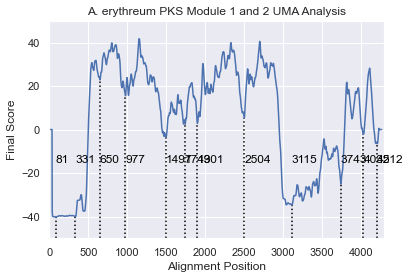

In [1357]:
# PLOT THE ALIGNMENT POSITION-FINAL SCORE GRAPH

x = np.linspace (1, aln_len_pks, aln_len_pks)
y = uma_pks_smd[0] # index 0 corresponds to A. erythreum PKS Module 1 and 2

plt.plot(x, y)
plt.title('A. erythreum PKS Module 1 and 2 UMA Analysis')
plt.xlabel('Alignment Position')
plt.ylabel('Final Score')
plt.xlim(0, 4300)
plt.ylim(-50, 50)

# Identify local minima (compare 125 positions on each side to reduce counts) and plot them

minima_pks = argrelmin(uma_pks_smd[0], order = 125)
for num in range (0, len(minima_pks[0])):
    plt.vlines(minima_pks[0][num], ymin = -50, ymax = uma_pks_smd[0][minima_pks[0][num]], color = 'black', 
               linestyle = 'dotted')
    plt.annotate(minima_pks[0][num], (minima_pks[0][num], -15), color = 'black')

### UMA Results of A. erythreum PKS Module 1 and 2

With a trial-and-error process, we figured out a set of parameters (see the comments above) that gives the most reasonable UMA analysis result. The plot gives 12 local minima across ~4200 alignment positions. To locate linker regions in our protein of interest, we first need to convert these alignment positions with a local minimum to their corresponding amino acids in the primary sequence.

In [1358]:
# Define a function to convert alignment positions to amino acids in the primary sequence

def alntoaa (alnpos):
    currentpos = 0
    aapos = 0
    while(currentpos < alnpos + 1):
        if aln_pks[0][currentpos] != '-':
            aapos = aapos + 1
        currentpos = currentpos + 1
    return aapos

# Aery is the primary sequence of A. erythreum PKS Module 1 and 2

Aery = 'MHDVRALGSALAADAATSRTDGHRSVVVLDDAASASDLVEVLDAVVAGRPHARLVEGAPRRDPGMTAFVFPGQGAQWPGMGARLREESSIFDEAMTRCLAVLGEELPGWSEDALHSEAALRAVEVVQPALYAVQTSLAALWQAHGVRADVVVGHSIGELAAARVAGAFSHDDGARGASRWSRAMMPLVGVGDMASVGLSLDEVLALLERWQDPDVELAGVNGPGSVLLAGAPDAVRRRVAELQAEGVRAQVIAVEMAAHSRQVDAVAADLAGAFDGLAPASLALPFVSSVAAGHVDGPDLVGAHWARCFREPVRYDQAVAVALADGVRTFVEVSPHPVLTAVTRQTIEGEGVEAQVVSTLRRDVGGWATFLQSLAQVWVAGTDVDWSAAYLGVEPAGLPVAVPVGPLSPAGAGPAGQEAAPSVAEFVAAVRAHAATVSGREVRADETFLDMGLDSVLVAQLRTQLQEELGRAVPITSFYDFPTPQALAEALTGGSDRRPARPAPPVARVDDEPIAIVSMACRLPGDVDTPERFWSILSEGRDLVDGLPADRDWDVDALLHQDTSRSGTTVQRAGGFLRAVADFDPAFFGLSPREALAMDPQQRVLLELSWEALERAGIAPYSLRRTRTGVFVGLIPQEYGPRLAEGGAGVEGYLMTGTTSSVASGRIAYTLGLEGPALTVDTACSSSLAALHLACASLRRGETPLALVGGATIMPTPGMLVDFSRMGSLAADGRSKAFSADADGFGMAEGAGMVVLERLSDARRHGHPVLAVVRGSAMNSDGASNGLSAPNGRAQVRVVHDALVDAGLSAADVDLVEAHGTGTRLGDPIEASALRDAYGEDRERPLLLGSVKSNVGHTQAAAGVVGLMKLVLALRHELVPPTLHAAEPSTEIDWSDGTLELVQEPTPWHRGERPRRAGVSSFGISGTNVHAVLEEAPDTAAAPAPPTTPVVPWVLSGASESAVATQAARLADHLEARPDLDPLDVAHALATGRSPLGHRVGLVPSRDDAVAELRRVADGTSQAARGVVEAPLRPVFVFPGQGWQWAGMAVELLDSSPVFARTMRECARALRPHLDLDVVAFLREEAARATPGGALSTERVDHVQPVMFAVMVSLAATWRAQGVEPSAVVGHSQGEIAAACVAGLLTLEDAARIVARRSVAIAGMTRRGAMVSVAAPVEQVRERIGDGLDVASVNSPTSVVVAGDADALERLVAECAADGVRATRLPVDYASHSRHVDDVERAVLEGLSPAPRPLPGAVPMLSTVTGRWVGPGELGPQYWFDNLRSTVRFSDAVETLVESGRTAFVEVSAHPILLAPVEQTAEAVGVDVVTVGTLRRASGGPDELAASLARAFVGGVPVDWQETFRGSGATPVELPTYPFERRRIWWSPPDRRVSVGGEPDPRAYRISWRPVAADPGARLTGTWWVLHRPDHDAGLLAGVEQELSRRGAQVERLCVAPGGAAHDVATRLDQGLDVAGVLSLLAVDAPEDTSAPLDSDAVRDLLGVVQSVVAAGATTRVWCVTSGAVATGPHEAVRTLGGGALWGLGRVVGLENPAVWGGLVDLPADVGDDVVSQLGAVLATDDGEDQVALRGTGPWARRWVRVAAPATQQWRPQGTVLVTGATGGVGRHVARWLAGRGARRLVLLSRRGPQAPDAAALVRDLEEAGAEVDLRACDVTDRDALAAVLSYIGDDMPLTSVFHAAATLDDAVVTELTAERIERSSRAKVQGALHLDALTRAGDLDDFVLFSSFASAFGAPGLGGYAPGNAVLDAIAHERRRAGLPATSVSWGTWAGGGMAEGPVAERFRRHGVLLMDPDAATASLVSALDRADPAPIVMDVQWRRFLAAYTALRPTRLFDELSDAAEPPAHPVRGSEPAGPGRPQDVGALAALVRDRVATVLGHESSDAVDVDQPFSRLGVDSLSALELRNVLGTALGLRLPTTIVFDHPTTRRLTAHLAEETGLSEQAVEAGRRPVDDRDDDRDDDPIVIVGMGCRLPGGVDGPQALWDLVAAGATTATDAPDDRSWSVGELARGGVARGSFIDGAGDFDAAFFGISPREALAMDPQQRHALQSVWETLEHAGIAPDSLRGSRTGVFVGHSNQGYGTGAVEQDVDLEGYRLTGSTASVVSGRVAYVLGLEGPAITVDTACSSSLVALHLAVGALRSGECELAVAGGVSVMAGPEVFVEFSRQGALAADGRCKPFSSAADGFGLGEGAAFVAVQRLSVARREGRRVWGVVAGSAVNQDGASNGLAAPSGVAQQRVIREAWARAGVGAGDVGVVEAHGTGTRLGDPVEASAVLATYGRGRGGAGPVLLGSVKSNVGHAQAAAGVAGLIKVVMGLSRGVVGPSVVVGSRSELVDWSAGEVELAEGLRAWPVGPDGVRRAGVSAFGISGTNAHVVVEQAPASEPVPAPAPGGLGGDLVPLVLSARTPQALARLAKATVDRLAGDDAPDLADAAWTLATGRARLPHRAVVTADRASAVTRLGAVAEGLPSVHVATTDPSRPAAGVTGPVMVFPGQGAQWVGMASGLLGVEVFASALAEVDVALGEVLGFSVREVLEGREGAPSLDRVEVVQPALFAVMVSLARWWESVGVRPAAVVGHSQGEIAAAVVAGVLSVADGARVVARRALALRALSGGGAMASVALPVERVRAWVEQVGGLEVAAVNAPAQVVVAGDVAAVEALVEQGRREGVRVRRLAVDYASHSVHVERVREALVGELGVVQGRAGRVPVFSSLRGARVEGPELDGAYWYENLRGTVRFDAAVRAAMDEGHEVFLEVSPHPVLAAAVQETAAETGVDVAVLDTLERDVEEVGRLVRAAGAAFAAGLDVDWRALLAPAQVVPLATYPFEQRRYWLTPRRAQVQDPLAGWFLTETWTSVTPRPEQQVPEQRTPQQPVPGRWWVVVPDDGPPPPWAGPLGDALRADGADARVVAPAELGHELRPGDGVLSLLAVDSGDASATLALLARLQDHRGPVWVATTSAVVVSDDDAARVRPDQASVRALAQVAGLERGAAWTGLVDLPAASASEAPPALDVDAVVSALRGAEDQVAVRDGRVRARRLVPHEVAASGPYVPPTGTVVVTGGTSGLGAVTARWLIGRGARSLALLSRRGPGTPGVEQLVAELRDAGAEVTVQACDVTDRASLRAALSVHDDVTGVVHAAGLPQHQALADMDEASLRRVLDVKATGAALLDELVPDAGLFLLFSSGAAVWGSNGQAAYAAGNAALDALARRRHAAGRAATSVAWGLWETGGMTQDQAAVDYLRDRGVTPMASEAALSALERVLAVGVPNAVVAHIDWPTFAAAYCAARPRPLLDLLRGGTPTEGAQHEPEPAEETGAEAAPGLGDELAGLPAVERRARLLRLVRVHAAAVLGHDDPATIRPRDSFKDLGFDSLAALRLRDGLQKASGLTLSSTLVYDHADATEVAAYLDTRLDVDVPAAPSGTQGDGLDRLEQELVALDDAGRAAAVDRLLAVVARLRTTPAEPGPDEVADLAPDEVEDDVEVDDDLLDADLDELVAALGRELGDDGGT'
for num in range (0, len(minima_pks[0])):
    print(Aery[alntoaa(minima_pks[0][num]) - 1] + str(alntoaa(minima_pks[0][num])))

A82
E332
G649
T965
T1466
L1704
D1860
G2417
L2870
Y3070
L3315
A3474


Calling the function above, we obtain 12 residues that putatively reside in linker regions. Therefore, we can visualize the UMA result by locating these residues in the protein map (here we use SnapGene). Locations of individual domains in the sequence are obtained from ClusterCAD, a comprehensive PKS database developed by JBEI that provides verified annotations of various PKS clusters [10].  

<img src="eryAI annotated.png" width="1200">

10 out of 12 residues identified (A82, E332, T965, T1466, D1860, G2417, L2870, Y3070, L3315, A3474) are located in or near the linker region between two adjacent functional domains, showing that our UMA analysis is mostly successful. There are three features in this analysis that are worth discussing: 
1. Only linker regions between Loading Module/Module 1 and Module 1/Module 2 are not detected by UMA. It suggests that these intermodular linkers are either too short to be counted in the local minima calculation, or they may be more conserved compared to generic linkers because they serve a critical role of mediating polyketide chain transfer between modules. 
2. Two residues are detected by UMA in the linker region between Module 2 AT/Module 2 KR. It suggests that a more complicated secondary or tertiary structure may exist here which contains at lease two individual linker regions. Further crystal structure experiments may help deduce the structure. 
3. 2 out of 12 residues identified (G649, L1704) are located in functional domains (Module 1 KS and Module 1 KR, respectively). Current research suggests that the homodimeric KS-AT didomain contains three well-characterized linker regions, including the N-terminal linker, the KS-to-AT linker, and ~30-residue-long post-AT linker. G649 may corresponds to the N-terminal linker and T965 corresponds to the KS-to-AT linker; post-AT linker may be too short to be detected for a similar reason in (1). KR domain consists of an N-terminal structural subdomain and a C-terminal catalytic subdomain. L1704 may corresponds to the linker region between these two subdomains. However, Module 2 KS and Module 2 KR do not contain such residues identified by UMA, suggesting that these domains in Module 2 may be different than those in Module 1. Further crystal structure experiments may help deduce the structure.

### How Parameters Affect UMA Predictions

The last part of this project will focus on how specific parameters effect the overall quality of UMA predictions. We will tune the score weights, final averaging windows widths, and penalty values and discuss the UMA results before and after the change. To visualize and compare more conveniently, we first write a function to simplify the plotting of alignment position-final score graph.

In [1359]:
# Define a function to plot the graph with adjusted weights and widths but fixed x/y limits

def paraplt (w_hy, w_ss, w_ps, uma_smd, pltcolor, pltlabel, linedisplay, posdisplay, pltdisplay, alphavalue):
    uma_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
    uma_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
    fscore (aln_num_pks, aln_len_pks, w_hy, hy_pks_smd, w_ss, ss_pks_smd, w_ps, ps_pks_smd, uma_pks_unsmd)
    fscore_sm (aln_num_pks, aln_len_pks, uma_pks_unsmd, uma_smd, uma_pks_smd)
    plt.plot(x, uma_pks_smd[0], alpha = alphavalue, color = pltcolor, label = pltlabel)
    plt.xlim(0, 4300)
    plt.ylim(-50, 50)
    plt.xlabel('Alignment Position')
    plt.ylabel('Final Score')
    minima_pks = argrelmin(uma_pks_smd[0], order = 125)
    for num in range (0, len(minima_pks[0])):
        if linedisplay == 'yes':
            plt.vlines(minima_pks[0][num], ymin = -50, ymax = uma_pks_smd[0][minima_pks[0][num]], color = 'black', 
                       linestyle = 'dotted')
        if posdisplay == 'yes':
            plt.annotate(minima_pks[0][num], (minima_pks[0][num], -15), color = 'black')
    plt.legend(loc = 'upper right')
    if pltdisplay == 'separate':
        plt.show()

### Tuning Parameters 1: Score Weights

The figure below shows that hydrophobicity score contributes the least to the final score, primary sequence similarity score contributes the most, and secondary structure similarity score lies in the middle. It reflects an inherent limitation of UMA that the hydropathy index, secondary structure similarity matrix, and BLOSUM homology matrix used are not in the exact same scale. Therefore, for a specific protein of interest, individual scores must be weighted to fit the specific situation and ensure each factor contributes to the final score on an appropriate level. Furthermore, given that secondary structure and primary sequence similarity are depend on multiple sequence alignment but hydrophobicity is not, multiple sequence alignment is the most important piece of information for UMA since it controls the two more important score components.

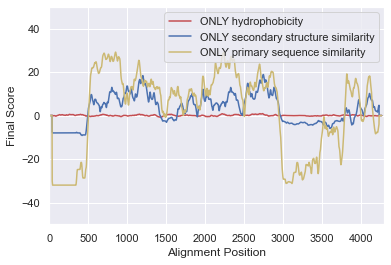

In [1360]:
paraplt (1, 0, 0, 35, 'r', 'ONLY hydrophobicity', 'no', 'no', '-', 1.0)
paraplt (0, 1, 0, 35, 'b', 'ONLY secondary structure similarity', 'no', 'no', '-', 1.0)
paraplt (0, 0, 1, 35, 'y', 'ONLY primary sequence similarity', 'no', 'no', '-', 1.0)

To visualize the instructiveness of each individual score, we discard the other two scores in each case and investigate how accurate UMA prediction can be if only one factor is taken into account. In the standard results, 12 residues are identified.
1. In the plot where only hydrophobicity is considered, no local minimum is visible due to the small score value, but 14 local minima are identified by argrelmin function. However, many of them are not aligned with those in the standard result, and 2 extra local minima are also identified. Therefore, hydrophobicity is only partially instructive and cannot be used alone to predict linker regions. This makes sense intuitively because two residues with similar hydrophobicity profiles may have different effects on the secondary structure and lead to different protein functions.
2. In the plot where only secondary structure similarity is considered, 12 local minima are visible and identified by argrelmin function. Despite the correct number of local minima is identified, many of them are again not aligned with those in the standard result. Therefore, secondary structure similarity may be more instructive than hydrophobicity, but it cannot be used alone as well.
3. In the plot where only primary sequence similarity is considered, 12 local minima are visible and identified by argrelmin function, and 9 of them are approximately aligned with those in the standard result. Therefore, primary sequence similarity is the most instructive score among all which can give over half of the predictions correctly when considered alone. By combining it with secondary structure similarity and hydrophobicity scores, even more accurate predictions can be made as shown in the standard result.

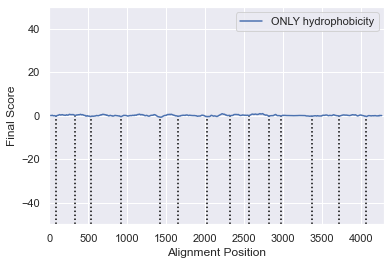

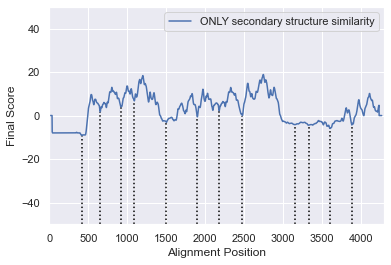

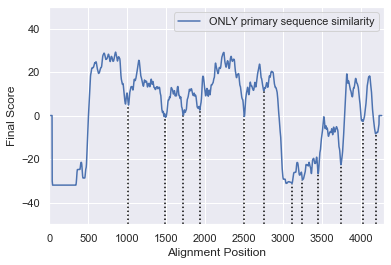

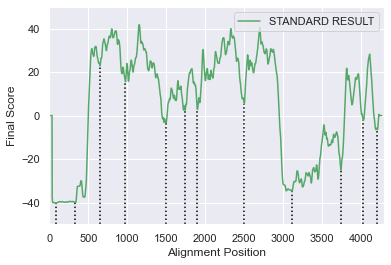

In [1361]:
paraplt (1, 0, 0, 35, 'b', 'ONLY hydrophobicity', 'yes', 'no', 'separate', 1.0)
paraplt (0, 1, 0, 35, 'b', 'ONLY secondary structure similarity', 'yes', 'no', 'separate', 1.0)
paraplt (0, 0, 1, 35, 'b', 'ONLY primary sequence similarity', 'yes', 'no', 'separate', 1.0)
paraplt (1, 1, 1, 35, 'g', 'STANDARD RESULT', 'yes', 'no', 'separate', 1.0)

### Tuning Parameters 2: Final Averaging Window Widths
The figure below shows that curves are steeper (oscillates to a greater extent) because the noise becomes more dominant when final averaging windows become narrower. In this case, more valleys are visible in the plot and more local minima may be identified. Therefore, for a specific protein of interest, the final averaging window width must be determined manually to give an interpretable curve shape and appopriate number of local minima.

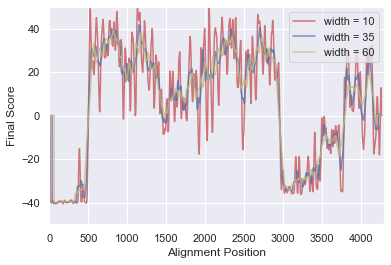

In [1362]:
paraplt (1, 1, 1, 10, 'r', 'width = 10', 'no', 'no', '-', 0.75)
paraplt (1, 1, 1, 35, 'b', 'width = 35', 'no', 'no', '-', 0.75)
paraplt (1, 1, 1, 60, 'y', 'width = 60', 'no', 'no', '-', 0.75)

The following three graphs clearly show that a narrower noise-dampening window leads to less local minima identified. With a window width of 10/35/60, 15/12/10 local minima are identified by argrelmin function respectively. These local minima, if exist, align with each other perfectly across the three graphs. This makes sense intuitively because an averaging window helps reduce the extremeness of data only and does not affect the underlying algorithm, so the positions of local minima will not change despite some of them may no longer be identifiable in a fixed comparison range of argrelmin function. Therefore, the final averaging window width can be freely adjusted to meet a specific threshold number of linker regions that is appropriate for the protein of interest.

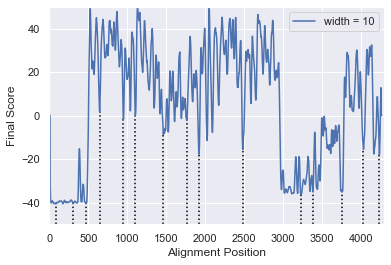

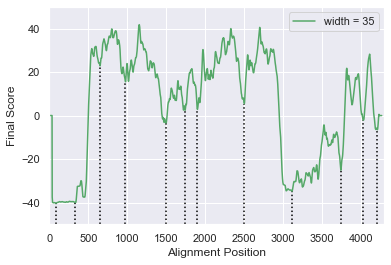

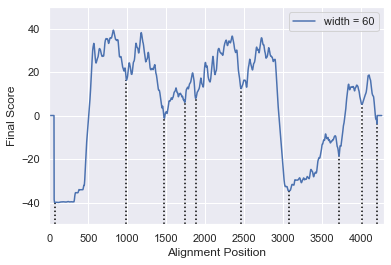

In [1363]:
paraplt (1, 1, 1, 10, 'b', 'width = 10', 'yes', 'no', 'separate', 1.0)
paraplt (1, 1, 1, 35, 'g', 'width = 35', 'yes', 'no', 'separate', 1.0)
paraplt (1, 1, 1, 60, 'b', 'width = 60', 'yes', 'no', 'separate', 1.0)

### Tuning Parameters 3: Penalty Values

A more negative penalty value, either that of gap-to-aa or gap-to-gap, penalize nonhomologous regions of the sequence more heavily and lowers their final score. The graph below shows two significantly nonhomologous regions that have final scores much lower when the penalty values are more negative. The first region is roughly at alignment position 0-500 (residue 1-501) which corresponds to the entire Loading Module. The second region is roughly at alignment position 3000-3750 (residue 2870-3070) which corresponds to the linker region between Module 2 AT/Module 2 KR. For other local minima, the final score is also lowered when the penalty value is more negative. This makes sense intuitively because nonhomologous regions are more likely to be linker regions and have a lower final score.

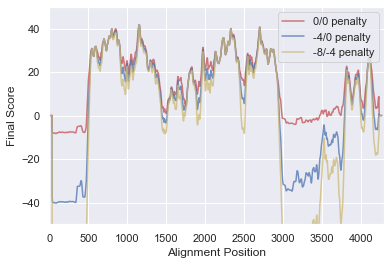

In [1364]:
ps_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
ps_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
psupdate (0, 0)
psequence (aln_pks, aln_num_pks, aln_len_pks, ps_pks_unsmd)
psequence_sm (aln_num_pks, aln_len_pks, ps_pks_unsmd, 5, ps_pks_smd)
paraplt (1, 1, 1, 35, 'r', '0/0 penalty', 'no', 'no', '-', 0.75)

ps_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
ps_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
psupdate (-4, 0)
psequence (aln_pks, aln_num_pks, aln_len_pks, ps_pks_unsmd)
psequence_sm (aln_num_pks, aln_len_pks, ps_pks_unsmd, 5, ps_pks_smd)
paraplt (1, 1, 1, 35, 'b', '-4/0 penalty', 'no', 'no', '-', 0.75)

ps_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
ps_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
psupdate (-8, -4)
psequence (aln_pks, aln_num_pks, aln_len_pks, ps_pks_unsmd)
psequence_sm (aln_num_pks, aln_len_pks, ps_pks_unsmd, 5, ps_pks_smd)
paraplt (1, 1, 1, 35, 'y', '-8/-4 penalty', 'no', 'no', '-', 0.75)

The effect of penalty values on the local minima identified is somewhat hard to generalize. As shown in the following graphs, 1 less local minimum is identified in both 0/0 penalty and -8/-4 penalty (in visible range) compared to the standard result with -4/0 penalty. A more negative final score resulting from a greater penalty value may lead to an extra identifiable minimum at this position. In contrast, it may also make an existing minimum nearby not identifiable anymore because this final score is now smaller than that existing minimum. According to these graphs, -4/0 penalty is preferred since the curve has a moderate smoothness and final scores are kept in a reasonable range for interpretation.

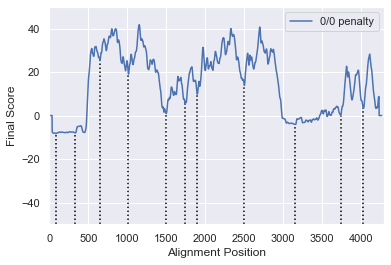

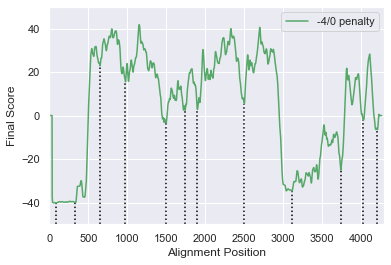

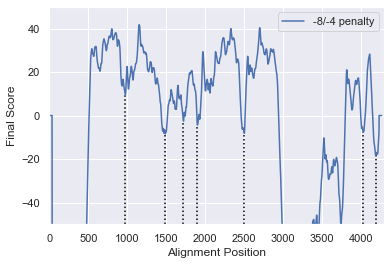

In [1365]:
ps_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
ps_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
psupdate (0, 0)
psequence (aln_pks, aln_num_pks, aln_len_pks, ps_pks_unsmd)
psequence_sm (aln_num_pks, aln_len_pks, ps_pks_unsmd, 5, ps_pks_smd)
paraplt (1, 1, 1, 35, 'b', '0/0 penalty', 'yes', 'no', 'separate', 1.0)

ps_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
ps_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
psupdate (-4, 0)
psequence (aln_pks, aln_num_pks, aln_len_pks, ps_pks_unsmd)
psequence_sm (aln_num_pks, aln_len_pks, ps_pks_unsmd, 5, ps_pks_smd)
paraplt (1, 1, 1, 35, 'g', '-4/0 penalty', 'yes', 'no', 'separate', 1.0)

ps_pks_unsmd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
ps_pks_smd = np.zeros((aln_num_pks, aln_len_pks), dtype = float)
psupdate (-8, -4)
psequence (aln_pks, aln_num_pks, aln_len_pks, ps_pks_unsmd)
psequence_sm (aln_num_pks, aln_len_pks, ps_pks_unsmd, 5, ps_pks_smd)
paraplt (1, 1, 1, 35, 'b', '-8/-4 penalty', 'yes', 'no', 'separate', 1.0)

***
### Project Summary
In this final project, we rewrite the Udwary-Merski Algorithm entirely in Python, test the code with S. enterica Methionine Synthase, and apply the code to A. erythreum PKS Module 1 and 2. The linker region prediction results are satisfying in both cases. The linker region information provided by this algorithm can shed light on PKS engineering since the interactions involving linker regions are critical in PKS catalytic mechanisms. There are two aspects of this algorithm that can be further improved:
1. Currently, score weights, averaging window widths, and penalty values need to be determined manually. Therefore, running an UMA analysis for a protein without any existing structural knowledge may be demanding due to the trial-and-error process for optimizing these parameters. If enough data is available, we can compile a training set and build a machine learning model to determine these parameters automatically. Given that not each local minimum corresponds to a linker region in reality, the final selection of linker regions can be automated by machine learning as well. 
3. Theoretically, the quality of UMA prediction is independent of sequence length. However, most secondary structure prediction softwares cannot process an excessively long protein (3528 aa of A. erythreum PKS Module 1 and 2 is already overwhelming for some). Therefore, given that crystal structure data is even harder to obtain, a more powerful secondary structure prediction tool will enable UMA to analyze longer protein sequences. 
***

### References
1. Udwary, D. W., Merski, M. & Townsend, C. A. A Method for Prediction of the Locations of Linker Regions within Large Multifunctional Proteins, and Application to a Type I Polyketide Synthase. J Mol Biol 323, 585–598 (2002).
2. Khosla, C. & Harbury, P. B. Modular enzymes. Nature 409, 247–252 (2001).
3. Kyte, J. & Doolittle, R. F. A simple method for displaying the hydropathic character of a protein. J Mol Biol 157, 105–132 (1982).
4. Henikoff, S. & Henikoff, J. G. Amino acid substitution matrices from protein blocks. Proc National Acad Sci 89, 10915–10919 (1992).
5. Pfeifer, B. A., Admiraal, S. J., Gramajo, H., Cane, D. E. & Khosla, C. Biosynthesis of Complex Polyketides in a Metabolically Engineered Strain of E. coli. Science 291, 1790–1792 (2001).
6. Khosla, C., Tang, Y., Chen, A. Y., Schnarr, N. A. & Cane, D. E. Structure and Mechanism of the 6-Deoxyerythronolide B Synthase. Annu Rev Biochem 76, 195–221 (2007). 
7. Brikun, I. A., Reeves, A. R., Cernota, W. H., Luu, M. B. & Weber, J. M. The erythromycin biosynthetic gene cluster of Aeromicrobium erythreum. J Industrial Microbiol Biotechnology 31, 335–344 (2004). 
8. Papadopoulos, J. S. & Agarwala, R. COBALT: constraint-based alignment tool for multiple protein sequences. Bioinformatics 23, 1073–1079 (2007).
9. Bernhofer, M. et al. PredictProtein - Predicting Protein Structure and Function for 29 Years. Nucleic Acids Res 49, W535–W540 (2021).
10. Eng, C. H., Backman, T. W. H., Bailey, C. B., Magnan, C., Martín, H. G., Katz, L., Baldi, P. & Keasling, J. D. ClusterCAD: a computational platform for type I modular polyketide synthase design. Nucleic Acids Res 46, D509–D515 (2018).
  
  
  
  
  
  
  
  
  
  
  

### Acknowledgements

I thank Prof. Daniel Rokhsar, Michael Eisen, and Liana Lareau for their wonderful teaching and suggestions to the project. I thank Prof. Craig Townsend (JHU) and Dr. Daniel Udwary (LBNL) for sharing the Perl 5 source code of UMA. I thank Keasling Lab for having me working on PKS engineering that leads to this project topic. I'm also grateful to my best friend Jessie who hosted me and supported my work when I was visiting her and completing this project at Haverford College during the spring break. Special thanks are given to the Lutnick Library there for bringing me luck :-)